
# Course: Artificial Intelligence for CyberSecurity 2022/2023

## Lecturers: 
* Prof. Antonio Greco &emsp;&emsp;&emsp;&nbsp; agreco@unisa.it
* Prof. Vincenzo Carletti &emsp;&emsp; vcarletti@unisa.it

## Group 04:
* Anna D'Andrea &emsp;&emsp;&emsp;&emsp;&emsp;&nbsp; 0622701682 &emsp;&emsp; a.dandrea26@studenti.unisa.it
* Carmine Coppola &emsp;&emsp;&emsp;&emsp; 0622701699 &emsp;&emsp; c.coppola79@studenti.unisa.it
* Enrico Maria Di Mauro &emsp;&emsp; 0622701706	&emsp;&emsp; e.dimauro5@studenti.unisa.it
* Allegra Cuzzocrea &emsp;&emsp;&emsp;&ensp;&nbsp; 0622701707 &emsp;&emsp; a.cuzzocrea2@studenti.unisa.it

# Colab Environment Setup

## Requirements

In [ ]:
!pip install tensorflow
!pip install adversarial-robustness-toolbox[all]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Workspace access

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Insert your current Google Drive folder
%cd '/content/drive/Shareddrives/Group04_AICS/SpeakerRecognition'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shareddrives/Group04_AICS/SpeakerRecognition


## Imports

In [ ]:
import os
import random
import sklearn
import librosa
import pickle

import soundfile as sf
import numpy as np
import pandas as pd
import IPython.display as ipd
import matplotlib.pyplot as plt

from functools import partial as fp
from librosa import display
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

# Audio model
import sys
sys.path.insert(0, 'Rete2Output')
from model import SpeakerID

# ART
import art
from art import config
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, ProjectedGradientDescent, DeepFool, CarliniL2Method
from art.defences.detector.evasion import BinaryInputDetector
from art.defences.trainer import AdversarialTrainer

## Necessary paths creation

In [ ]:
# Create all necessary paths
root = os.getcwd()
checkpoint_path = os.path.join(root, 'Rete2Output/resnet18_mel_25_10_norm.h5')
wav = os.path.join(root, 'wav')
precomputed = os.path.join(root, 'precomputed')
prec_samples = os.path.join(precomputed, 'samples')
prec_features = os.path.join(precomputed, 'features')
prec_models = os.path.join(precomputed, 'models')
prec_attacks = os.path.join(precomputed, 'attacks')

## Necessary functions

### Genarals

#### Features extraction

In [ ]:
def extract_features(audio_sample):
  # Read the audio file
  x, _ = librosa.load(audio_sample, sr=16000) # The method librosa.load returns the audio signal and the sample rate (sr)
  # Create batch
  x = np.expand_dims(x, 0)
  # Add channels dimension
  x = np.expand_dims(x, -1)
  features = model.predict(x)[1]  # taking the second output of the model
  return features

#### Samples loading

In [ ]:
def load_samples(dictionary):
  for up in os.scandir(prec_samples):
    dict_name = up.name
    if up.is_dir() and (dict_name in dictionary.keys()):
      for folder in os.scandir(up.path):
        if folder.is_dir():
          for sub in os.scandir(folder.path):
            if sub.is_dir():
              for file in os.scandir(sub.path):
                if file.is_file():
                  dictionary[dict_name].append(os.path.join(folder.name, sub.name, file.name))

#### Features or labels loading

In [ ]:
def load_features_labels(dictionary):
  for file in os.scandir(prec_features):
    dict_name = file.name[:-4]
    if file.is_file() and (dict_name in dictionary.keys()):
      dictionary[dict_name] = np.load(file.path)

#### Security evaluation curve

In [ ]:
def sec_eval_curve(x, y, labels, dictionary=None):
  title = 'Security Evaluation Curve'
  plt.figure()
  plt.xlabel(labels[0])
  plt.ylabel(labels[1])
  if dictionary != None:
    title += ' - '
    for name, value in dictionary.items():
      title += name + ' = ' + str(value) + ' '
  plt.title(title)
  plt.plot(x, y)  
  plt.show()

#### Comparison between 2 security evaluation curves

In [ ]:
def sec_comparison(x, y, labels, legend, dictionary=None):
  title = 'S.E.C. Comparison'
  figure, ax = plt.subplots()
  plt.xlabel(labels[0])
  plt.ylabel(labels[1])
  if dictionary != None:
    title += ' - '
    for name, value in dictionary.items():
      title += name + ' = ' + str(value) + ' '
  for i in range(len(y)):
    ax.plot(np.array(x), np.array(y[i]), label=legend[i])
  ax.legend(shadow=True, fontsize='medium')
  plt.title(title)
  plt.show()

#### Perturbation histogram

In [ ]:
def perturbation_histogram(x, z, l, dictionary=None):
  title = 'Perturbation Histogram'
  plt.figure(figsize=(20, 10))
  plt.xlabel(l[0])
  plt.ylabel(l[1])
  plt.bar(x, z, width=0.05, edgecolor='red')
  plt.xticks(x, rotation='vertical')
  plt.yticks(z)
  if dictionary != None:
    title += " - "
    for name, value in dictionary.items():
      title += name + " = " + str(value) + ' '
  plt.title(title)
  plt.show()

#### Comparison between 2 detection curve

In [ ]:
def det_comparison(x, y, labels, legend, dictionary=None):
  title = 'Detection Comparison'
  figure, ax = plt.subplots()
  plt.xlabel(labels[0])
  plt.ylabel(labels[1])
  if dictionary != None:
    title += ' - '
    for name, value in dictionary.items():
      title += name + ' = ' + str(value) + ' '
  for i in range(len(y)):
    ax.plot(np.array(x), np.array(y[i]), label=legend[i])
  ax.legend(shadow=True, fontsize='medium')
  plt.title(title)
  plt.show()

### Transformations

#### Noise Injection

In [ ]:
# It simply adds some random values into data by using numpy
def manipulate_noise(data, noise_factor):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

#### Shifting Time

In [ ]:
# It just shifts audio to left/right with a random second. 
# If shifting audio to left (fast forward) with x seconds, first x seconds will mark as 0 (i.e. silence). 
# If shifting audio to right (back forward) with x seconds, last x seconds will mark as 0 (i.e. silence).
def manipulate_shift(data, sampling_rate, shift_max, shift_direction):
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    # Set to silence for heading/tailing
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
    return augmented_data

#### Changing Pitch

In [ ]:
# This augmentation is a wrapper of librosa function. It changes pitch randomly
def manipulate_pitch(data, sampling_rate, pitch_factor):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

#### Changing Speed

In [ ]:
# This augmentation is performed by librosa function. It stretches times series by a fixed rate
def manipulate_speed(data, speed_factor):
    return librosa.effects.time_stretch(data, speed_factor)

#### Polarity Inversion

In [ ]:
# The amplitude of the signal is multiplied by -1. Therefore, the positive values become negative and the negative values become positive
def invert_polarity(signal):
    return signal * -1

#### Random Gain

In [ ]:
# The gain is the amount of amplification applied to a signal and it increases its strength. It's measured in decibels (dB)
def random_gain(signal, min_gain_factor, max_gain_factor):
    gain_factor = random.uniform(min_gain_factor, max_gain_factor)
    return signal * gain_factor

# Database

In [ ]:
# Read db file list
database = pd.read_csv('database.csv')
print(database)

        Unnamed: 0  split                           path        video  \
0                0      3  id10003/na8-QEFmj44/00003.wav  na8-QEFmj44   
1                1      1  id10003/tCq2LcKO6xY/00002.wav  tCq2LcKO6xY   
2                2      1  id10003/K5zRxtXc27s/00001.wav  K5zRxtXc27s   
3                3      1  id10003/bDxy7bnj_bc/00004.wav  bDxy7bnj_bc   
4                4      1  id10003/E_6MjfYr0sQ/00011.wav  E_6MjfYr0sQ   
...            ...    ...                            ...          ...   
152794      153511      1  id11251/s4R4hvqrhFw/00002.wav  s4R4hvqrhFw   
152795      153512      1  id11251/gFfcgOVmiO0/00006.wav  gFfcgOVmiO0   
152796      153513      3  id11251/7GtZpUtReJ8/00001.wav  7GtZpUtReJ8   
152797      153514      2  id11251/5-6lI5JQtb8/00001.wav  5-6lI5JQtb8   
152798      153515      3  id11251/7GtZpUtReJ8/00006.wav  7GtZpUtReJ8   

       VoxCeleb1 ID  VGGFace1 ID Gender Nationality  Set  
0           id10003   Aamir_Khan      m       India  dev  
1    

# SpeakerID

In [ ]:
# Loading the model
input_shape = (None, 1)
model = SpeakerID(input_shape, checkpoint_path, n_classes=1251)
model.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Colocations handled automatically by placer.


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 1)]         0         
                                                                 
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 log_melgram_layer (LogMelgr  (None, None, 128)        0         
 amLayer)                                                        
                                                                 
 z_score_normalization (ZSco  (None, None, 128)        0         
 reNormalization)                                                
                                                                 
 model (Functional)          [(None, 1251),            11822374  
                              (None, 512)]                       
                                                           

# Visualize a single audio sample

In [ ]:
# Read the audio file
y, sr = librosa.load('wav/id10270/5r0dWxy17C8/00001.wav', sr=16000) # librosa.load returns the audio signal and the sample rate (sr)

## Waveform

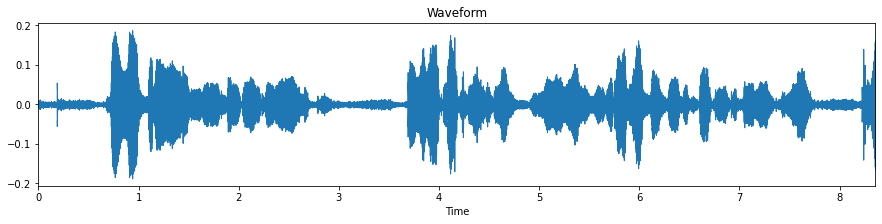

In [ ]:
# Waveform
plt.figure(figsize=(15, 3))
plt.title('Waveform')
display.waveplot(y, sr=sr)

## Mel Spectrogram

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

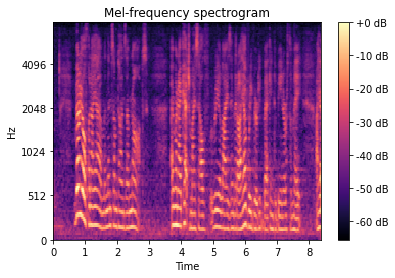

In [ ]:
# Mel Spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

## Playing Audio

In [ ]:
# Create batch
y = np.expand_dims(y, 0)
# Add channels dimension
y = np.expand_dims(y, -1)
# Playing audio
ipd.Audio(y[0,:,0], rate=16000, autoplay=False)

# Dataset setup

***Note***: in this section there are some steps marked as `skippable`.

"skippable" means that it is possible to not run that step because it will be possible to load the already constructed dataset subsequently.

**Attention**: you have 2 possibilities:
* skipping all steps marked as `skippable`
* not skipping any of the steps marked as `skippable` (it takes a lot of time)

## IDs - Samples dictionary creation `skippable`

In [ ]:
# Finding the total number of samples and users (auth and non-auth)
ids_samples = {}
total = 0
id_total = 0
folder_count = 0

for folder in os.scandir(wav):
  if folder.is_dir():
    folder_count += 1       
    for sub in os.scandir(folder.path):
      if sub.is_dir():
        for file in os.scandir(sub.path):
          if file.is_file():
            id_total += 1
        ids_samples[folder.name] = id_total
    id_total = 0
total = sum(ids_samples.values())

print("IDs and associated number of audio samples:", ids_samples)
print("Total number of audio samples:", total)
print("Total number of users:", folder_count)

IDs and associated number of audio samples: {'id10277': 67, 'id10272': 50, 'id10270': 158, 'id10278': 187, 'id10275': 74, 'id10276': 185, 'id10279': 63, 'id10271': 73, 'id10273': 240, 'id10274': 54, 'id10288': 48, 'id10281': 84, 'id10282': 84, 'id10289': 87, 'id10280': 67, 'id10287': 48, 'id10283': 233, 'id10285': 93, 'id10284': 90, 'id10286': 149, 'id10293': 194, 'id10299': 49, 'id10290': 137, 'id10291': 76, 'id10298': 127, 'id10295': 88, 'id10296': 98, 'id10297': 79, 'id10294': 138, 'id10292': 265, 'id10300': 304, 'id10304': 162, 'id10302': 166, 'id10303': 103, 'id10306': 184, 'id10309': 165, 'id10307': 156, 'id10305': 137, 'id10301': 48, 'id10308': 64}
Total number of audio samples: 4874
Total number of users: 40


## Authorized user `skippable`

In [ ]:
# Finding the auth user
highest_id = []
highest_sample_num = max(ids_samples.values())
for id, sample in ids_samples.items():
  if sample == highest_sample_num:
      highest_id.append(id)
auth_user = sorted(highest_id)[0]

print("The auth user is '" + auth_user + "' containing", highest_sample_num, "audio samples")

The auth user is 'id10300' containing 304 audio samples


## Minimum number of unauthorized users samples `skippable`

In [ ]:
# Finding the non-auth users with the least number of samples to create the Negative Class
lowest_id = []
lowest_sample_num = min(ids_samples.values())
for id, sample in ids_samples.items():
    if sample == lowest_sample_num:
        lowest_id.append(id)

print("The least numerous non-auth users are", sorted(lowest_id), "containing", lowest_sample_num, "audio samples")

The least numerous non-auth users are ['id10287', 'id10288', 'id10301'] containing 48 audio samples


## Positive and Negative class `skippable`

In [ ]:
# The Negative Class contains 48 random audio samples for each user, excluding the authorized one
positive_class = []
negative_class = []

for folder in os.scandir(wav): # scanning each folder "id10XXX"
  if folder.is_dir():
    tot_id_files = [] # tot_id_files will be initialized for each id (user)
    for sub in os.scandir(folder.path):
      if sub.is_dir():
        for file in os.scandir(sub.path):
          if file.is_file():
              tot_id_files.append(os.path.join(folder.name, sub.name, file.name))
    if folder.name == auth_user:
      positive_class = tot_id_files
    else:
      negative_class += random.sample(tot_id_files, lowest_sample_num)

print("Negative audio samples:", negative_class)
print("Total number of Negative audio samples:", len(negative_class)) 
print("\nPositive audio samples:", positive_class)
print("Total number of Positive audio samples:", len(positive_class))

Negative audio samples: ['id10277/cELY3LdIo-0/00002.wav', 'id10277/tbh20gz_KRA/00016.wav', 'id10277/tbh20gz_KRA/00010.wav', 'id10277/0rpfN7wThsg/00006.wav', 'id10277/znxUWA2QAGs/00008.wav', 'id10277/znxUWA2QAGs/00002.wav', 'id10277/tbh20gz_KRA/00012.wav', 'id10277/UIbPolhxLDI/00001.wav', 'id10277/znxUWA2QAGs/00001.wav', 'id10277/tbh20gz_KRA/00024.wav', 'id10277/UIbPolhxLDI/00002.wav', 'id10277/znxUWA2QAGs/00016.wav', 'id10277/znxUWA2QAGs/00007.wav', 'id10277/tbh20gz_KRA/00004.wav', 'id10277/tbh20gz_KRA/00017.wav', 'id10277/znxUWA2QAGs/00010.wav', 'id10277/tbh20gz_KRA/00020.wav', 'id10277/0rpfN7wThsg/00001.wav', 'id10277/SeXsHJ3fW1c/00003.wav', 'id10277/UIbPolhxLDI/00003.wav', 'id10277/tbh20gz_KRA/00021.wav', 'id10277/tbh20gz_KRA/00014.wav', 'id10277/znxUWA2QAGs/00004.wav', 'id10277/SeXsHJ3fW1c/00001.wav', 'id10277/znxUWA2QAGs/00009.wav', 'id10277/znxUWA2QAGs/00012.wav', 'id10277/tbh20gz_KRA/00025.wav', 'id10277/0rpfN7wThsg/00002.wav', 'id10277/8rby6ETXo8Q/00002.wav', 'id10277/SeXsHJ3fW

## Training, Validation and Test set split `skippable`



### Creation and Save `skippable`

In [ ]:
splitted = {'positive_train' : [], 'positive_val' : [], 'positive_test' : [], 'negative_train' : [], 'negative_val' : [], 'negative_test' : []}
positive_temp = []
negative_temp = []

# Dividing in training, validation and test set
splitted['positive_train'], positive_temp = train_test_split(positive_class, train_size = 0.6, random_state = 42)
splitted['positive_val'], splitted['positive_test'] = train_test_split(positive_temp, train_size = 0.5, random_state = 42)

splitted['negative_train'], negative_temp = train_test_split(negative_class, train_size = 0.6, random_state = 42)
splitted['negative_val'], splitted['negative_test'] = train_test_split(negative_temp, train_size = 0.5, random_state = 42)

# Saving splitted samples
for name, array in splitted.items():
  for sample in array:
    tokens = sample.split('/')
    y, _ = librosa.load(os.path.join(wav, sample), sr=16000)
    sample_path = os.path.join(root, 'precomputed/samples', name, tokens[0], tokens[1])
    os.makedirs(sample_path, exist_ok=True)
    sf.write(os.path.join(sample_path, tokens[2]), y, _)

### Load `skippable`

In [ ]:
splitted = {'positive_train' : [], 'positive_val' : [], 'positive_test' : [], 'negative_train' : [], 'negative_val' : [], 'negative_test' : []}

# Loading splitted samples
load_samples(splitted)

print('Positive Train:', len(splitted["positive_train"]), 'samples')
print('Positive Val:', len(splitted["positive_val"]), 'samples')
print('Positive Test:', len(splitted['positive_test']), 'samples')
print('Negative Train:', len(splitted['negative_train']), 'samples')
print('Negative Val:', len(splitted['negative_val']), 'samples')
print('Negative Test:', len(splitted['negative_test']), 'samples')

Positive Train: 182 samples
Positive Val: 61 samples
Positive Test: 61 samples
Negative Train: 1123 samples
Negative Val: 374 samples
Negative Test: 375 samples


## Data augmentation `skippable`

### Creation and Save `skippable`

In [ ]:
aug_splitted = {'augmented_train' : [], 'augmented_val' : [], 'augmented_test' : []}

# Generating and saving the augmented audio samples
diff_train = len(splitted['negative_train']) - len(splitted["positive_train"])
diff_val = len(splitted['negative_val']) - len(splitted["positive_val"])
diff_test = len(splitted['negative_test']) - len(splitted['positive_test'])

for (name, array), diff, positive in zip(aug_splitted.items(), [diff_train, diff_val, diff_test], [splitted["positive_train"], splitted["positive_val"], splitted['positive_test']]):
  count = -1
  for i in range(diff):
    # Reading the audio file
    index = i % len(positive)
    if index == 0:
      count += 1
    sample = positive[index]
    tokens = sample.split('/')
    y, _ = librosa.load(os.path.join(wav, sample), sr=16000)
    manipulations = [fp(manipulate_noise, y, 0.1), fp(manipulate_shift, y, _, 1, 'both'), fp(manipulate_pitch, y, _, 24), fp(manipulate_speed, y, 0.5), fp(manipulate_speed, y, 1.5), fp(random_gain, y, 2, 4), fp(invert_polarity, y)]
    augmented_sample = random.choice(manipulations)()
    sample_path = os.path.join(root, 'precomputed/samples/' + name, tokens[0], tokens[1])
    os.makedirs(sample_path, exist_ok=True)
    sf.write(os.path.join(sample_path, f'aug_{count}_{tokens[2]}'), augmented_sample, _)
    array.append(os.path.join(tokens[0], tokens[1], f'aug_{count}_{tokens[2]}'))

### Load `skippable`

In [ ]:
aug_splitted = {'augmented_train' : [], 'augmented_val' : [], 'augmented_test' : []}

# Loading splitted samples
load_samples(aug_splitted)

print('Augmented Train:', len(aug_splitted['augmented_train']), 'samples')
print('Augmented Val:', len(aug_splitted['augmented_val']), 'samples')
print('Augmented Test:', len(aug_splitted['augmented_test']), 'samples')

Augmented Train: 941 samples
Augmented Val: 313 samples
Augmented Test: 314 samples


## Features extraction and Labels creation

### Partials `skippable`

#### Creation and Save `skippable`

In [ ]:
features = {'train_positive_features': [], 'val_positive_features': [], 'test_positive_features': [], 'train_negative_features': [], 'val_negative_features': [], 'test_negative_features': [], 'train_augmented_features': [], 'val_augmented_features': [], 'test_augmented_features': []}
labels = {'train_positive_labels': [], 'val_positive_labels': [], 'test_positive_labels': [], 'train_negative_labels': [], 'val_negative_labels': [], 'test_negative_labels': [], 'train_augmented_labels': [], 'val_augmented_labels': [], 'test_augmented_labels': []}

# Obtaining features and labels
for (name, array), feature, label in zip(list(splitted.items()) + list(aug_splitted.items()), features.values(), labels.values()):
  for audio in array:
    feature.append(extract_features(os.path.join(prec_samples, name, audio)))
    if audio.split('/')[0] == auth_user:
      label.append(1)
    else:
      label.append(0)

# Saving as numpy arrays
os.makedirs(prec_features, exist_ok=True)

for (name, array) in list(features.items()) + list(labels.items()):
  np.save(os.path.join(prec_features, name + '.npy'), np.array(array))

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


#### Load `skippable`

In [ ]:
features = {'train_positive_features': [], 'val_positive_features': [], 'test_positive_features': [], 'train_negative_features': [], 'val_negative_features': [], 'test_negative_features': [], 'train_augmented_features': [], 'val_augmented_features': [], 'test_augmented_features': []}
labels = {'train_positive_labels': [], 'val_positive_labels': [], 'test_positive_labels': [], 'train_negative_labels': [], 'val_negative_labels': [], 'test_negative_labels': [], 'train_augmented_labels': [], 'val_augmented_labels': [], 'test_augmented_labels': []}

# Loading features and labels
load_features_labels(features)
load_features_labels(labels)

for name, feature, label in zip(list(splitted.keys()) + list(aug_splitted.keys()), features.values(), labels.values()):
  print(len(feature), 'features vectors extracted for', name)
  print(len(label), "labels for", name)

182 features vectors extracted for positive_train
182 labels for positive_train
61 features vectors extracted for positive_val
61 labels for positive_val
61 features vectors extracted for positive_test
61 labels for positive_test
1123 features vectors extracted for negative_train
1123 labels for negative_train
374 features vectors extracted for negative_val
374 labels for negative_val
375 features vectors extracted for negative_test
375 labels for negative_test
941 features vectors extracted for augmented_train
941 labels for augmented_train
313 features vectors extracted for augmented_val
313 labels for augmented_val
314 features vectors extracted for augmented_test
314 labels for augmented_test


### Totals

#### Creation and Save `skippable`

In [ ]:
# Merging all the features vectors and labels
final_train_features = np.concatenate((features['train_positive_features'], features['train_negative_features'], features['train_augmented_features']))
final_train_labels = np.concatenate((labels['train_positive_labels'], labels['train_negative_labels'], labels['train_augmented_labels']))
final_val_features = np.concatenate((features['val_positive_features'], features['val_negative_features'], features['val_augmented_features']))
final_val_labels = np.concatenate((labels['val_positive_labels'], labels['val_negative_labels'], labels['val_augmented_labels']))
final_test_features = np.concatenate((features['test_positive_features'], features['test_negative_features'], features['test_augmented_features']))
final_test_labels = np.concatenate((labels['test_positive_labels'], labels['test_negative_labels'], labels['test_augmented_labels']))

np.save(os.path.join(prec_features, 'final_train_features.npy'), final_train_features)
np.save(os.path.join(prec_features, 'final_train_labels.npy'), final_train_labels)
np.save(os.path.join(prec_features, 'final_val_features.npy'), final_val_features)
np.save(os.path.join(prec_features, 'final_val_labels.npy'), final_val_labels)
np.save(os.path.join(prec_features, 'final_test_features.npy'), final_test_features)
np.save(os.path.join(prec_features, 'final_test_labels.npy'), final_test_labels)

#### Load

In [ ]:
final_train_features = np.load(os.path.join(prec_features, 'final_train_features.npy'))
final_train_labels = np.load(os.path.join(prec_features, 'final_train_labels.npy'))
final_val_features = np.load(os.path.join(prec_features, 'final_val_features.npy'))
final_val_labels = np.load(os.path.join(prec_features, 'final_val_labels.npy'))
final_test_features = np.load(os.path.join(prec_features, 'final_test_features.npy'))
final_test_labels = np.load(os.path.join(prec_features, 'final_test_labels.npy'))

print('Final train has:', len(final_train_features), 'features')
print('Final train has:', len(final_train_labels), 'labels')
print('Final val has:', len(final_val_features), 'features')
print('Final val has:', len(final_val_labels), 'labels')
print('Final test has:', len(final_test_features), 'features')
print('Final test has:', len(final_test_labels), 'labels')

Final train has: 2246 features
Final train has: 2246 labels
Final val has: 748 features
Final val has: 748 labels
Final test has: 750 features
Final test has: 750 labels


# Training and Testing of models

***Note***: in this section there are some steps marked as `skippable`.

"skippable" means that it is possible to not run that step because it will be possible to load the already constructed dataset subsequently.

**Attention**: you have 2 possibilities:
* skipping all steps marked as `skippable`
* not skipping any of the steps marked as `skippable` (it takes a lot of time)

## Features reshape

In [ ]:
x_train = final_train_features.reshape(final_train_features.shape[0], final_train_features.shape[2])
x_val = final_val_features.reshape(final_val_features.shape[0], final_val_features.shape[2])
x_test = final_test_features.reshape(final_test_features.shape[0], final_test_features.shape[2])

print('Train Features shape:', final_train_features.shape, '--> Reshaping -->', x_train.shape)
print('Val Features shape:', final_val_features.shape, '--> Reshaping -->', x_val.shape)
print('Test Features shape:', final_test_features.shape, '--> Reshaping -->', x_test.shape)

max_f = np.max(x_test)
min_f = np.min(x_test)

print('Minimum test feature: ', min_f)
print('Maximum test feature: ', max_f)

Train Features shape: (2246, 1, 512) --> Reshaping --> (2246, 512)
Val Features shape: (748, 1, 512) --> Reshaping --> (748, 512)
Test Features shape: (750, 1, 512) --> Reshaping --> (750, 512)
Minimum test feature:  0.0
Maximum test feature:  8.32201


## One-hot encoding

In [ ]:
y_train = tf.keras.utils.to_categorical(final_train_labels)
y_val = tf.keras.utils.to_categorical(final_val_labels)
y_test = tf.keras.utils.to_categorical(final_test_labels)

zeros = np.count_nonzero(y_train == [1, 0], axis=0)
ones = np.count_nonzero(y_train == [0, 1], axis=0)
print("Train Labels - Zeros:", zeros[0], "- Ones:", ones[0], "- Shape:", y_train.shape)

zeros = np.count_nonzero(y_val == [1, 0], axis=0)
ones = np.count_nonzero(y_val == [0, 1], axis=0)
print("Val Labels - Zeros:", zeros[0], "- Ones:", ones[0], "- Shape:", y_val.shape)

zeros = np.count_nonzero(y_test == [1, 0], axis=0)
ones = np.count_nonzero(y_test == [0, 1], axis=0)
print("Test Labels - Zeros:", zeros[0], "- Ones:", ones[0], "- Shape:", y_test.shape)

Train Labels - Zeros: 1123 - Ones: 1123 - Shape: (2246, 2)
Val Labels - Zeros: 374 - Ones: 374 - Shape: (748, 2)
Test Labels - Zeros: 375 - Ones: 375 - Shape: (750, 2)


## MLP white box model and classifiers

### Architecture `skippable`

In [ ]:
# Set the input shape
feature_vector_length = 512
input_shape = (feature_vector_length, )

# Instantiate an empty Sequential model
mlp_wb = Sequential()

# A hidden layer
mlp_wb.add(Dense(350, activation = 'relu', input_shape = input_shape))

# A second hidden layer
mlp_wb.add(Dense(100, activation = 'relu'))

# A third hidden layer
mlp_wb.add(Dense(50, activation = 'relu'))

# An output layer
mlp_wb.add(Dense(2))
mlp_wb.add(Activation('sigmoid'))

print(mlp_wb.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 350)               179550    
                                                                 
 dense_1 (Dense)             (None, 100)               35100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 2)                 102       
                                                                 
 activation (Activation)     (None, 2)                 0         
                                                                 
Total params: 219,802
Trainable params: 219,802
Non-trainable params: 0
_________________________________________________________________
None


### Train

#### Creation and Save `skippable`

In [ ]:
mlp_wb.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
mlp_wb.fit(x_train, y_train, epochs = 10, batch_size = 250, verbose = 1, validation_data = (x_val, y_val))
#mlp_wb.save(os.path.join(precomputed, 'mlp_wb.h5'))

classifier_gb = KerasClassifier(model=mlp_wb, clip_values=(min_f, max_f))   # Classifier for Gradient Based attacks

logit_model = tf.keras.Model(mlp_wb.input, mlp_wb.layers[-2].output)
classifier_dcw = KerasClassifier(model=logit_model, clip_values=(min_f, max_f))   # Classifier for Deepfool and Carlini-Wagner

Train on 2246 samples, validate on 748 samples
Epoch 1/10
2246/2246 [==============================] - 1s 348us/sample - loss: 0.2417 - accuracy: 0.9132 - val_loss: 0.0326 - val_accuracy: 0.9987
Epoch 2/10
2246/2246 [==============================] - 0s 68us/sample - loss: 0.0104 - accuracy: 0.9982 - val_loss: 0.0060 - val_accuracy: 0.9993
Epoch 3/10
2246/2246 [==============================] - 0s 70us/sample - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 0.9987
Epoch 4/10
2246/2246 [==============================] - 0s 69us/sample - loss: 4.3319e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 5/10
2246/2246 [==============================] - 0s 66us/sample - loss: 1.4214e-04 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 6/10
2246/2246 [==============================] - 0s 66us/sample - loss: 8.4949e-05 - accuracy: 1.0000 - val_loss: 9.4974e-04 - val_accuracy: 1.0000
Epoch 7/10
2246/2246 [==============================] 

#### Load

In [ ]:
mlp_wb = tf.keras.models.load_model(os.path.join(prec_models, 'mlp_wb.h5'))

classifier_gb = KerasClassifier(model=mlp_wb, clip_values=(min_f, max_f))   # Classifier for Gradient Based attacks

logit_model = tf.keras.Model(mlp_wb.input, mlp_wb.layers[-2].output)
classifier_dcw = KerasClassifier(model=logit_model, clip_values=(min_f, max_f))   # Classifier for Deepfool and Carlini-Wagner

### Test

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Test results - Loss: 0.0008237921047882348 - Accuracy: 100.0 %


/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


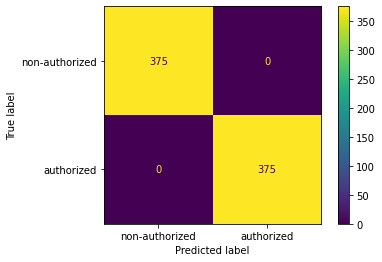

In [ ]:
# Test the MLP model after training
test_results = mlp_wb.evaluate(x_test, y_test)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100} %')

# Calculating Labels
pred_mlp_wb = mlp_wb.predict(x_test)
y_pred_mlp_wb = np.argmax(pred_mlp_wb, axis = 1)
y_test_conf = np.argmax(y_test, axis = 1)

# Plotting Confusion Matrix
conf = confusion_matrix(y_test_conf, y_pred_mlp_wb)
disp = ConfusionMatrixDisplay(confusion_matrix = conf, display_labels=['non-authorized','authorized'])
disp.plot()
plt.show()

## KNN black box model

k = 1 and the accuracy is 99.6 %


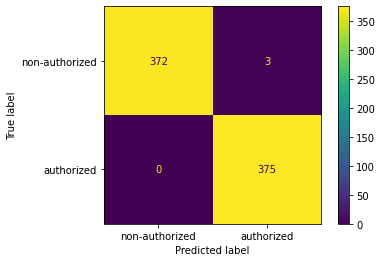

In [ ]:
# KNN black box model
k = 1
knn_bb = KNeighborsClassifier(n_neighbors = k)
knn_bb.fit(x_train, y_train)
score = knn_bb.score(x_test, y_test)
print("k =", k, "and the accuracy is", score*100, "%")

# Calculating Labels
pred_knn_bb = knn_bb.predict(x_test)
y_pred_knn_bb = np.argmax(pred_knn_bb, axis = 1)

# Plotting Confusion Matrix
conf = confusion_matrix(y_test_conf, y_pred_knn_bb)
disp = ConfusionMatrixDisplay(confusion_matrix = conf, display_labels=['non-authorized','authorized'])
disp.plot()
plt.show()

## MLP black box model

The accuracy is 100.0 %


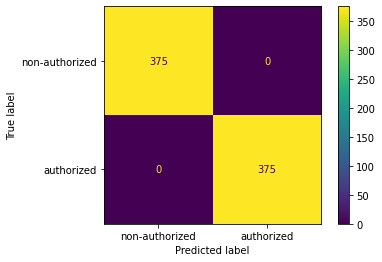

In [ ]:
# MLP black box model
mlp_bb = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1).fit(x_train, y_train)
score = mlp_bb.score(x_test, y_test)
print("The accuracy is", score*100, "%")

# Calculating Labels
pred_mlp_bb = mlp_bb.predict(x_test)
y_pred_mlp_bb = np.argmax(pred_mlp_bb, axis = 1)

# Plotting Confusion Matrix
conf = confusion_matrix(y_test_conf, y_pred_mlp_bb)
disp = ConfusionMatrixDisplay(confusion_matrix = conf, display_labels=['non-authorized','authorized'])
disp.plot()
plt.show()

# Attacks

***Note***: in this section there are some steps marked as `skippable`.

"skippable" means that it is possible to not run that step because it will be possible to load the already constructed dataset subsequently.

**Attention**: you have 2 possibilities:
* skipping all steps marked as `skippable`
* not skipping any of the steps marked as `skippable` (it takes a lot of time)

## Generic

### FGSM

##### Creation and Save `skippable`

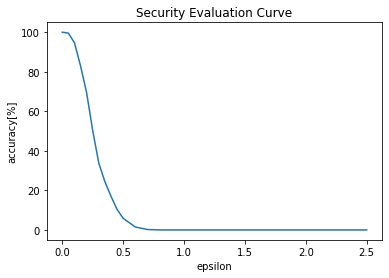

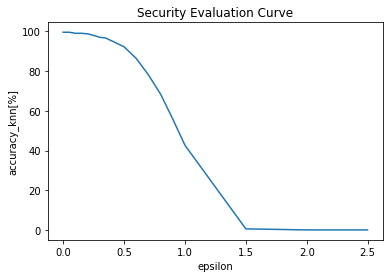

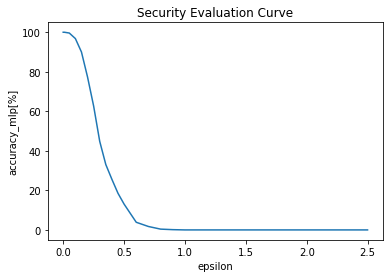

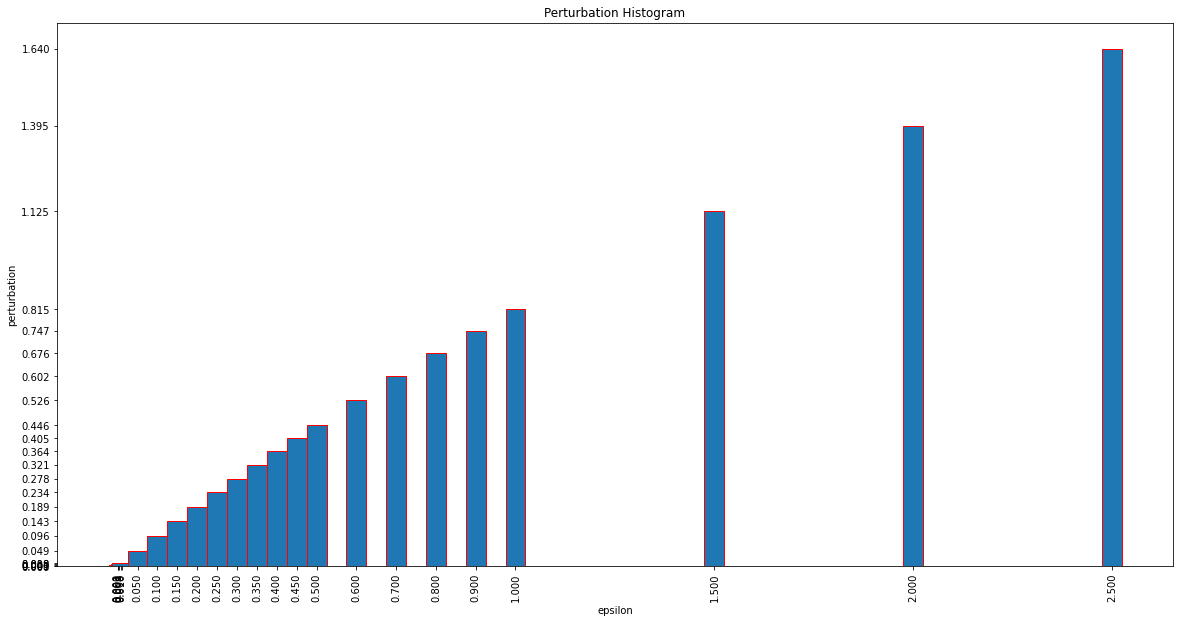

In [ ]:
result_fgsm_generic = {}
corrupted_fgsm_generic = []
epsilons = [0, 0.001, 0.003, 0.008, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2, 2.5]

perturbations = []
accuracies = []
accuracies_knn = []
accuracies_mlp = []

for eps in epsilons:
  attack = FastGradientMethod(estimator=classifier_gb, eps=eps, targeted=False) 
  att = attack.generate(x_test)
  corrupted_fgsm_generic.append(att)
  
  perturbation = np.mean(np.abs((att - x_test)))
  loss, accuracy = mlp_wb.evaluate(att, y_test)
  accuracy_knn = knn_bb.score(att, y_test)
  accuracy_mlp = mlp_bb.score(att, y_test)

  perturbations.append(perturbation)
  accuracies.append(accuracy * 100)
  accuracies_knn.append(accuracy_knn * 100)
  accuracies_mlp.append(accuracy_mlp * 100)
  
  result_fgsm_generic[eps] = (perturbation, accuracy * 100)

sec_eval_curve(epsilons, accuracies, ["epsilon", "accuracy[%]"])
sec_eval_curve(epsilons, accuracies_knn, ["epsilon", "accuracy_knn[%]"])
sec_eval_curve(epsilons, accuracies_mlp, ["epsilon", "accuracy_mlp[%]"])
perturbation_histogram(epsilons, perturbations, ["epsilon", "perturbation"])

os.makedirs(prec_attacks, exist_ok=True)
with open(os.path.join(prec_attacks, 'result_fgsm_generic.pkl'), 'wb') as f:
  pickle.dump(result_fgsm_generic, f)
with open(os.path.join(prec_attacks, 'corrupted_fgsm_generic.pkl'), 'wb') as f:
  pickle.dump(corrupted_fgsm_generic, f)

##### Load

In [ ]:
with open(os.path.join(prec_attacks, 'result_fgsm_generic.pkl'), 'rb') as f:
  result_fgsm_generic = pickle.load(f)
with open(os.path.join(prec_attacks, 'corrupted_fgsm_generic.pkl'), 'rb') as f:
  corrupted_fgsm_generic = pickle.load(f)

### BIM

##### Creation and Save `skippable`

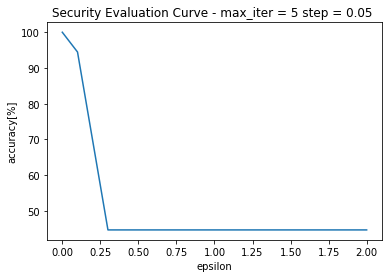

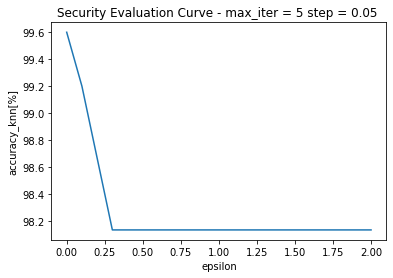

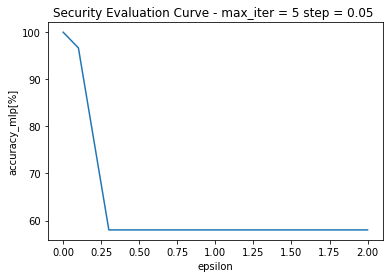

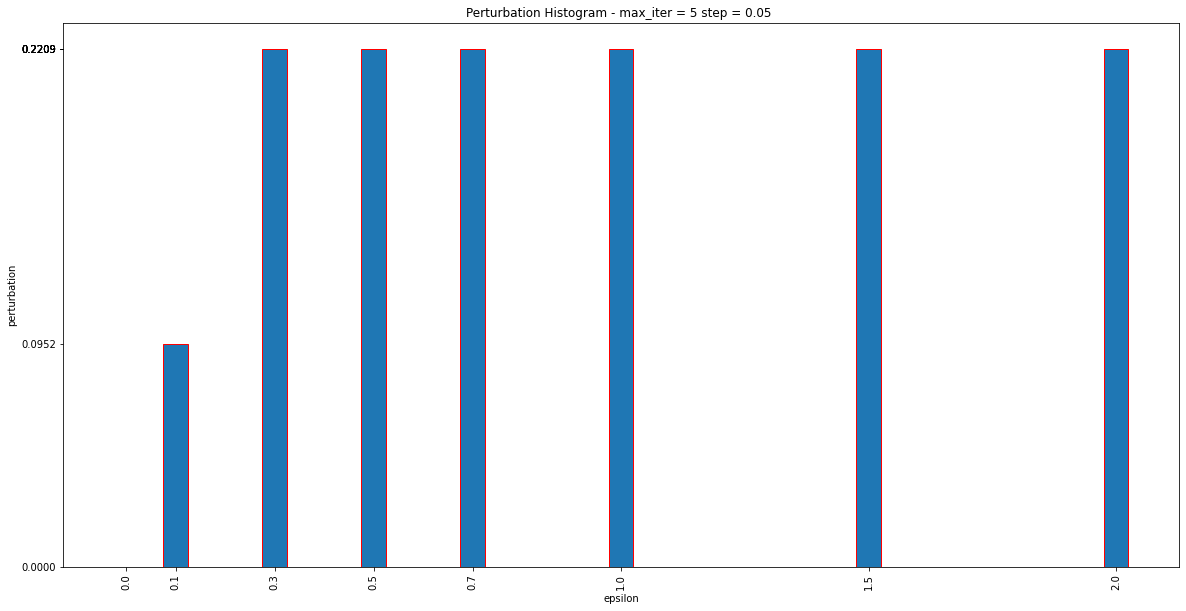

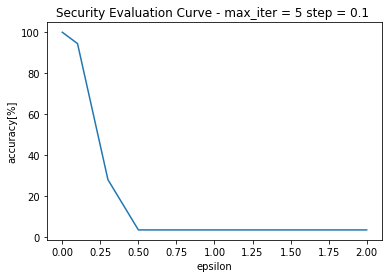

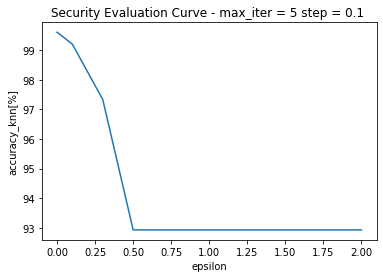

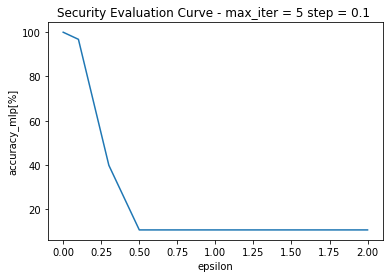

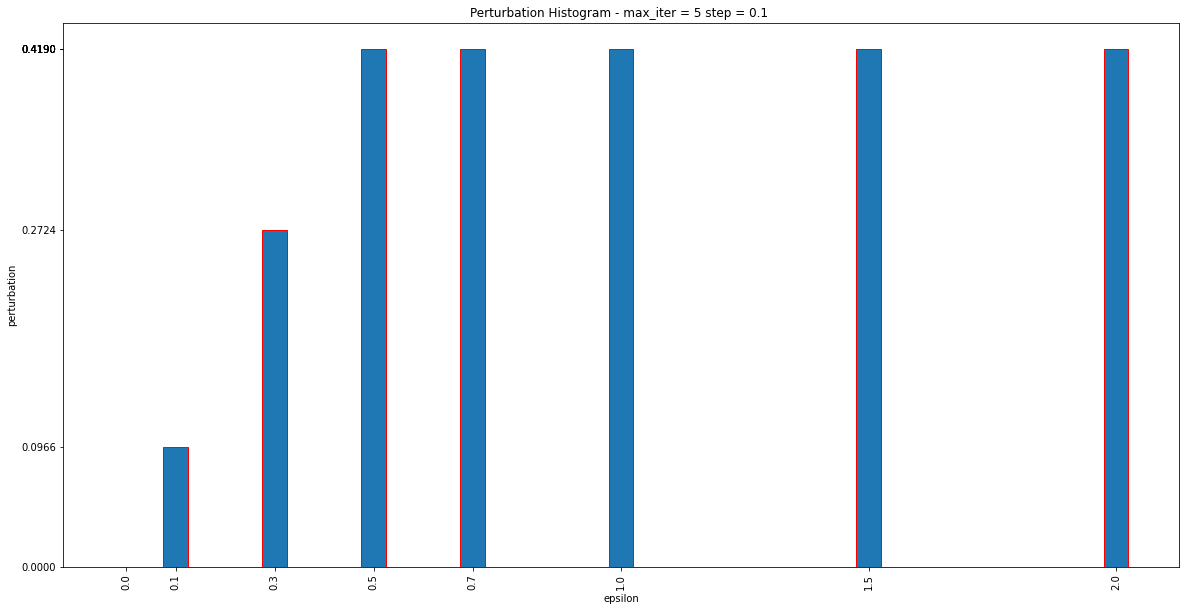

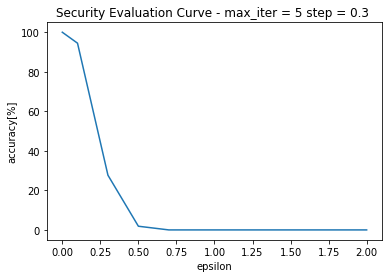

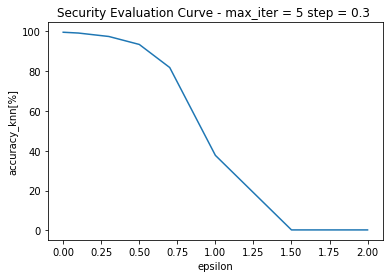

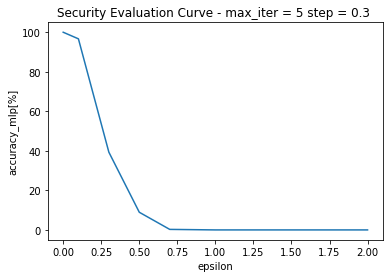

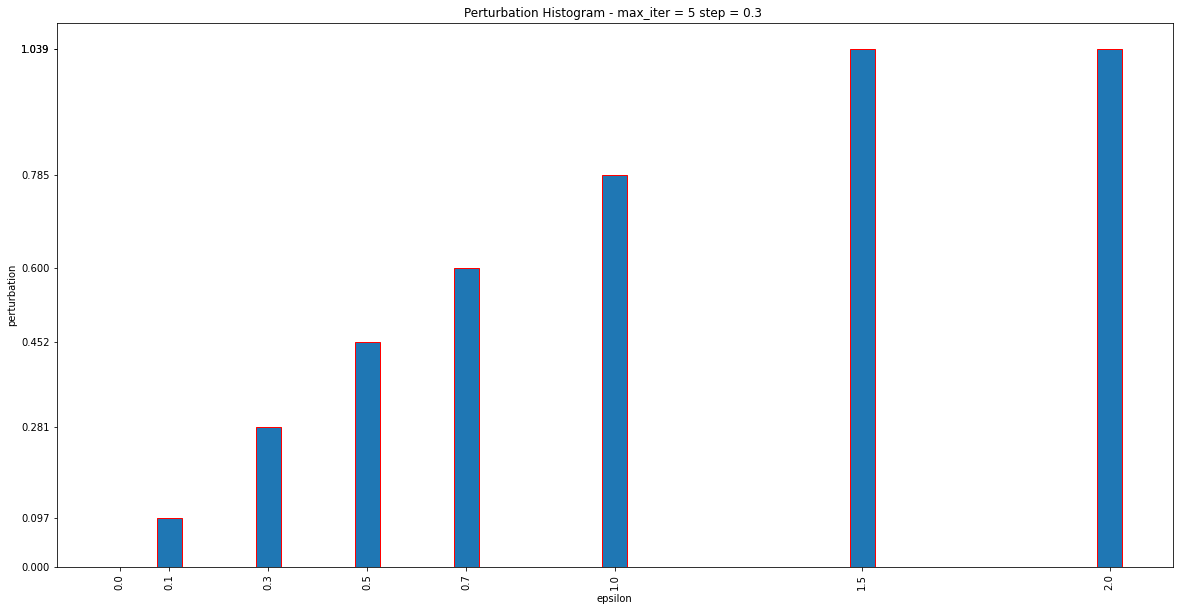

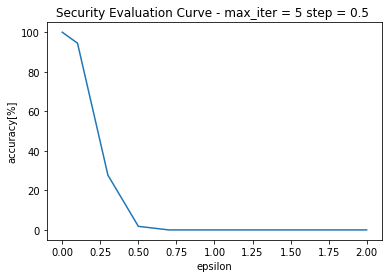

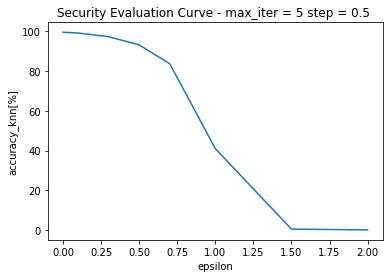

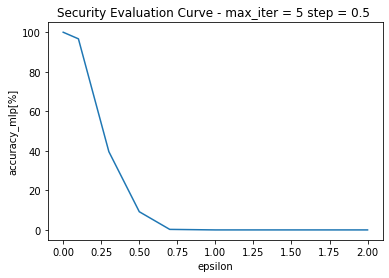

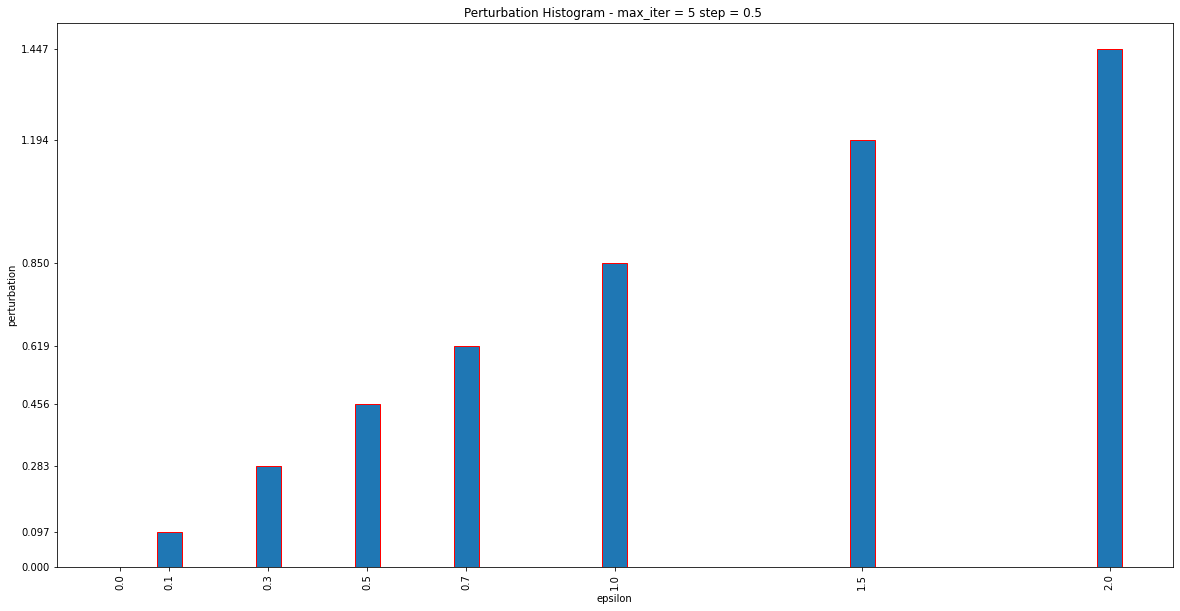

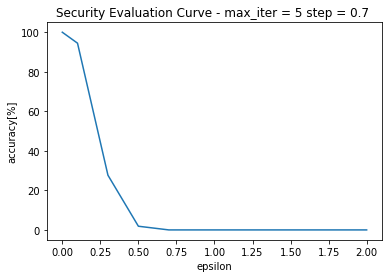

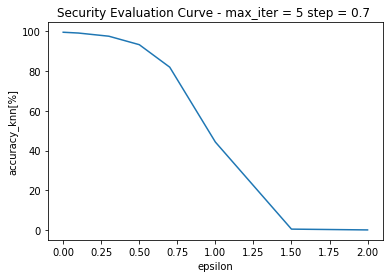

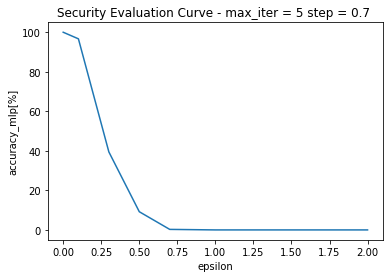

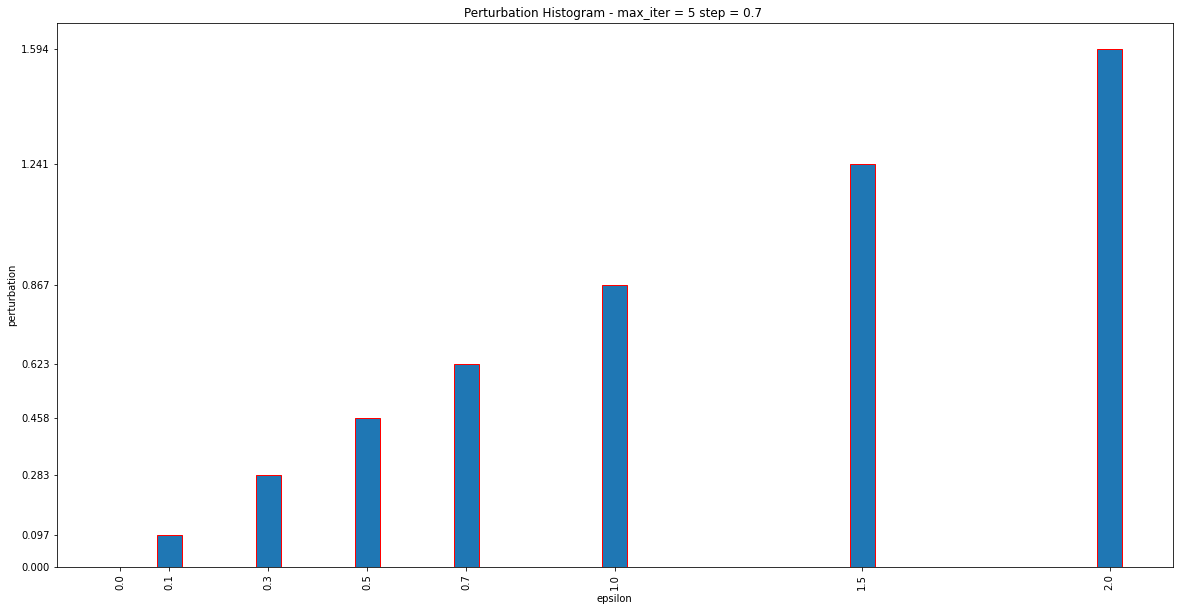

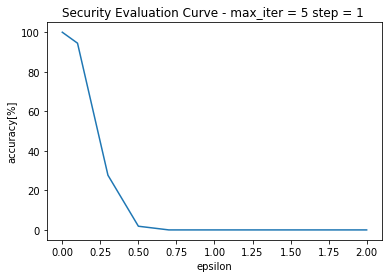

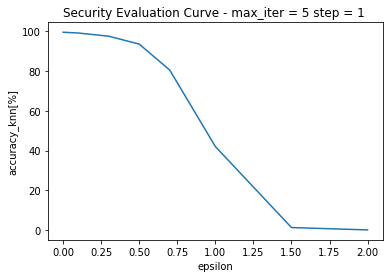

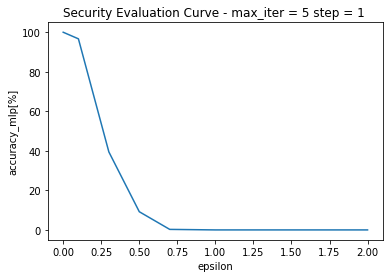

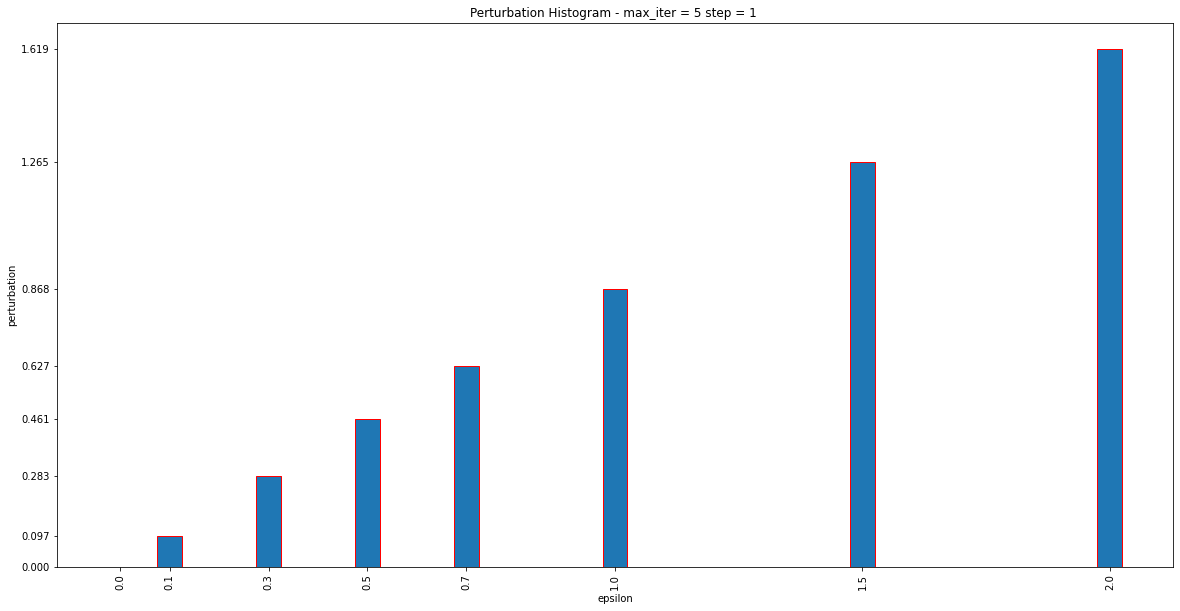

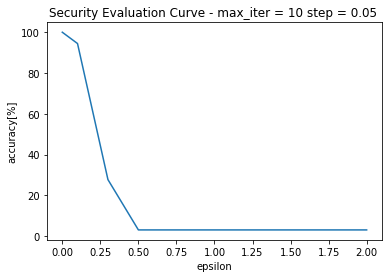

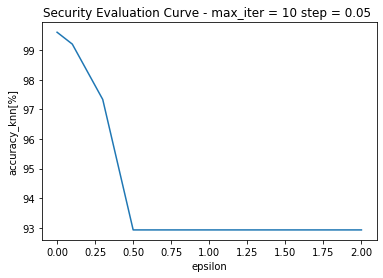

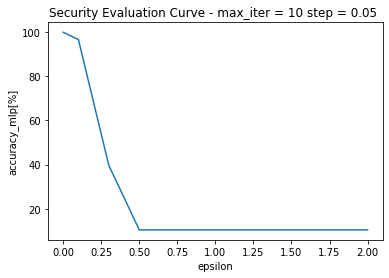

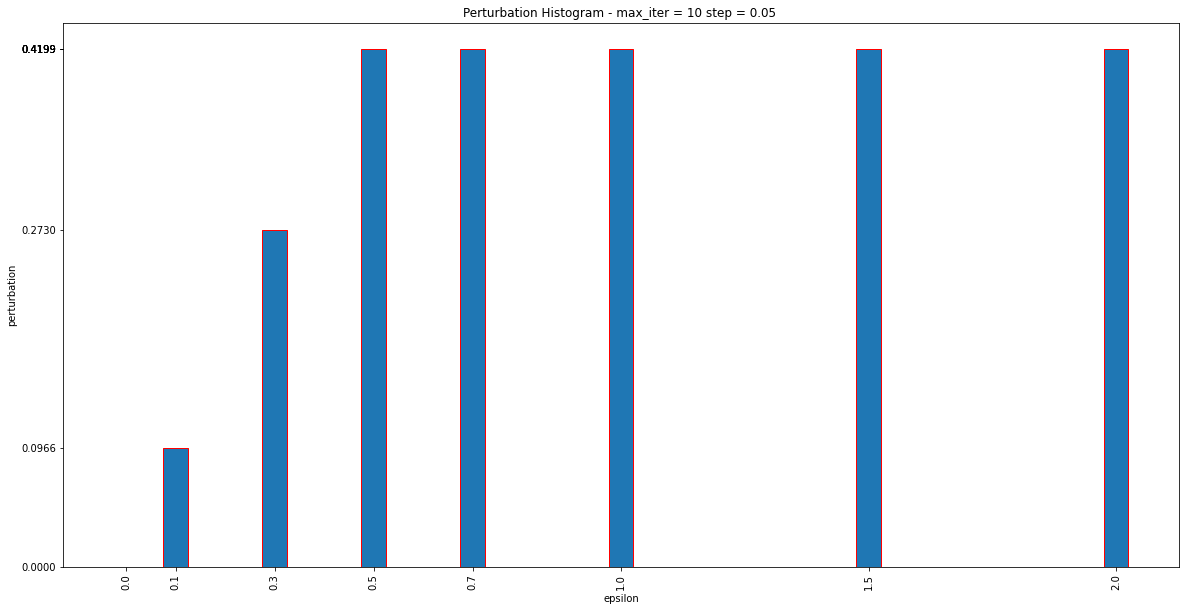

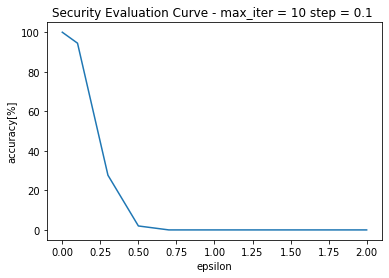

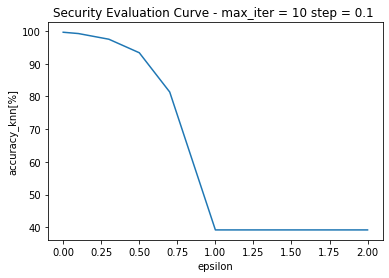

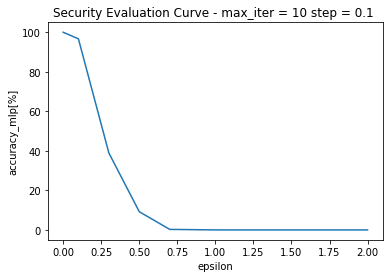

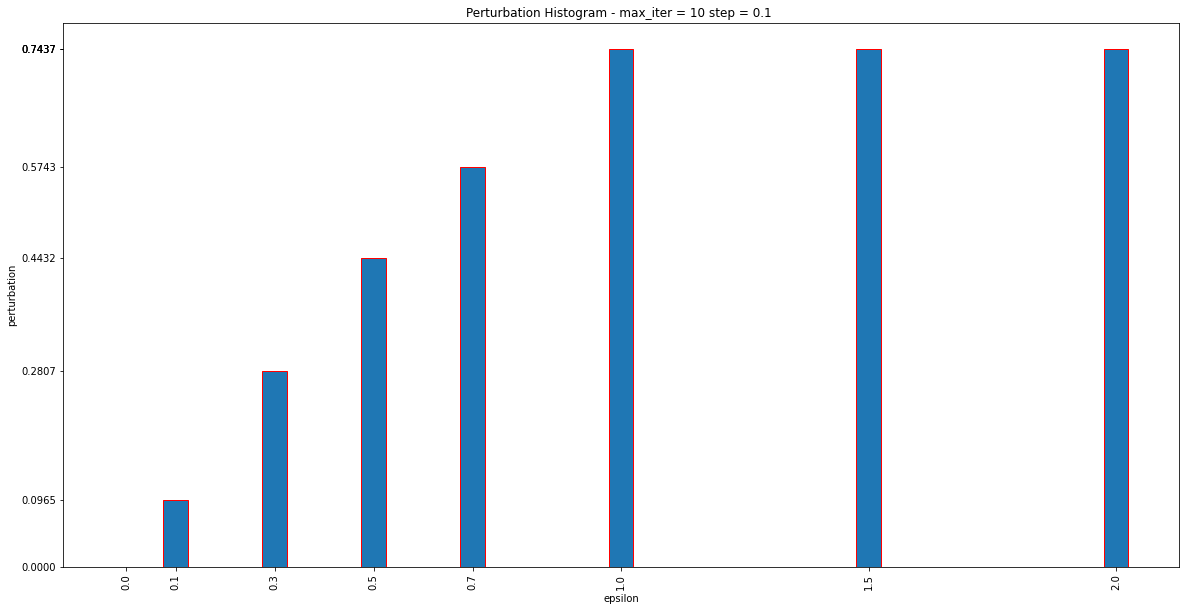

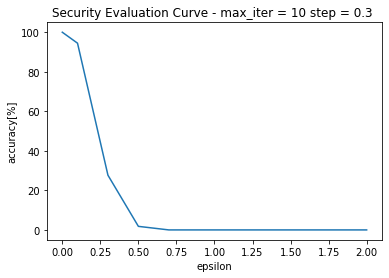

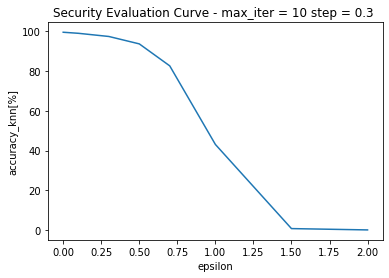

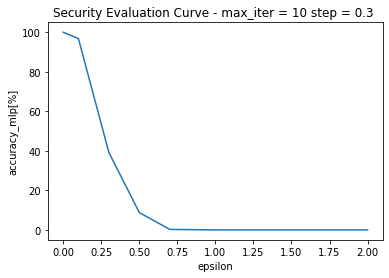

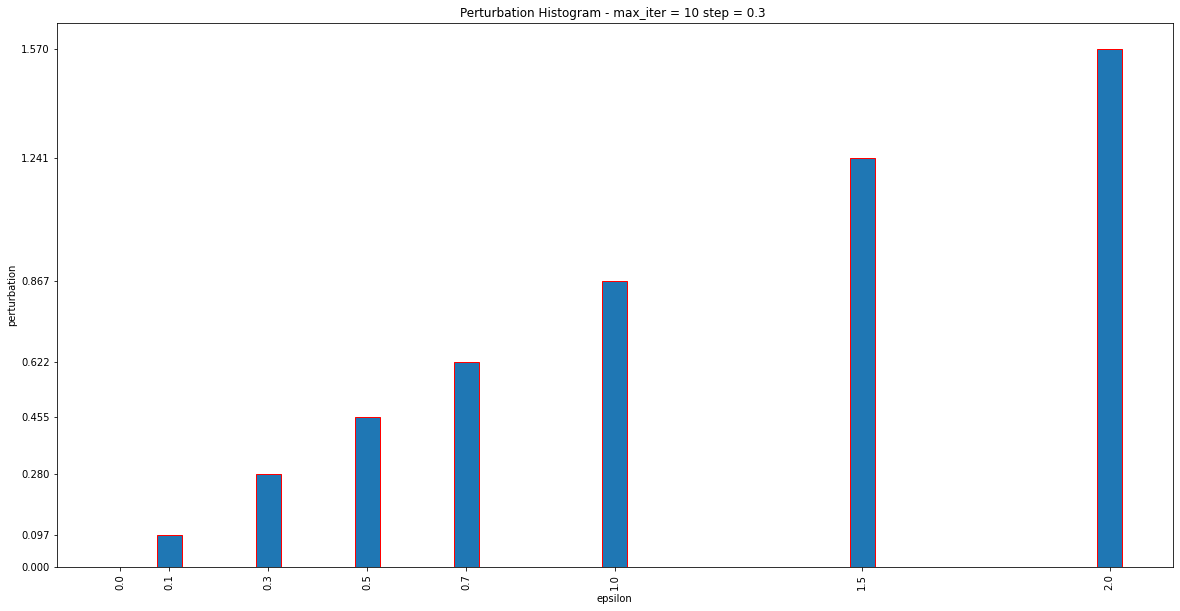

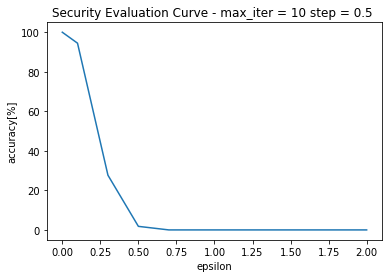

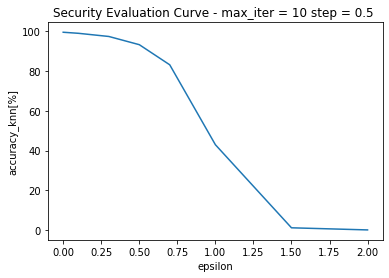

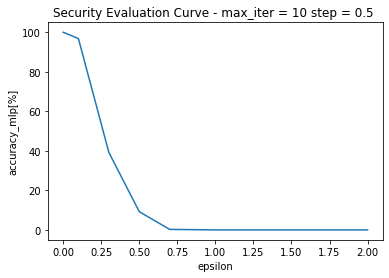

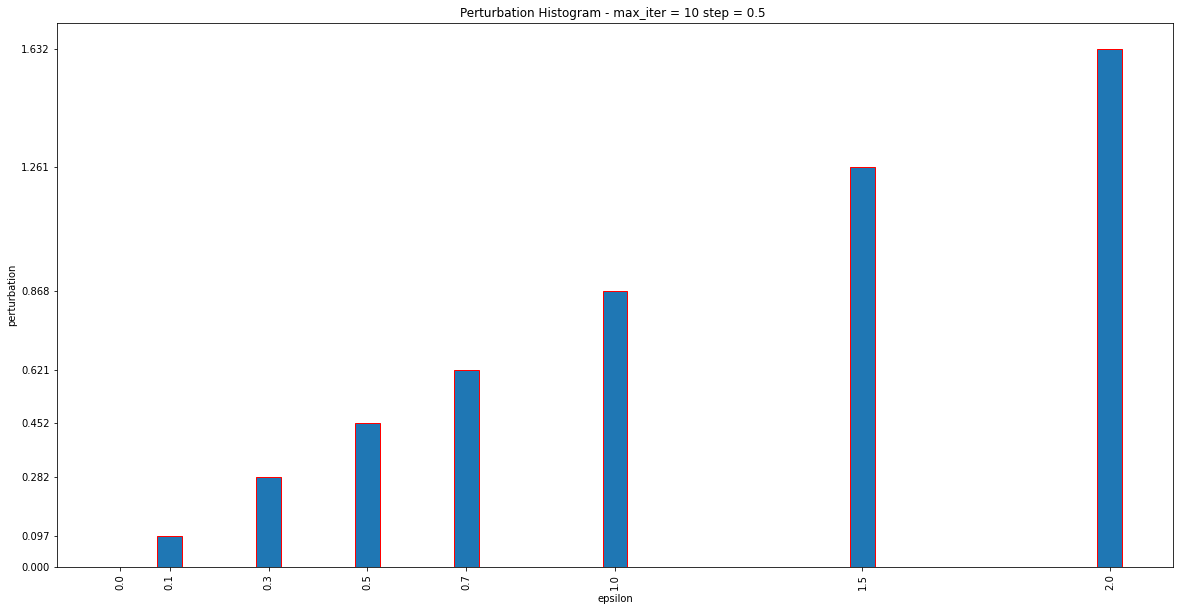

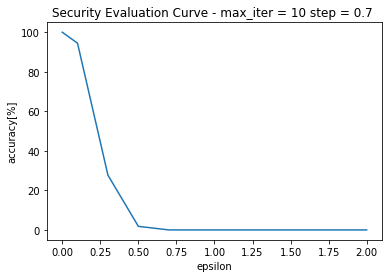

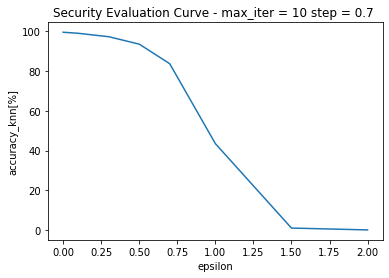

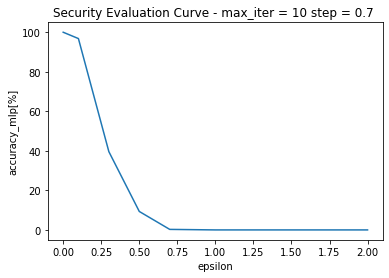

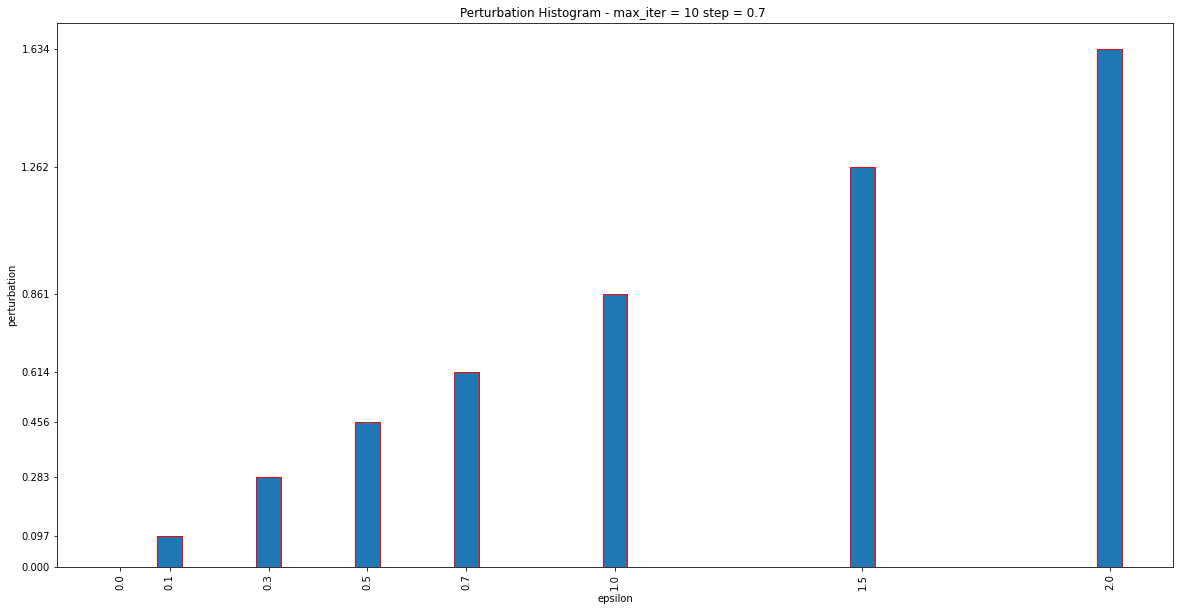

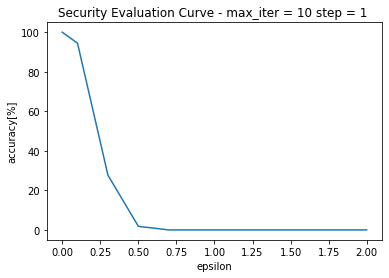

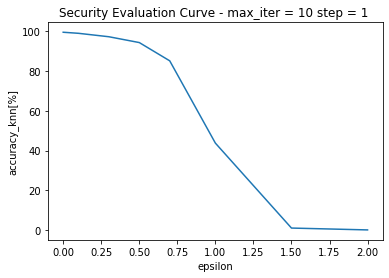

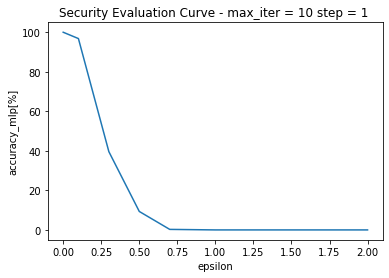

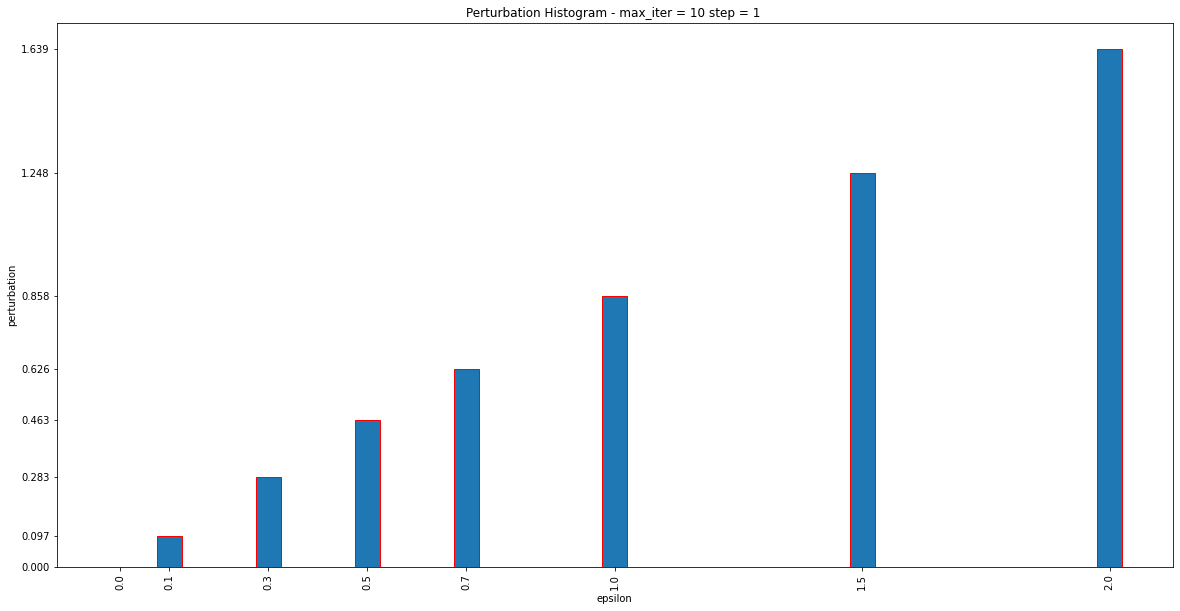

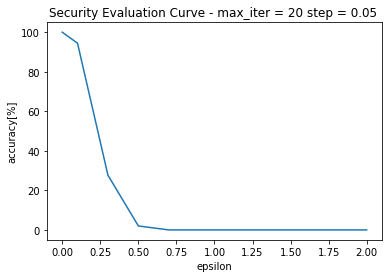

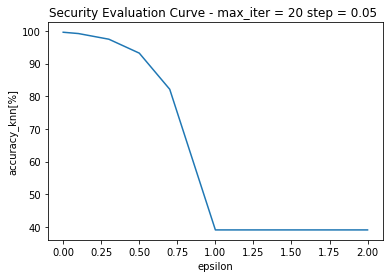

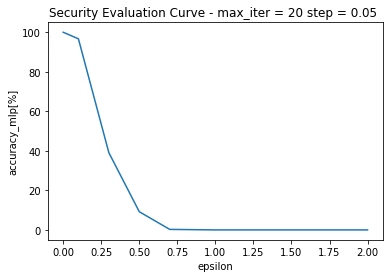

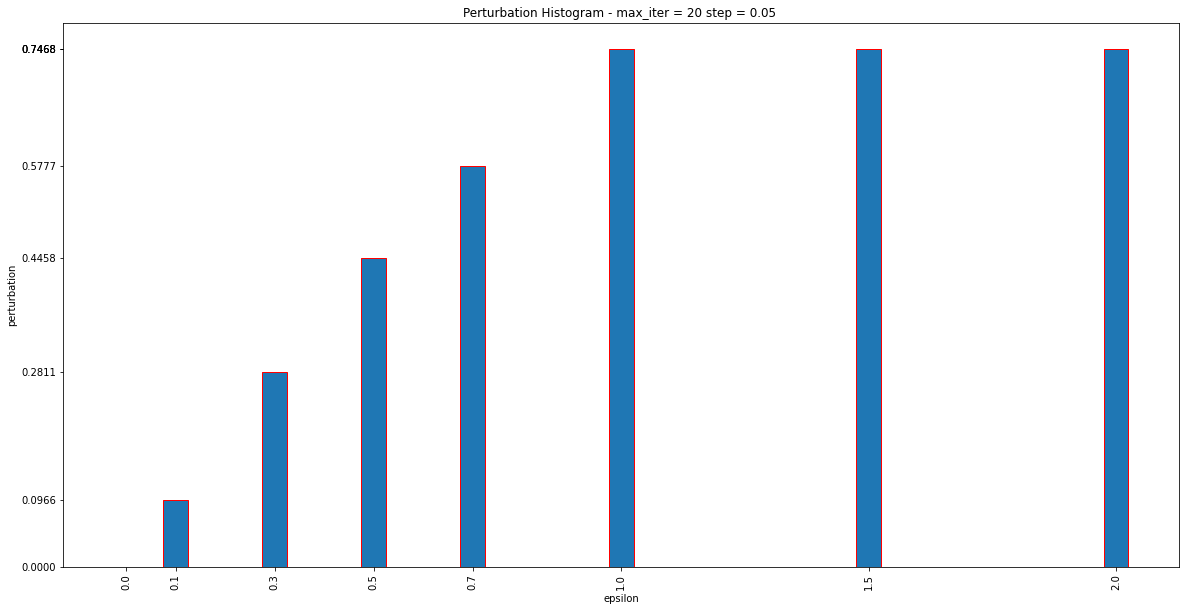

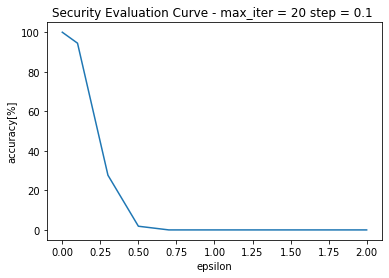

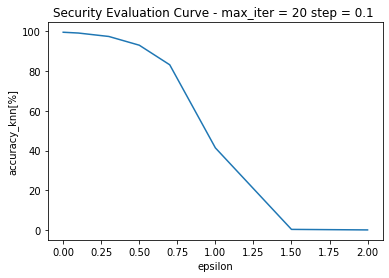

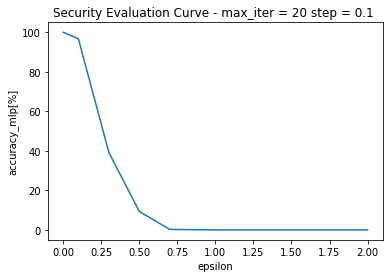

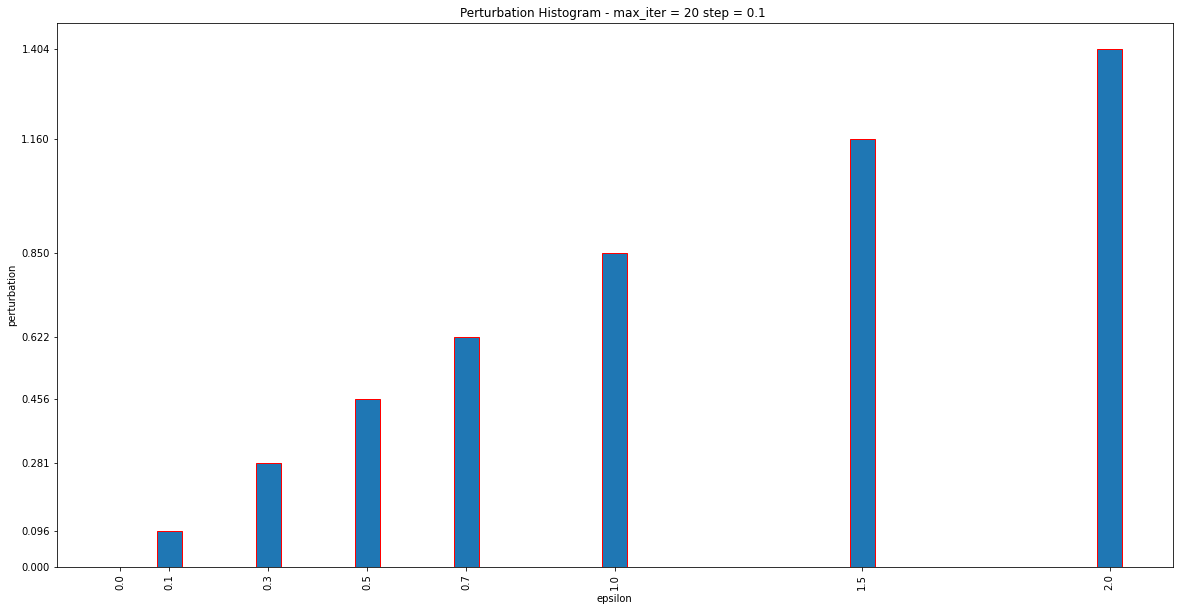

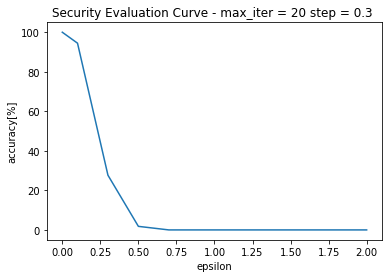

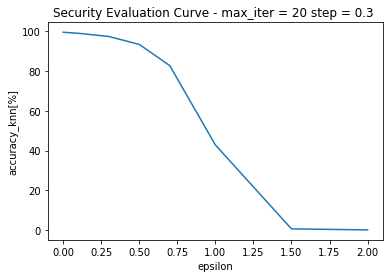

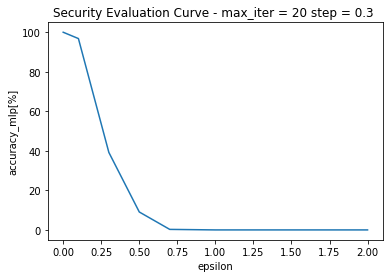

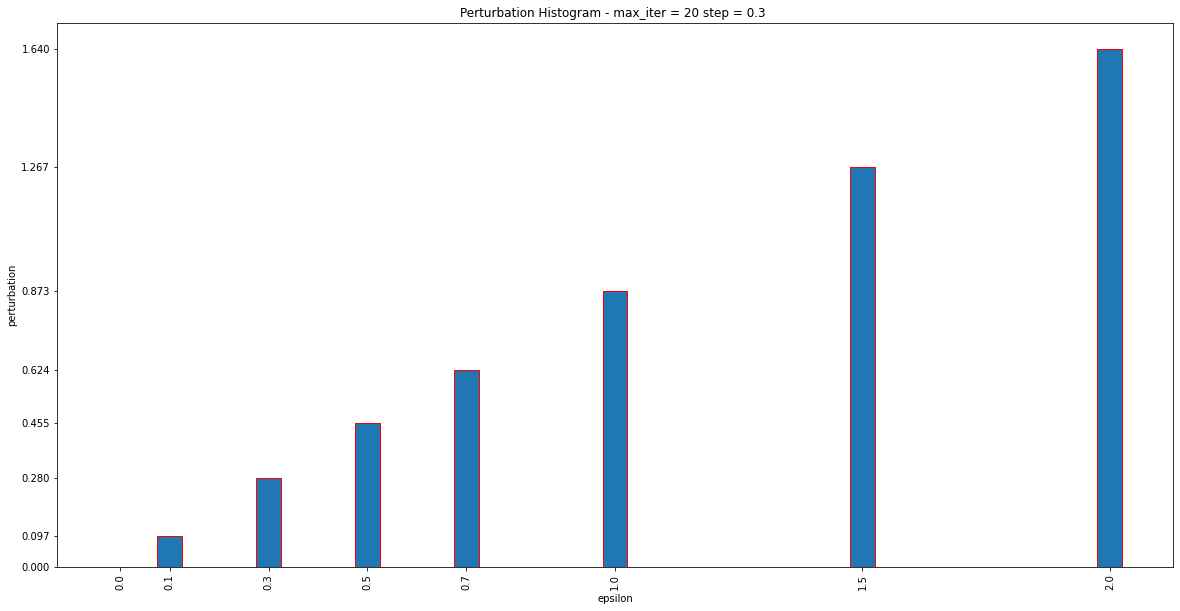

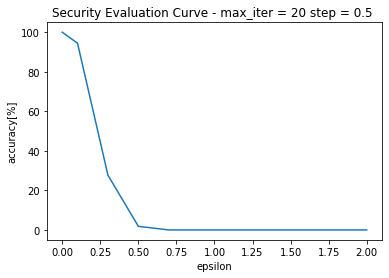

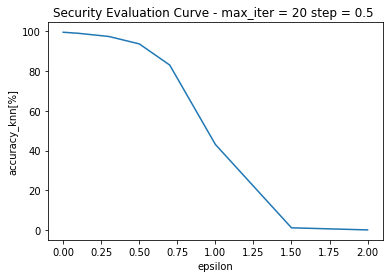

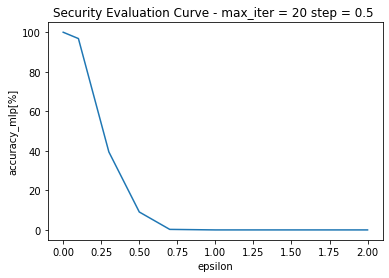

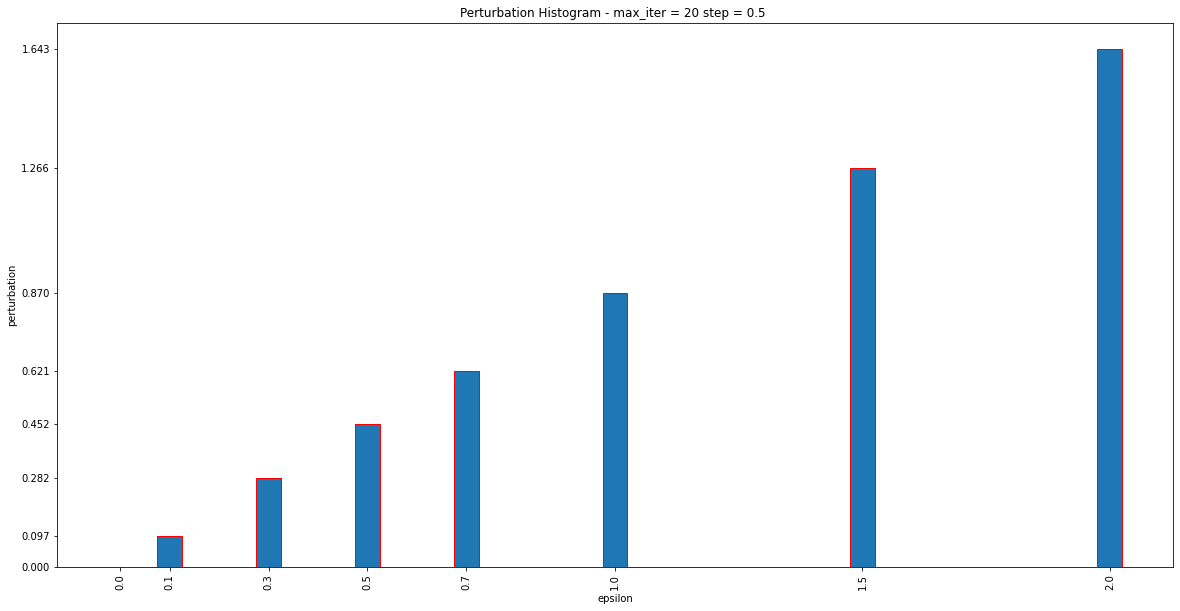

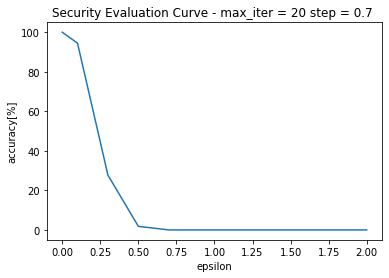

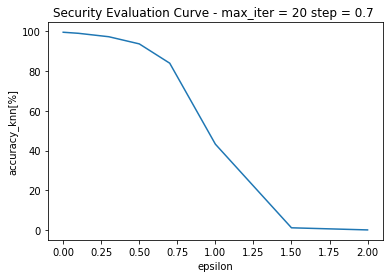

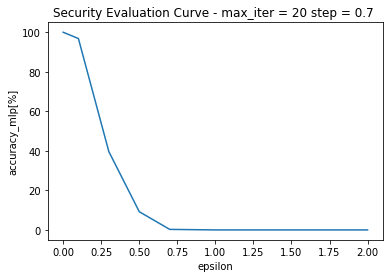

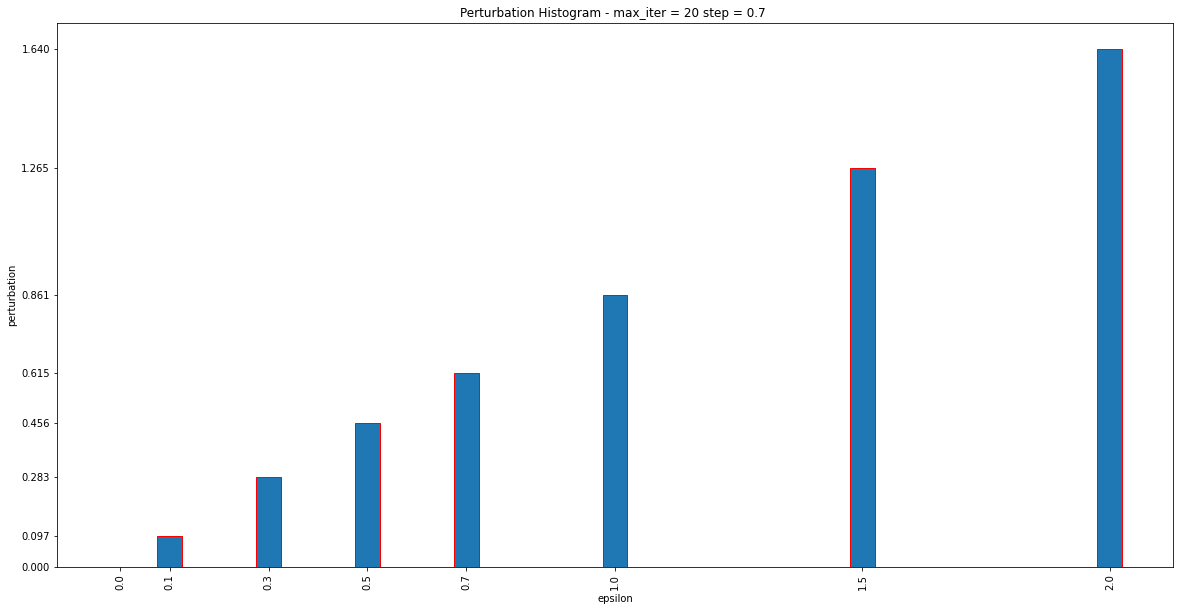

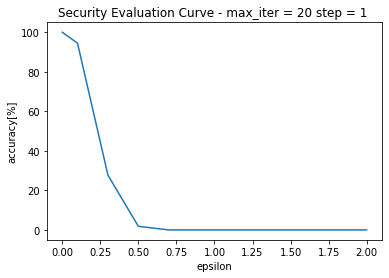

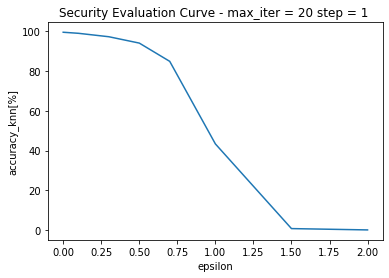

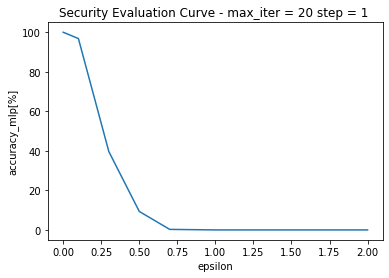

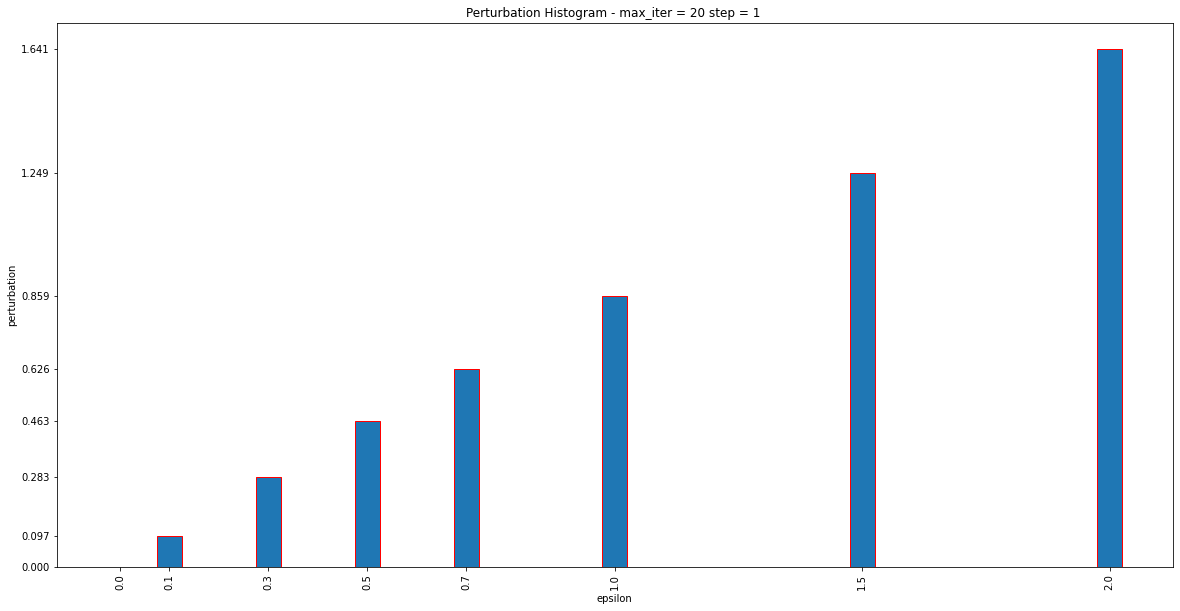

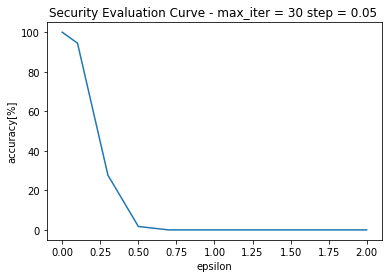

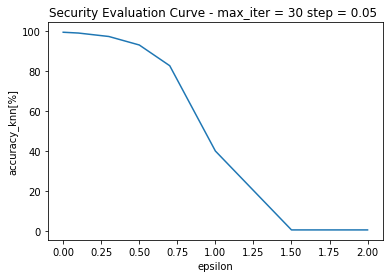

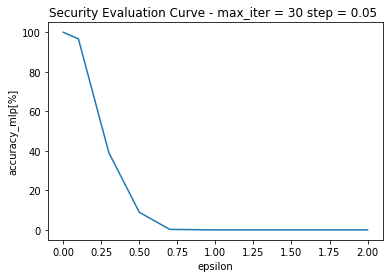

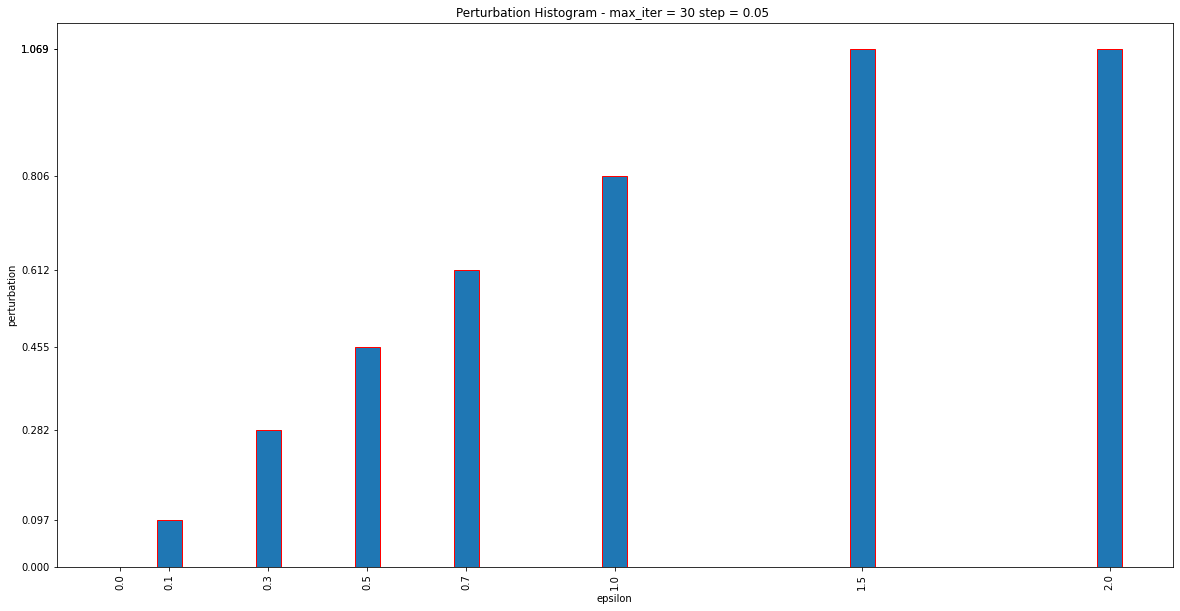

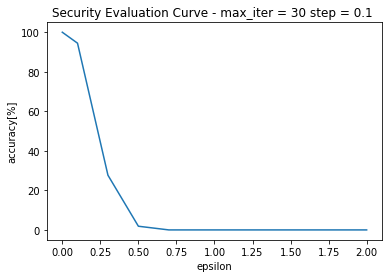

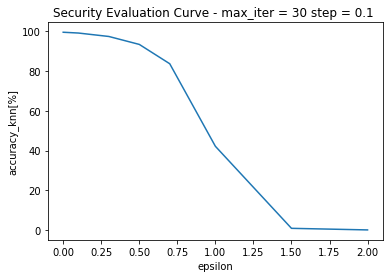

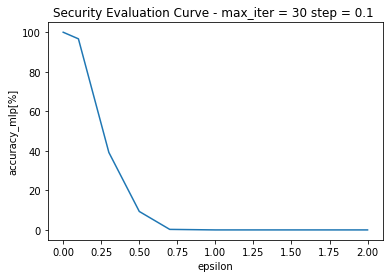

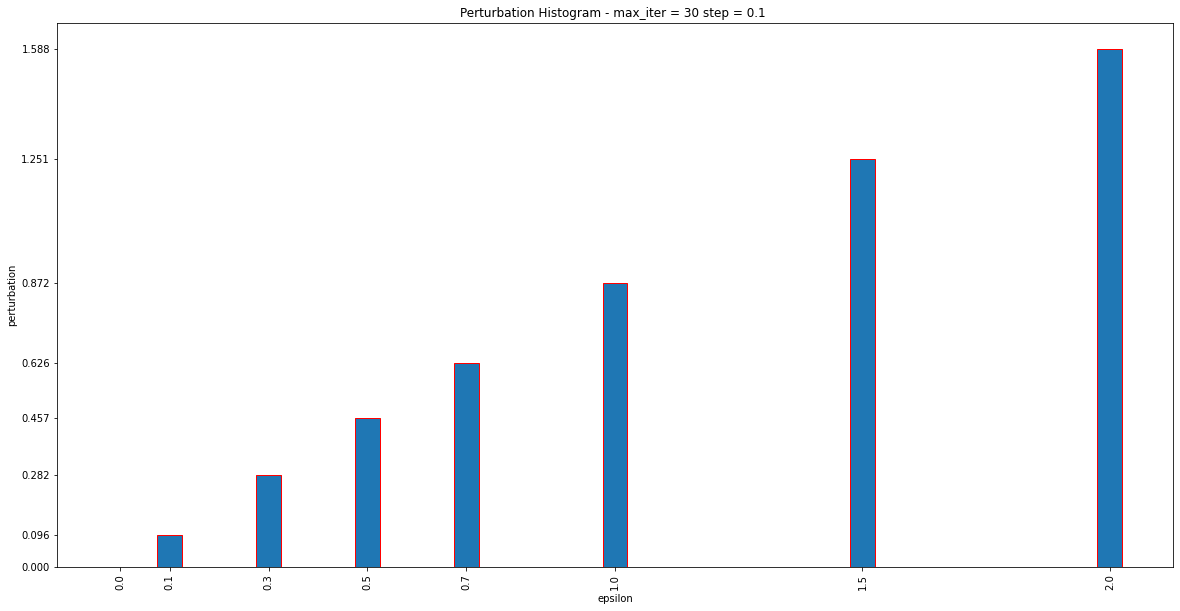

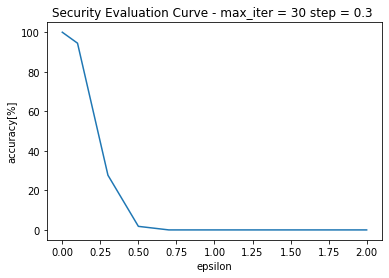

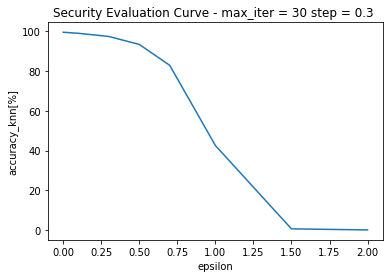

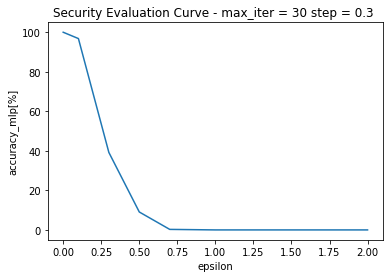

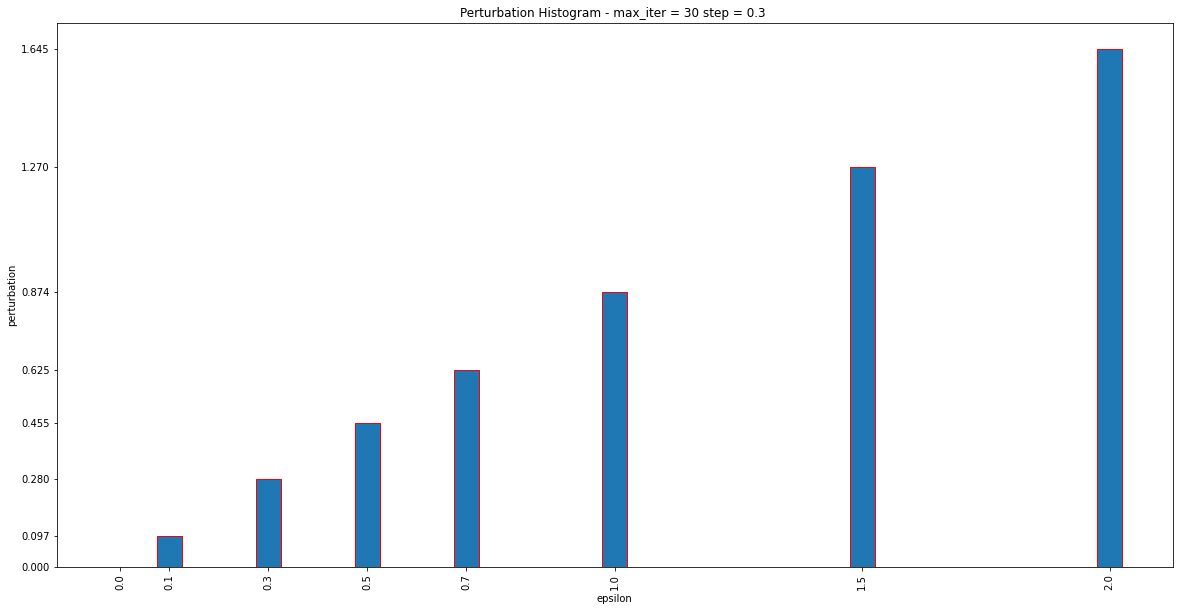

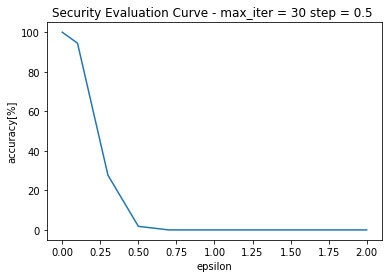

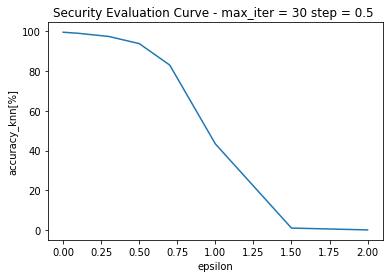

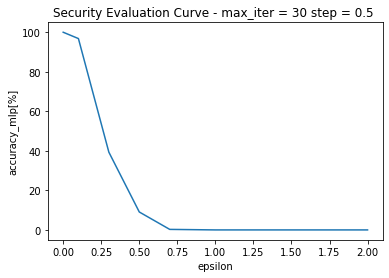

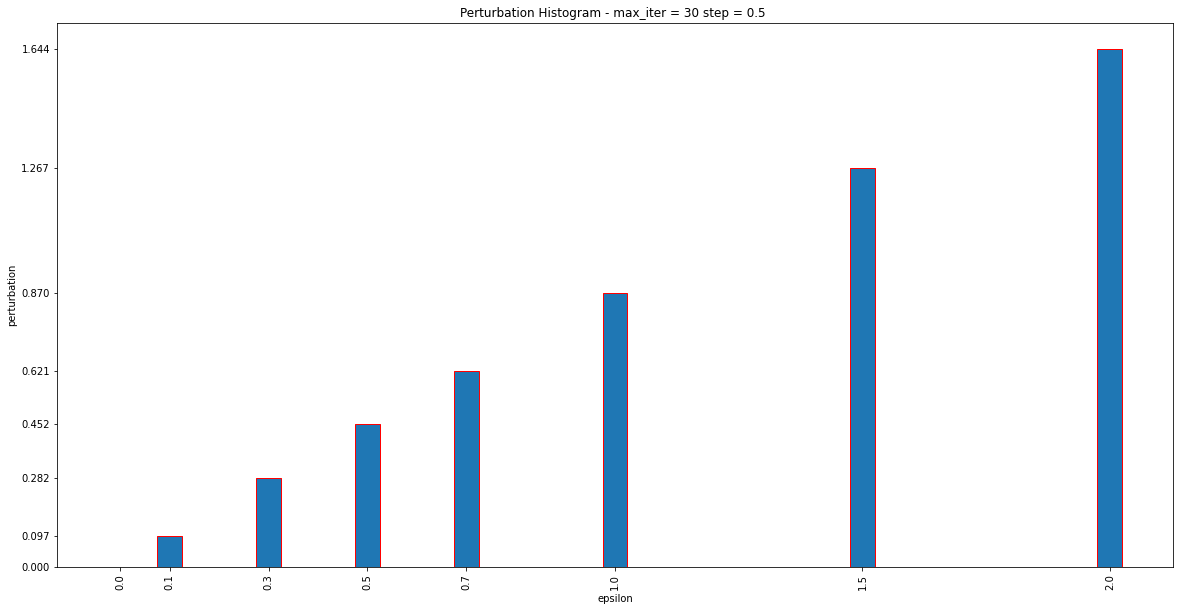

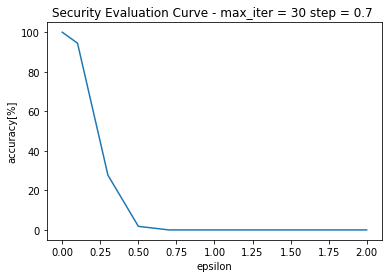

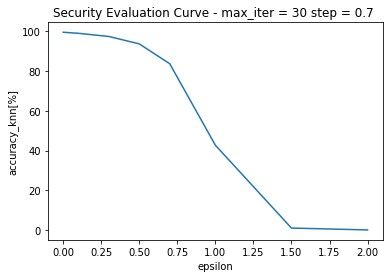

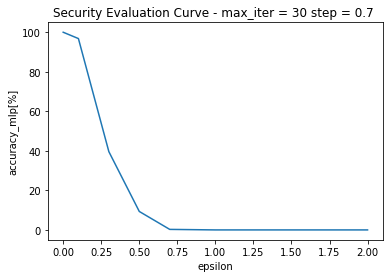

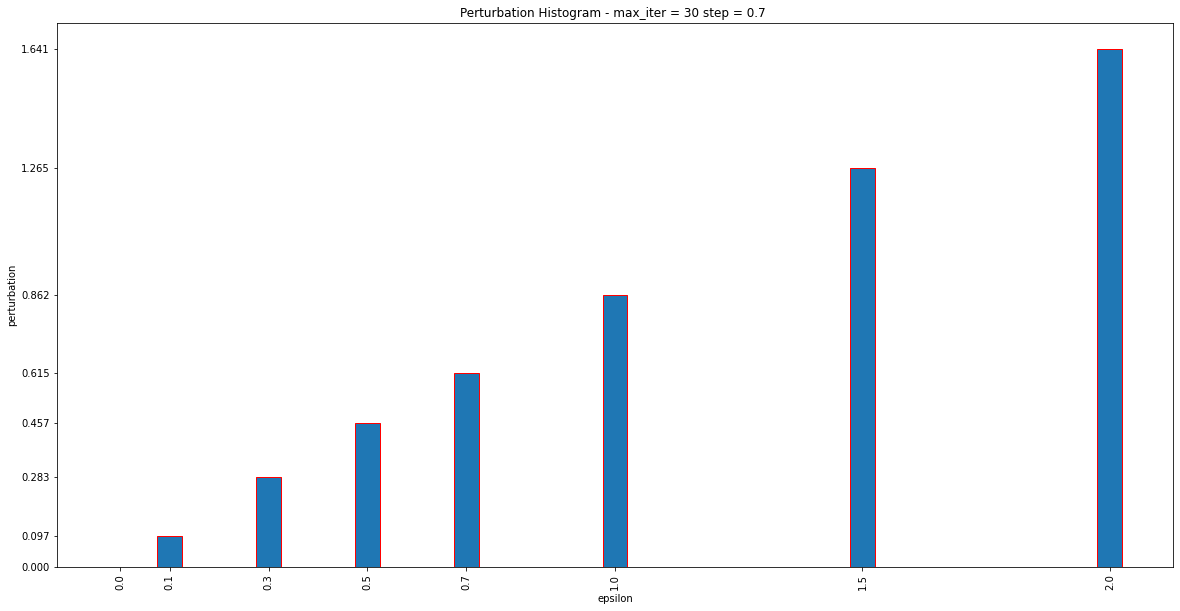

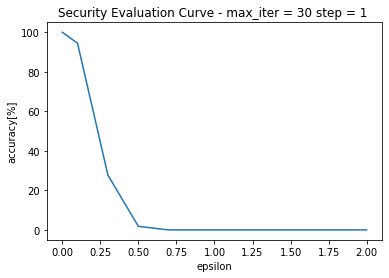

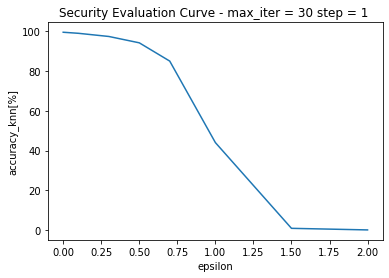

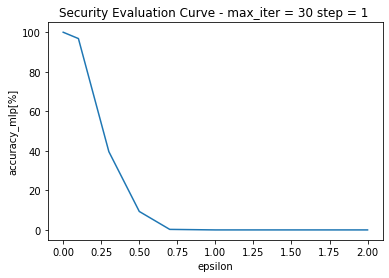

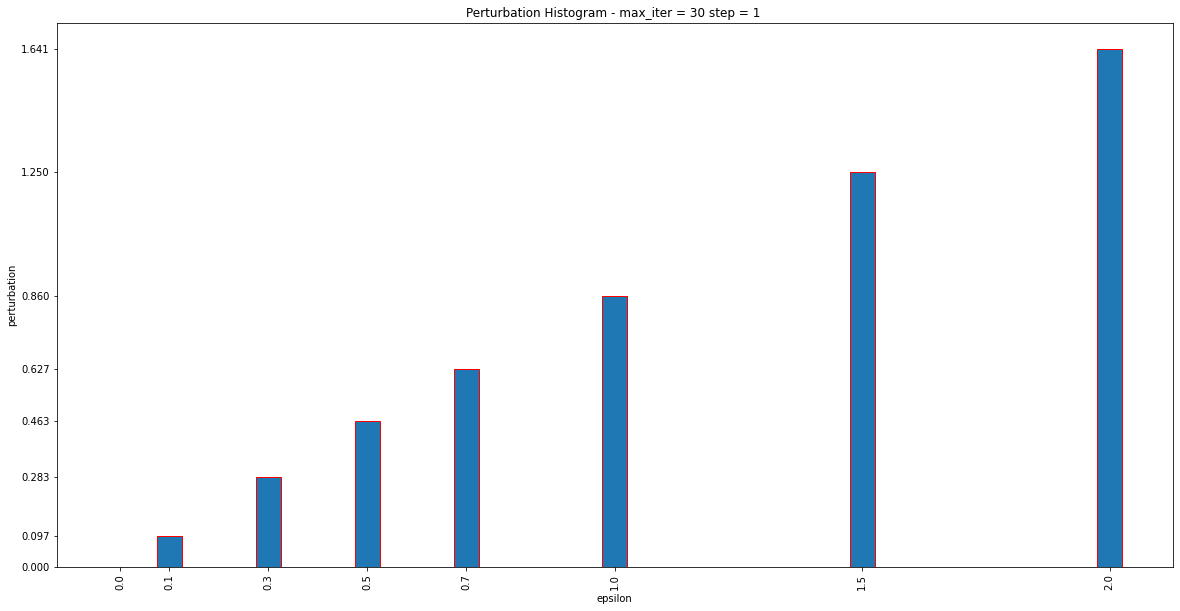

In [ ]:
result_bim_generic = {}
corrupted_bim_generic = []
max_iters = [5, 10, 20, 30]
epsilon_steps = [0.05, 0.1, 0.3, 0.5, 0.7, 1]
epsilons = [0, 0.1, 0.3, 0.5, 0.7, 1, 1.5, 2]

for iter in max_iters:
  for step in epsilon_steps:
    perturbations = []
    accuracies = []
    accuracies_knn = []
    accuracies_mlp = []
    for eps in epsilons:
      attack = BasicIterativeMethod(estimator=classifier_gb, eps=eps, eps_step=step, max_iter=iter, targeted=False, verbose=False)
      att = attack.generate(x_test)
      corrupted_bim_generic.append(att)

      perturbation = np.mean(np.abs((att - x_test)))
      loss, accuracy = mlp_wb.evaluate(att, y_test)
      accuracy_knn = knn_bb.score(att, y_test)
      accuracy_mlp = mlp_bb.score(att, y_test)

      perturbations.append(perturbation)
      accuracies.append(accuracy * 100)
      accuracies_knn.append(accuracy_knn * 100)
      accuracies_mlp.append(accuracy_mlp * 100)

      result_bim_generic[iter, step, eps] = (perturbation, accuracy * 100)

    sec_eval_curve(epsilons, accuracies, ["epsilon", "accuracy[%]"], {"max_iter": iter, "step": step})
    sec_eval_curve(epsilons, accuracies_knn, ["epsilon", "accuracy_knn[%]"], {"max_iter": iter, "step": step})
    sec_eval_curve(epsilons, accuracies_mlp, ["epsilon", "accuracy_mlp[%]"], {"max_iter": iter, "step": step})
    perturbation_histogram(epsilons, perturbations, ["epsilon", "perturbation"], {"max_iter": iter, "step": step})
    print("\n")

os.makedirs(prec_attacks, exist_ok=True)
with open(os.path.join(prec_attacks, 'result_bim_generic.pkl'), 'wb') as f:
  pickle.dump(result_bim_generic, f)
with open(os.path.join(prec_attacks, 'corrupted_bim_generic.pkl'), 'wb') as f:
  pickle.dump(corrupted_bim_generic, f)

##### Load

In [ ]:
with open(os.path.join(prec_attacks, 'result_bim_generic.pkl'), 'rb') as f:
  result_bim_generic = pickle.load(f)
with open(os.path.join(prec_attacks, 'corrupted_bim_generic.pkl'), 'rb') as f:
  corrupted_bim_generic = pickle.load(f)

### PGD

##### Creation and Save `skippable`

In [ ]:
result_pgd_generic = {}
corrupted_pgd_generic = []
num_random_init = [1, 5, 10]
max_iters = [5, 10, 20]
epsilon_steps = [0.1, 0.3, 0.5, 1]
epsilons = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1, 1.5, 2]

for rnd in num_random_init:
  for iter in max_iters:
    for step in epsilon_steps:
      perturbations = []
      accuracies = []
      accuracies_knn = []
      accuracies_mlp = []
      for eps in epsilons:
        attack = ProjectedGradientDescent(estimator=classifier_gb, eps=eps, eps_step=step, max_iter=iter, num_random_init = rnd, targeted=False, verbose=False)
        att = attack.generate(x_test)
        corrupted_pgd_generic.append(att)

        perturbation = np.mean(np.abs((att - x_test)))
        loss, accuracy = mlp_wb.evaluate(att, y_test)
        accuracy_knn = knn_bb.score(att, y_test)
        accuracy_mlp = mlp_bb.score(att, y_test)

        perturbations.append(perturbation)
        accuracies.append(accuracy * 100)
        accuracies_knn.append(accuracy_knn * 100)
        accuracies_mlp.append(accuracy_mlp * 100)

        result_pgd_generic[rnd, iter, step, eps] = (perturbation, accuracy * 100)

      sec_eval_curve(epsilons, accuracies, ["epsilon", "accuracy[%]"], {"random_init": rnd, "max_iter": iter, "step": step})
      sec_eval_curve(epsilons, accuracies_knn, ["epsilon", "accuracy_knn[%]"], {"random_init": rnd, "max_iter": iter, "step": step})
      sec_eval_curve(epsilons, accuracies_mlp, ["epsilon", "accuracy_mlp[%]"], {"random_init": rnd, "max_iter": iter, "step": step})
      perturbation_histogram(epsilons, perturbations, ["epsilon", "perturbation"], {"random_init": rnd, "max_iter": iter, "step": step})
      print("\n")

os.makedirs(prec_attacks, exist_ok=True)
with open(os.path.join(prec_attacks, 'result_pgd_generic.pkl'), 'wb') as f:
  pickle.dump(result_pgd_generic, f)
with open(os.path.join(prec_attacks, 'corrupted_pgd_generic.pkl'), 'wb') as f:
  pickle.dump(corrupted_pgd_generic, f)

Output hidden; open in https://colab.research.google.com to view.

##### Load

In [ ]:
with open(os.path.join(prec_attacks, 'result_pgd_generic.pkl'), 'rb') as f:
  result_pgd_generic = pickle.load(f)
with open(os.path.join(prec_attacks, 'corrupted_pgd_generic.pkl'), 'rb') as f:
  corrupted_pgd_generic = pickle.load(f)

### DEEPFOOL

##### Creation and Save `skippable`

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


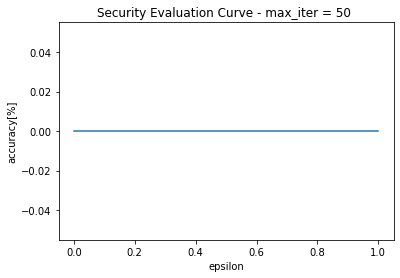

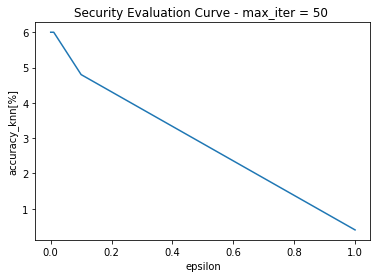

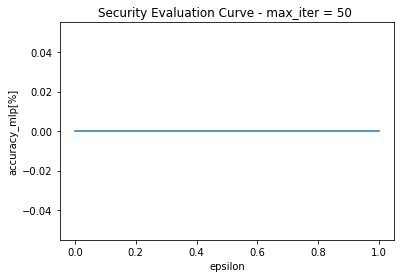

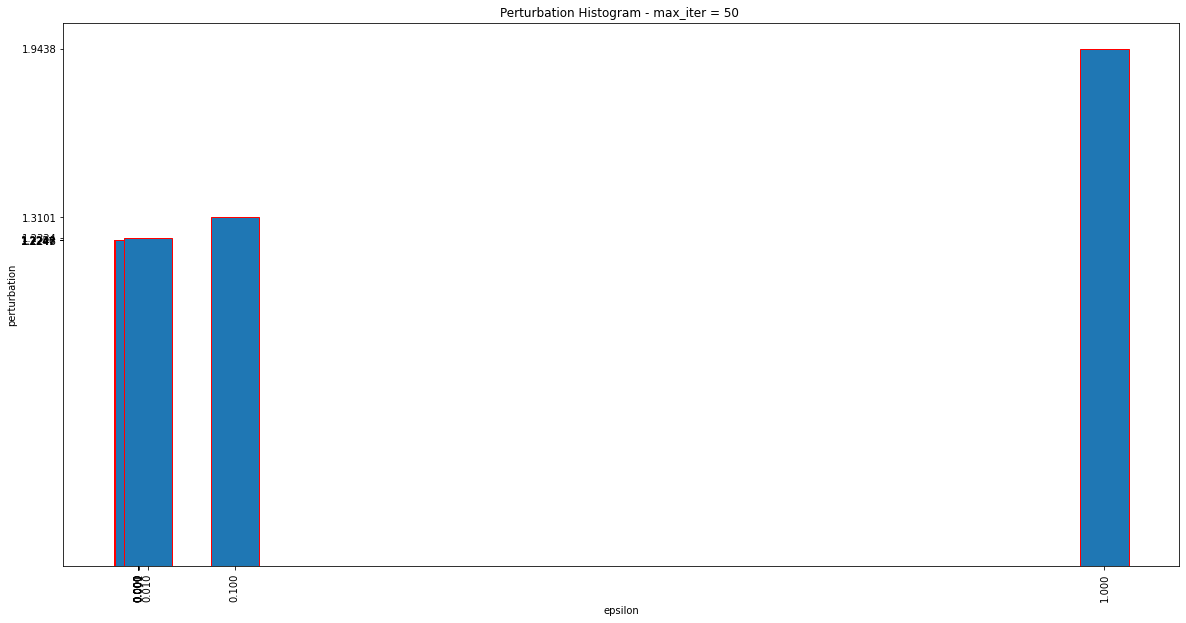

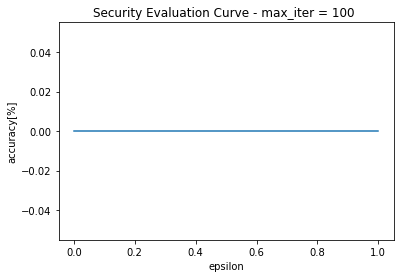

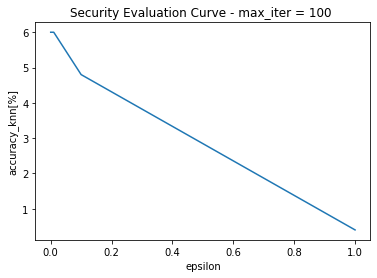

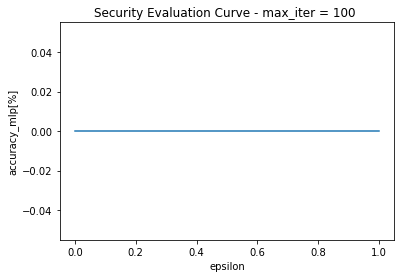

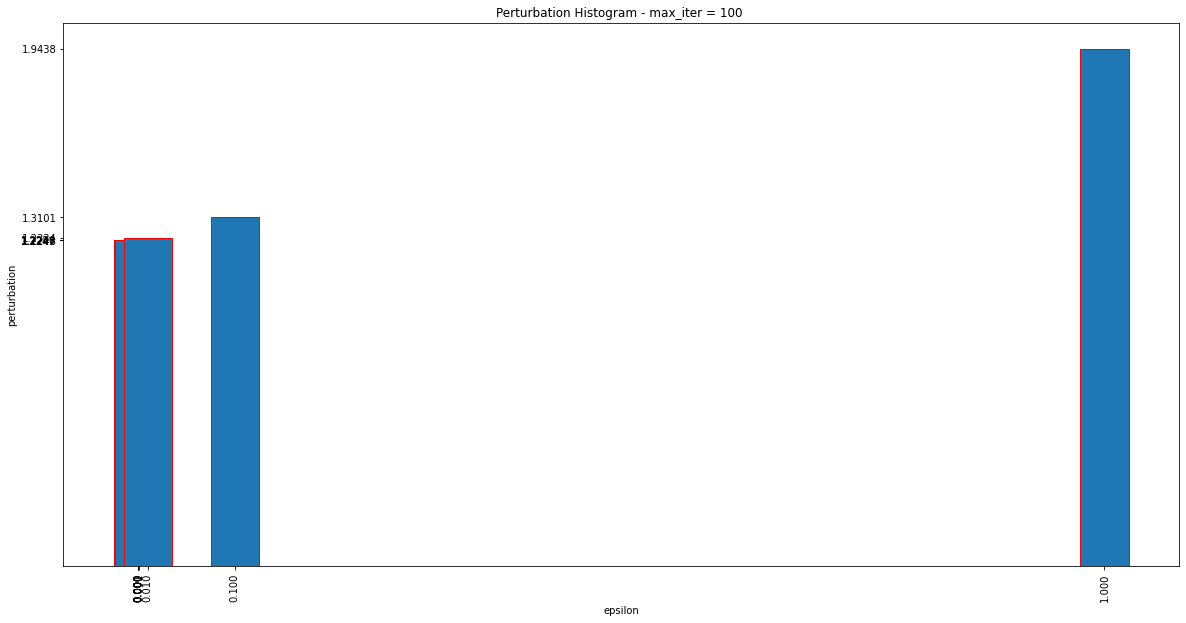

In [ ]:
result_deep_generic = {}
corrupted_deep_generic = []
max_iters = [50, 100]
epsilons = [0, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]

for iter in max_iters:
  perturbations = []
  accuracies = []
  accuracies_knn = []
  accuracies_mlp = []
  for eps in epsilons:
    attack = DeepFool(classifier=classifier_dcw, epsilon=eps, max_iter=iter, verbose=False)
    att = attack.generate(x_test)
    corrupted_deep_generic.append(att)

    perturbation = np.mean(np.abs((att - x_test)))
    loss, accuracy = mlp_wb.evaluate(att, y_test)
    accuracy_knn = knn_bb.score(att, y_test)
    accuracy_mlp = mlp_bb.score(att, y_test)

    perturbations.append(perturbation)
    accuracies.append(accuracy * 100)
    accuracies_knn.append(accuracy_knn * 100)
    accuracies_mlp.append(accuracy_mlp * 100)

    result_deep_generic[iter, eps] = (perturbation, accuracy * 100)

  sec_eval_curve(epsilons, accuracies, ["epsilon", "accuracy[%]"], {"max_iter": iter})
  sec_eval_curve(epsilons, accuracies_knn, ["epsilon", "accuracy_knn[%]"], {"max_iter": iter})
  sec_eval_curve(epsilons, accuracies_mlp, ["epsilon", "accuracy_mlp[%]"], {"max_iter": iter})
  perturbation_histogram(epsilons, perturbations, ["epsilon", "perturbation"], {"max_iter": iter})
  print("\n")

os.makedirs(prec_attacks, exist_ok=True)
with open(os.path.join(prec_attacks, 'result_deep_generic.pkl'), 'wb') as f:
  pickle.dump(result_deep_generic, f)
with open(os.path.join(prec_attacks, 'corrupted_deep_generic.pkl'), 'wb') as f:
  pickle.dump(corrupted_deep_generic, f)

##### Load

In [ ]:
with open(os.path.join(prec_attacks, 'result_deep_generic.pkl'), 'rb') as f:
  result_deep_generic = pickle.load(f)
with open(os.path.join(prec_attacks, 'corrupted_deep_generic.pkl'), 'rb') as f:
  corrupted_deep_generic = pickle.load(f)

### CARLINI-WAGNER

##### Creation and Save `skippable`

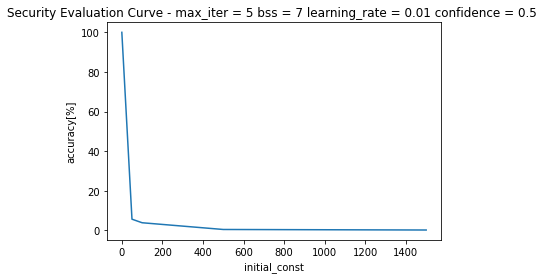

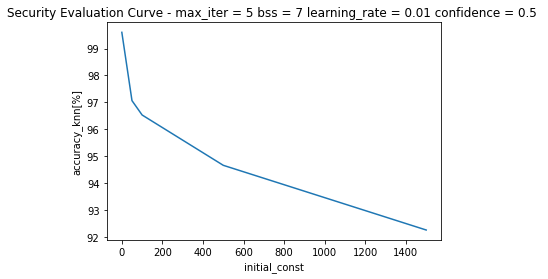

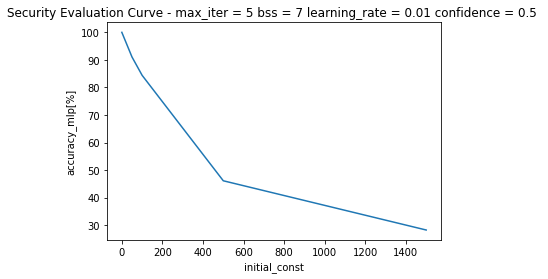

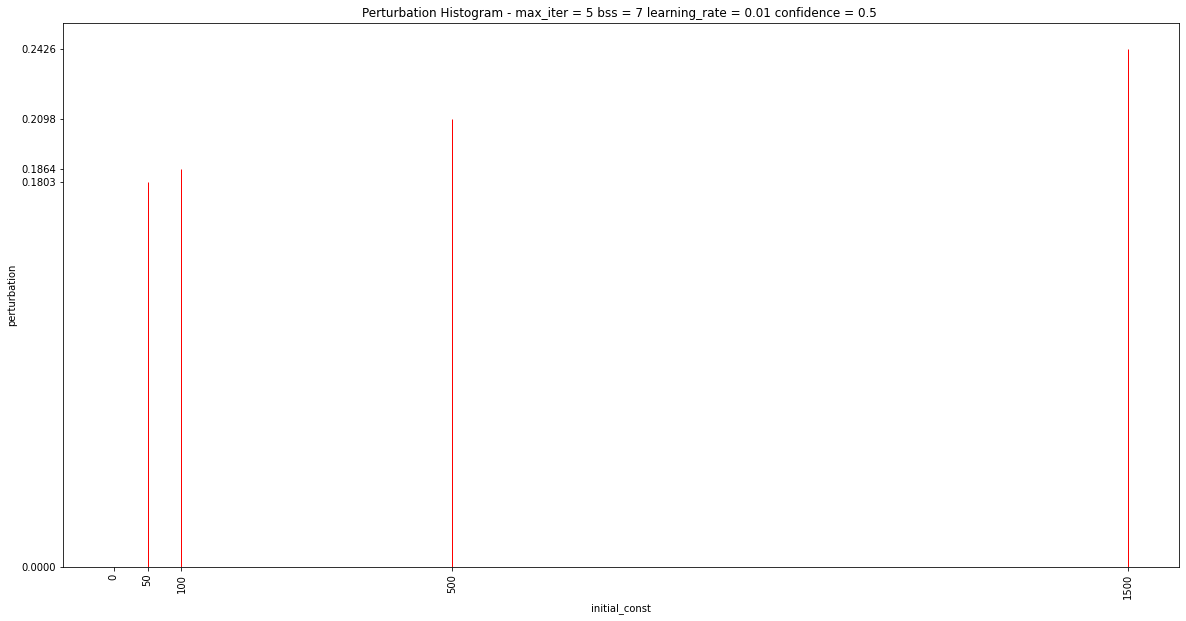

In [ ]:
result_cw_generic = {}
corrupted_cw_generic = []
initial_consts = [0, 50, 100, 500, 1500]
binary_search_steps = 7
max_iter = 5
confidence = 0.5
learning_rate = 0.01

perturbations = []
accuracies = []
accuracies_knn = []
accuracies_mlp = []

for ic in initial_consts:
  attack = CarliniL2Method(classifier=classifier_dcw, binary_search_steps=binary_search_steps, confidence=confidence, max_iter=max_iter, learning_rate=learning_rate, initial_const=ic, targeted=False, verbose=False)
  att = attack.generate(x_test)
  corrupted_cw_generic.append(att)

  perturbation = np.mean(np.abs((att - x_test)))
  loss, accuracy = mlp_wb.evaluate(att, y_test)
  accuracy_knn = knn_bb.score(att, y_test)
  accuracy_mlp = mlp_bb.score(att, y_test)

  perturbations.append(perturbation)
  accuracies.append(accuracy * 100)
  accuracies_knn.append(accuracy_knn * 100)
  accuracies_mlp.append(accuracy_mlp * 100)

  result_cw_generic[max_iter, binary_search_steps, learning_rate, ic] = (perturbation, accuracy * 100)

sec_eval_curve(initial_consts, accuracies, ["initial_const", "accuracy[%]"], {"max_iter": max_iter, "bss": binary_search_steps, "learning_rate": learning_rate, "confidence": confidence})
sec_eval_curve(initial_consts, accuracies_knn, ["initial_const", "accuracy_knn[%]"], {"max_iter": max_iter, "bss": binary_search_steps, "learning_rate": learning_rate, "confidence": confidence})
sec_eval_curve(initial_consts, accuracies_mlp, ["initial_const", "accuracy_mlp[%]"], {"max_iter": max_iter, "bss": binary_search_steps, "learning_rate": learning_rate, "confidence": confidence})
perturbation_histogram(initial_consts, perturbations, ["initial_const", "perturbation"], {"max_iter": max_iter, "bss": binary_search_steps, "learning_rate": learning_rate, "confidence": confidence})

os.makedirs(prec_attacks, exist_ok=True)
with open(os.path.join(prec_attacks, 'result_cw_generic.pkl'), 'wb') as f:
  pickle.dump(result_cw_generic, f)
with open(os.path.join(prec_attacks, 'corrupted_cw_generic.pkl'), 'wb') as f:
  pickle.dump(corrupted_cw_generic, f)

##### Load

In [ ]:
with open(os.path.join(prec_attacks, 'result_cw_generic.pkl'), 'rb') as f:
  result_cw_generic = pickle.load(f)
with open(os.path.join(prec_attacks, 'corrupted_cw_generic.pkl'), 'rb') as f:
  corrupted_cw_generic = pickle.load(f)

## Specific

### FGSM

##### Creation and Save `skippable`

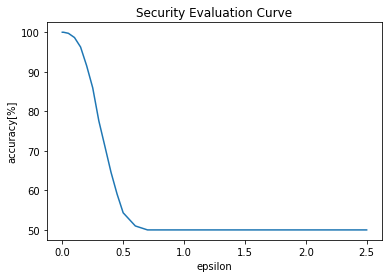

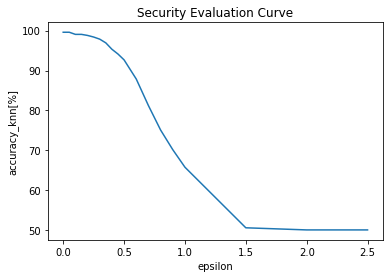

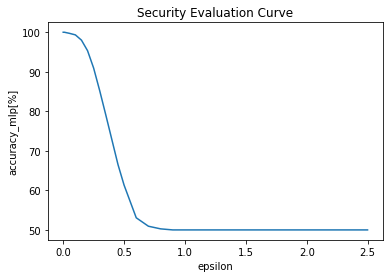

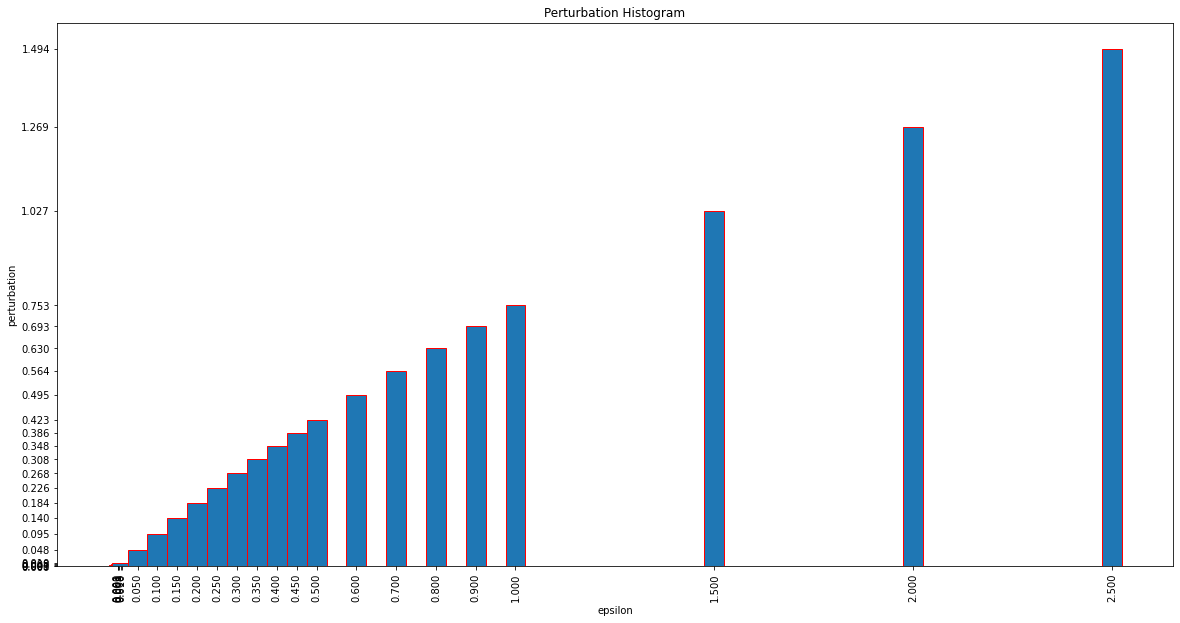

In [ ]:
result_fgsm_specific = {}
corrupted_fgsm_specific = []
target_class = [0, 1]
epsilons = [0, 0.001, 0.003, 0.008, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2, 2.5]

perturbations = []
accuracies = []
accuracies_knn = []
accuracies_mlp = []

for eps in epsilons:
  attack = FastGradientMethod(estimator=classifier_gb, eps=eps, targeted=True)
  one_hot_targeted_labels = target_class * np.ones(y_test.shape)
  att = attack.generate(x_test, one_hot_targeted_labels)
  corrupted_fgsm_specific.append(att)

  perturbation = np.mean(np.abs((att - x_test)))
  loss, accuracy = mlp_wb.evaluate(att, y_test)
  accuracy_knn = knn_bb.score(att, y_test)
  accuracy_mlp = mlp_bb.score(att, y_test)

  perturbations.append(perturbation)
  accuracies.append(accuracy * 100)
  accuracies_knn.append(accuracy_knn * 100)
  accuracies_mlp.append(accuracy_mlp * 100)

  result_fgsm_specific[eps] = (perturbation, accuracy * 100)

sec_eval_curve(epsilons, accuracies, ["epsilon", "accuracy[%]"])
sec_eval_curve(epsilons, accuracies_knn, ["epsilon", "accuracy_knn[%]"])
sec_eval_curve(epsilons, accuracies_mlp, ["epsilon", "accuracy_mlp[%]"])
perturbation_histogram(epsilons, perturbations, ["epsilon", "perturbation"])

os.makedirs(prec_attacks, exist_ok=True)
with open(os.path.join(prec_attacks, 'result_fgsm_specific.pkl'), 'wb') as f:
  pickle.dump(result_fgsm_specific, f)
with open(os.path.join(prec_attacks, 'corrupted_fgsm_specific.pkl'), 'wb') as f:
  pickle.dump(corrupted_fgsm_specific, f)

##### Load

In [ ]:
with open(os.path.join(prec_attacks, 'result_fgsm_specific.pkl'), 'rb') as f:
  result_fgsm_specific = pickle.load(f)
with open(os.path.join(prec_attacks, 'corrupted_fgsm_specific.pkl'), 'rb') as f:
  corrupted_fgsm_specific = pickle.load(f)

### BIM

##### Creation and Save `skippable`

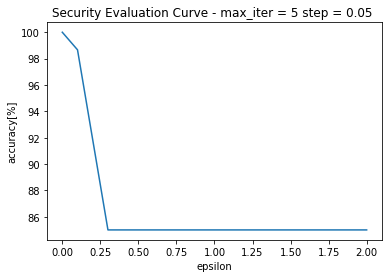

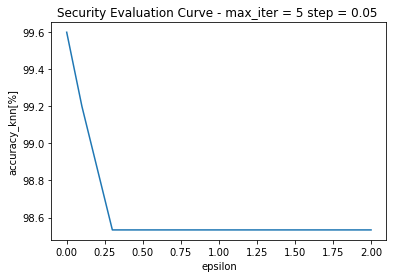

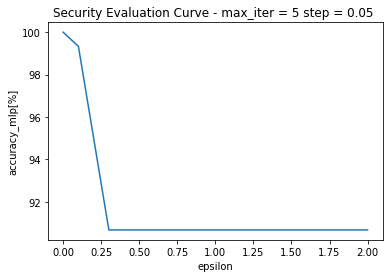

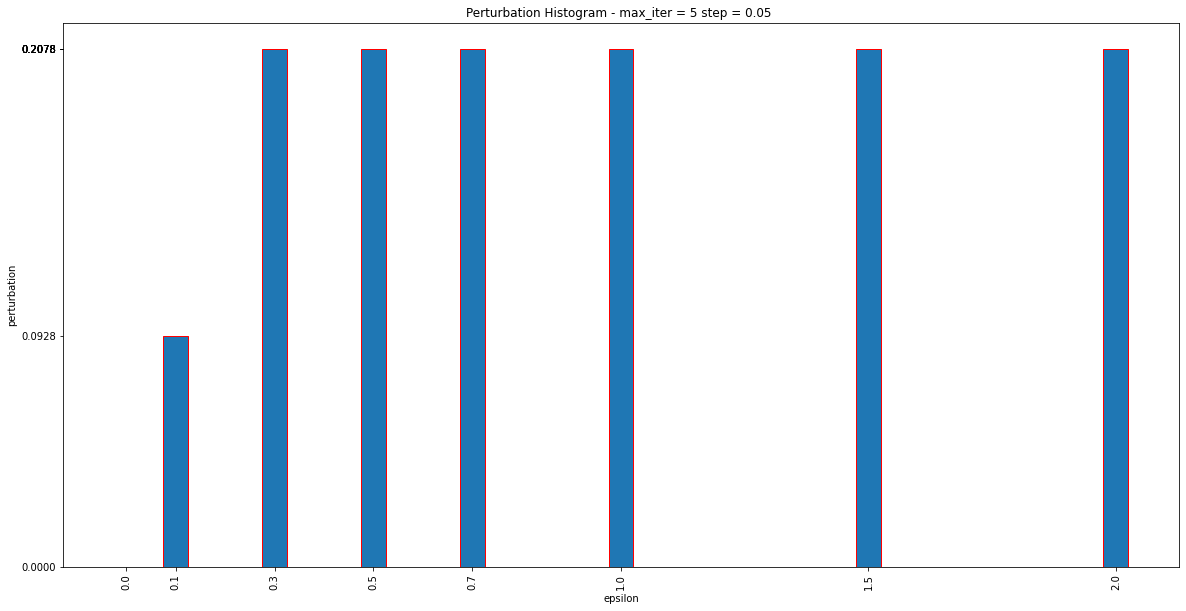

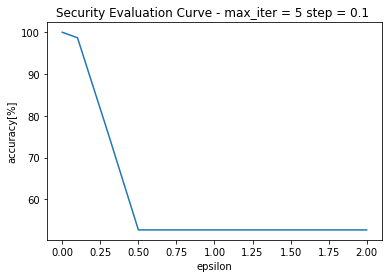

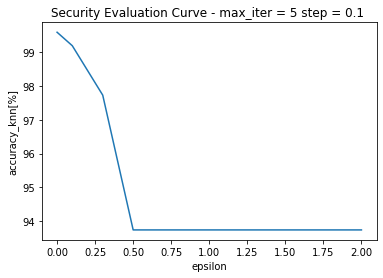

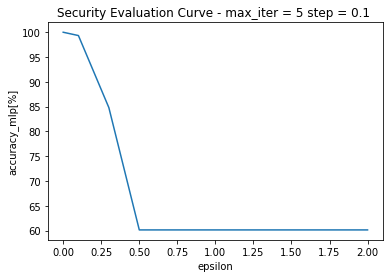

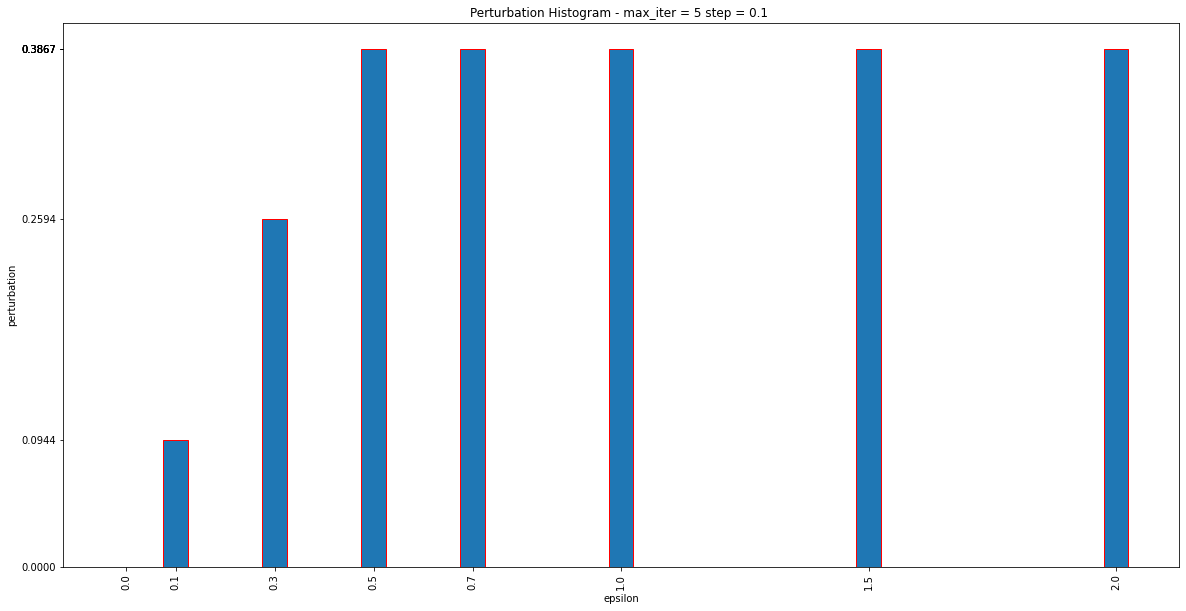

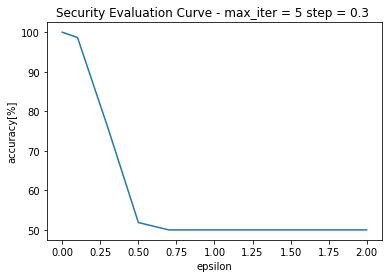

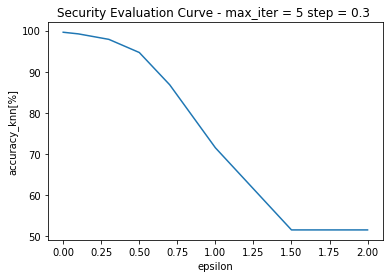

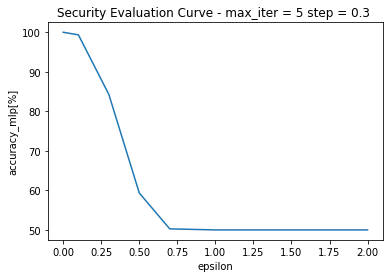

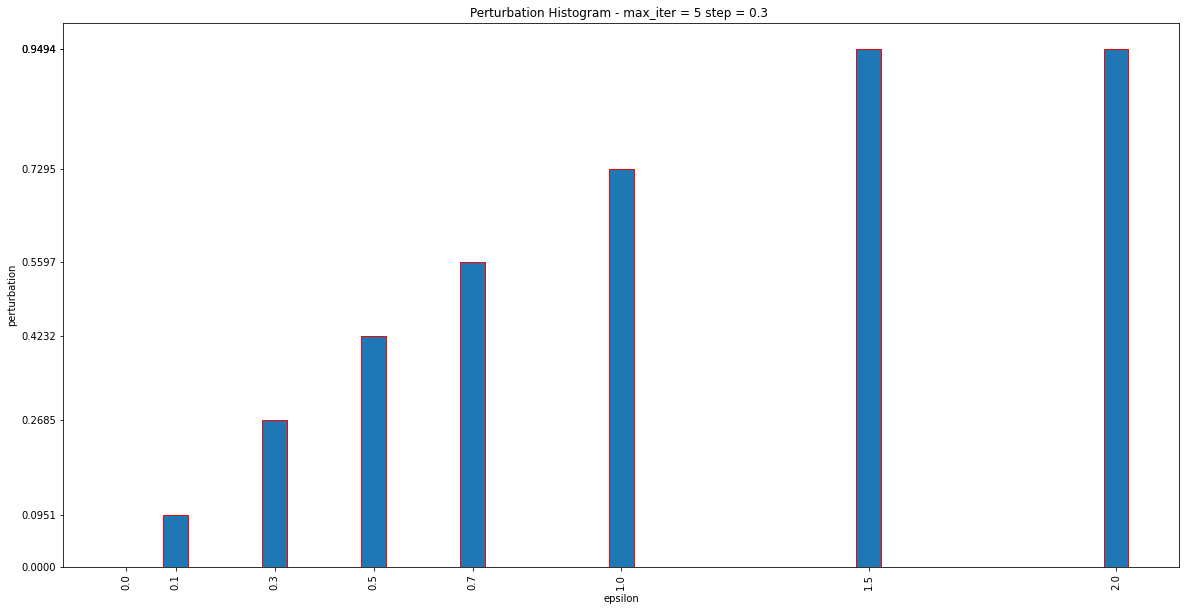

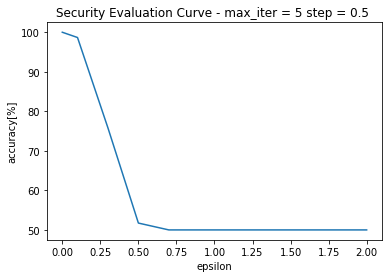

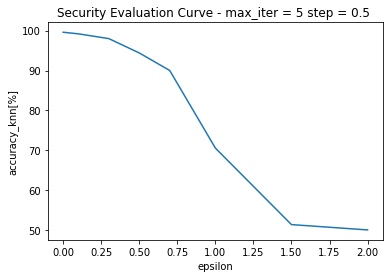

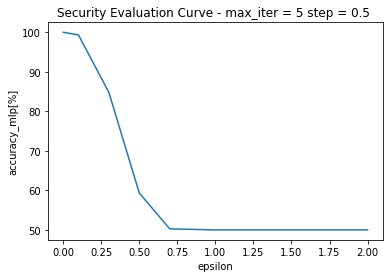

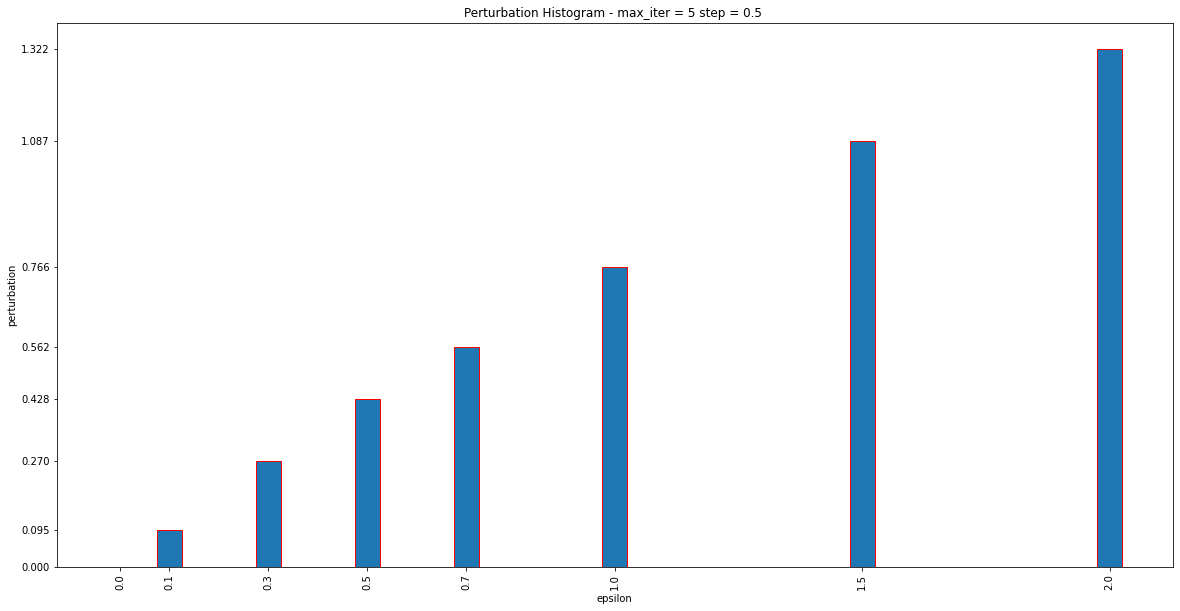

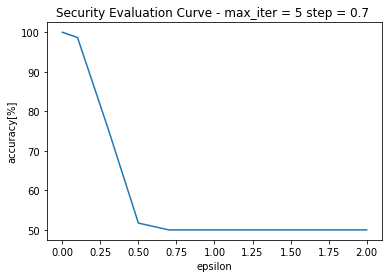

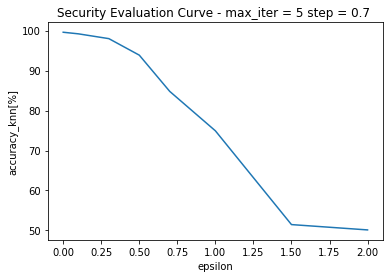

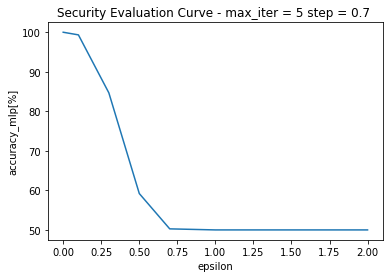

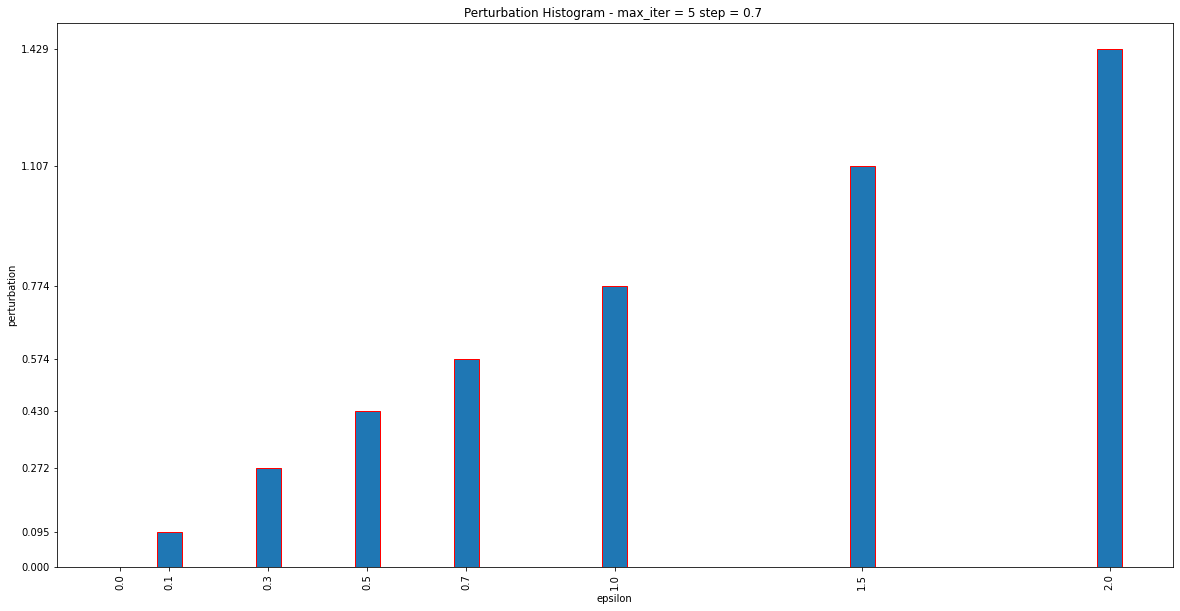

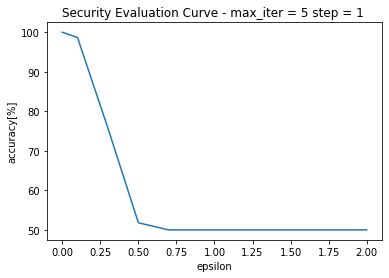

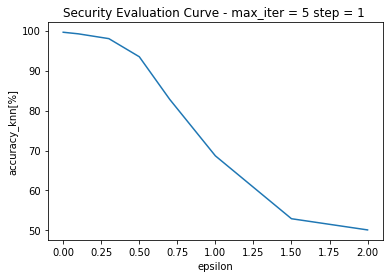

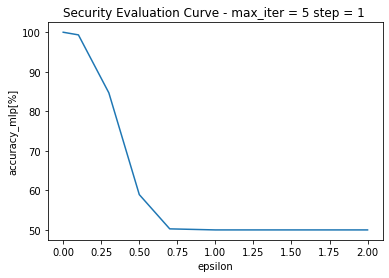

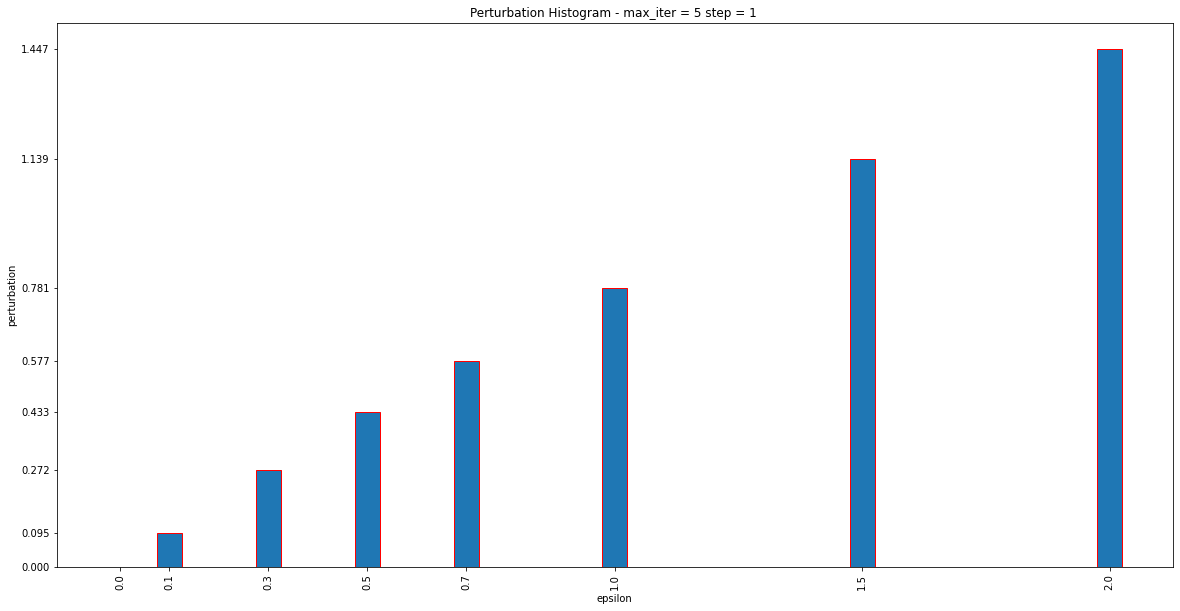

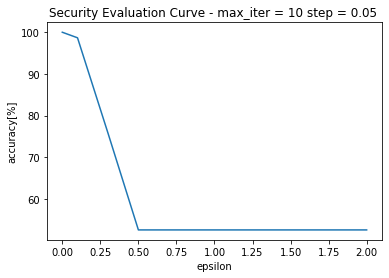

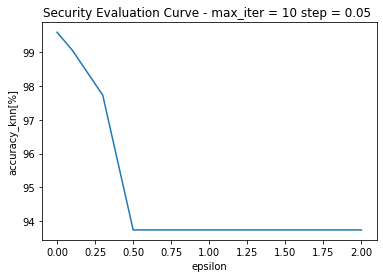

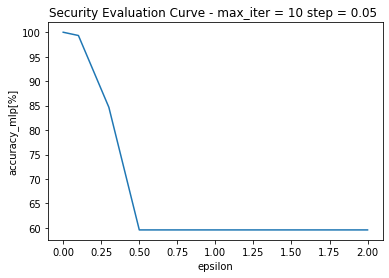

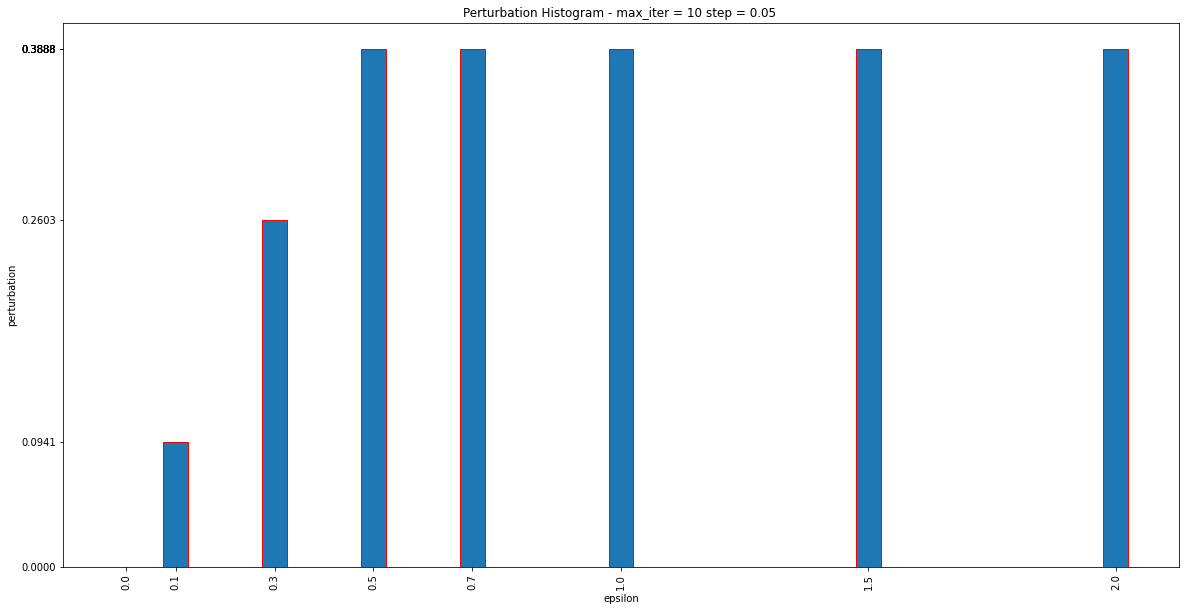

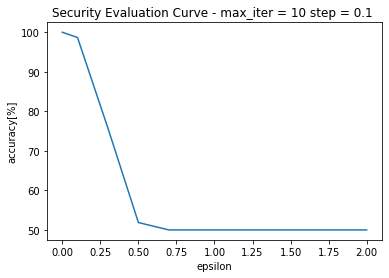

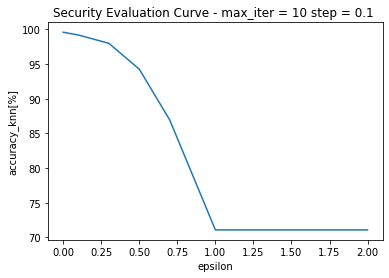

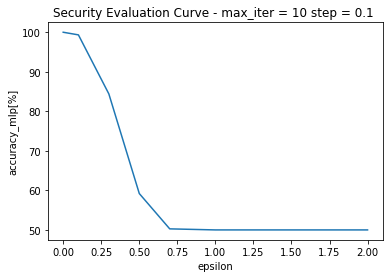

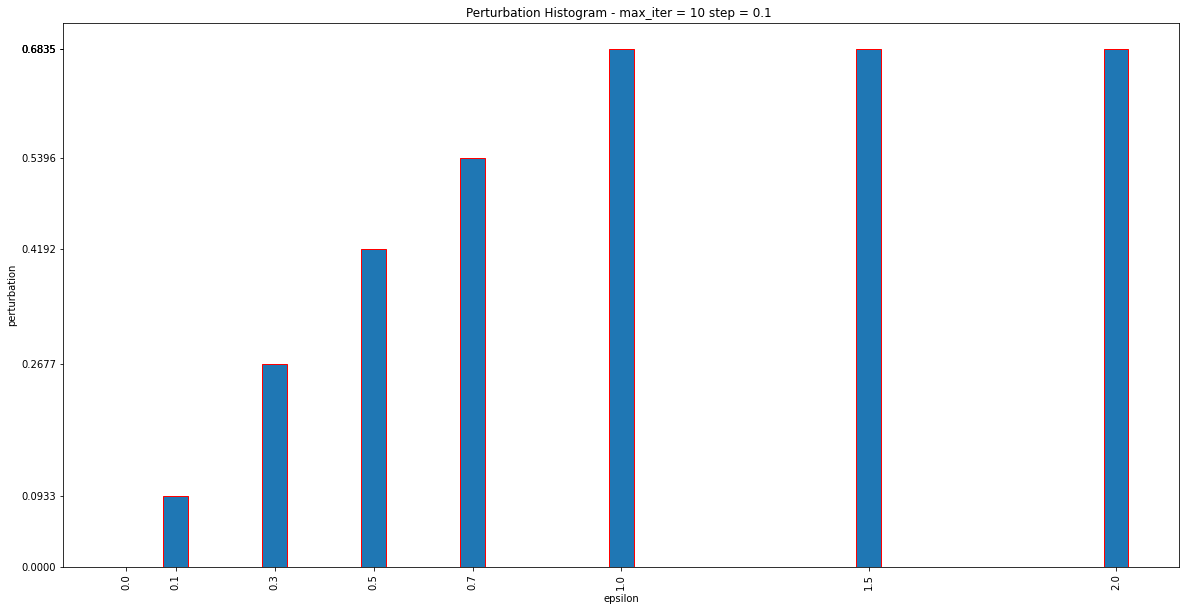

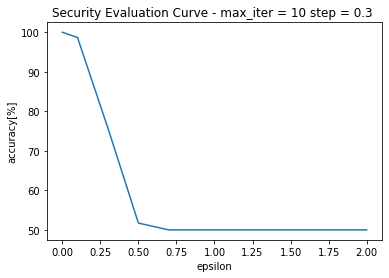

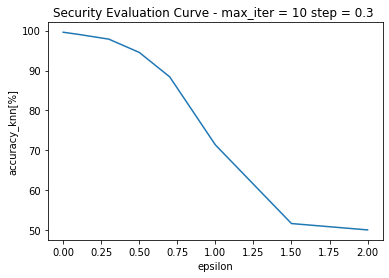

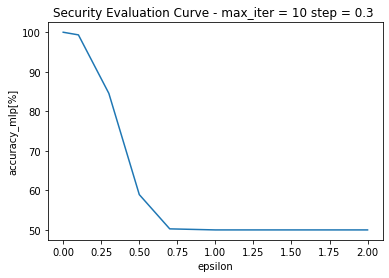

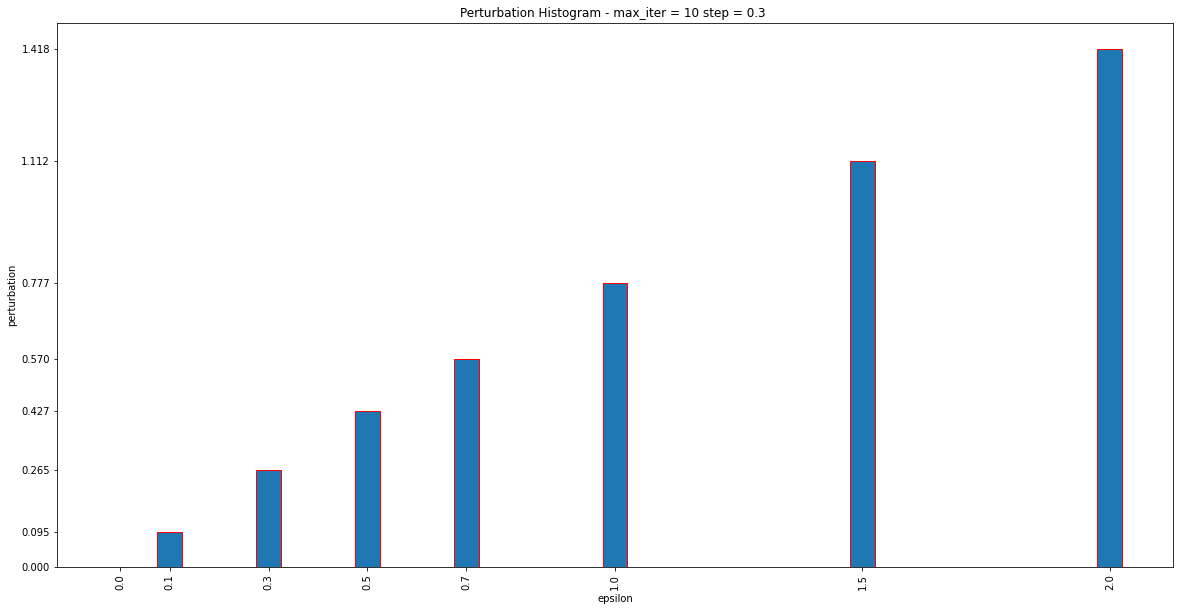

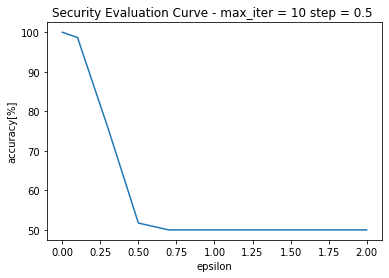

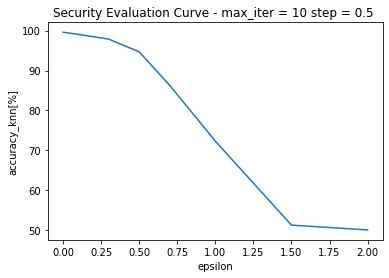

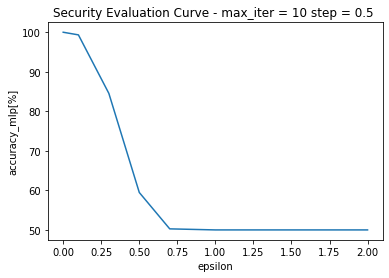

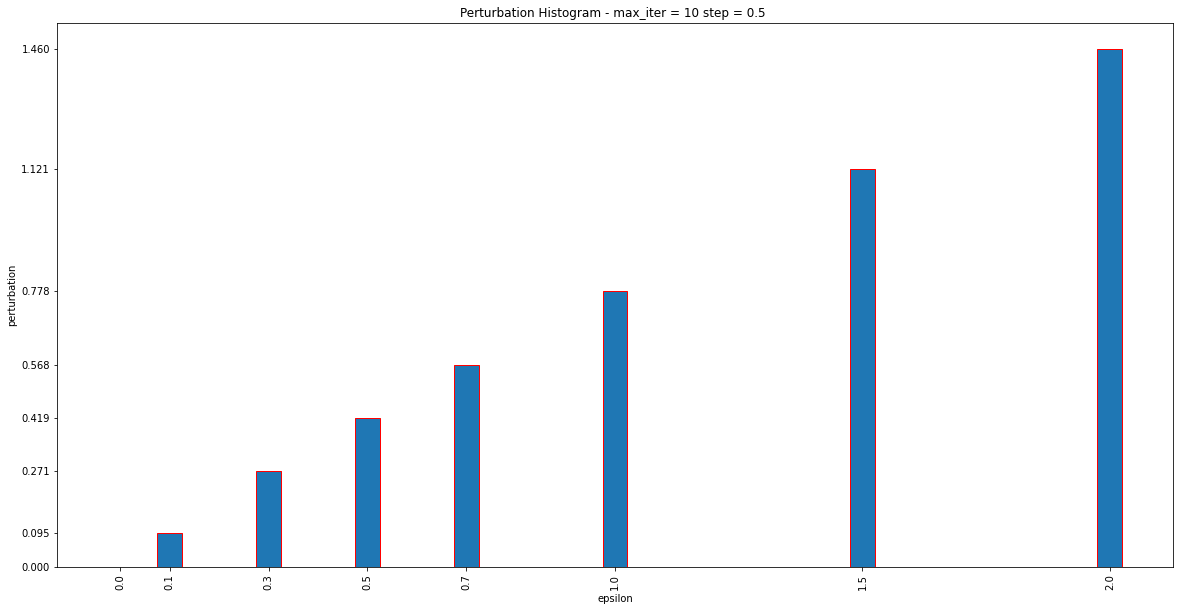

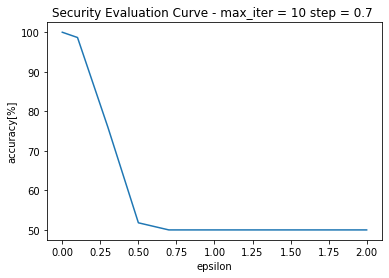

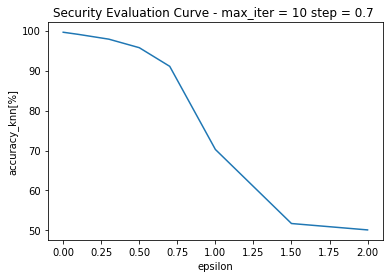

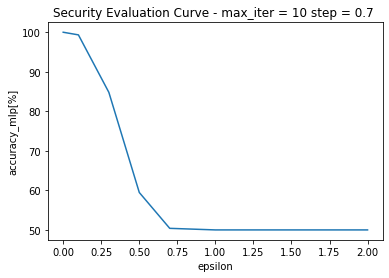

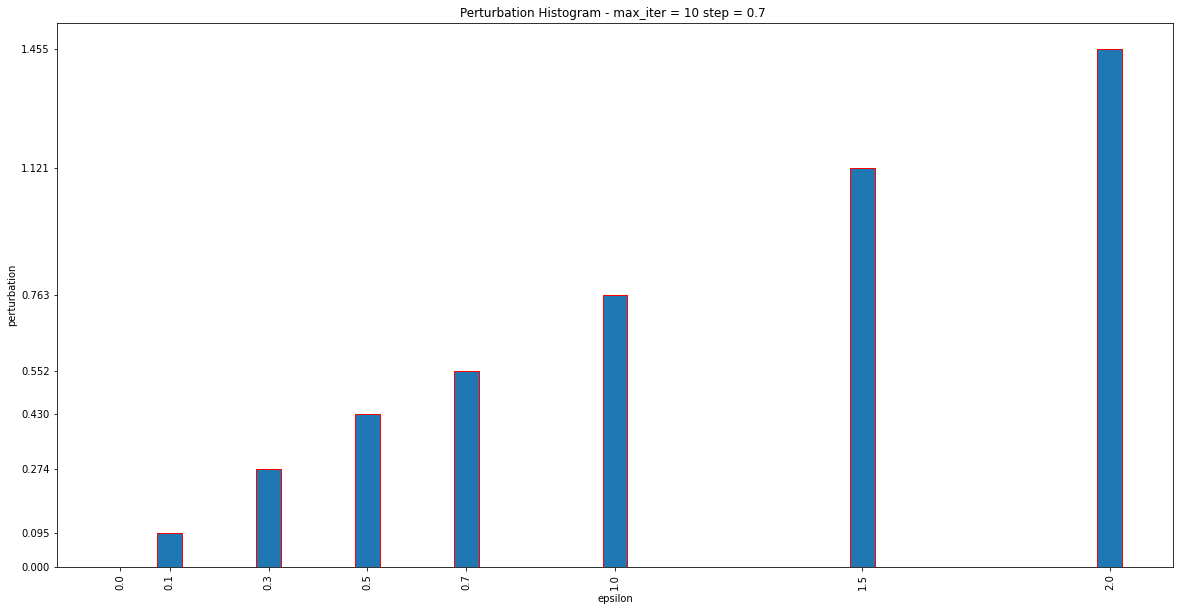

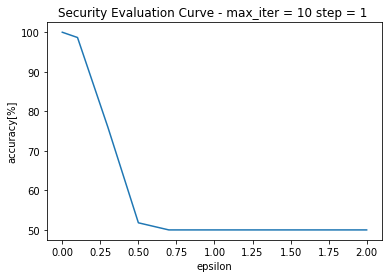

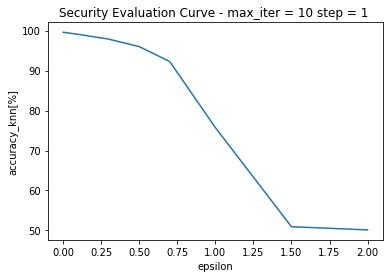

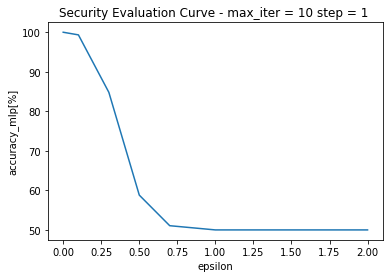

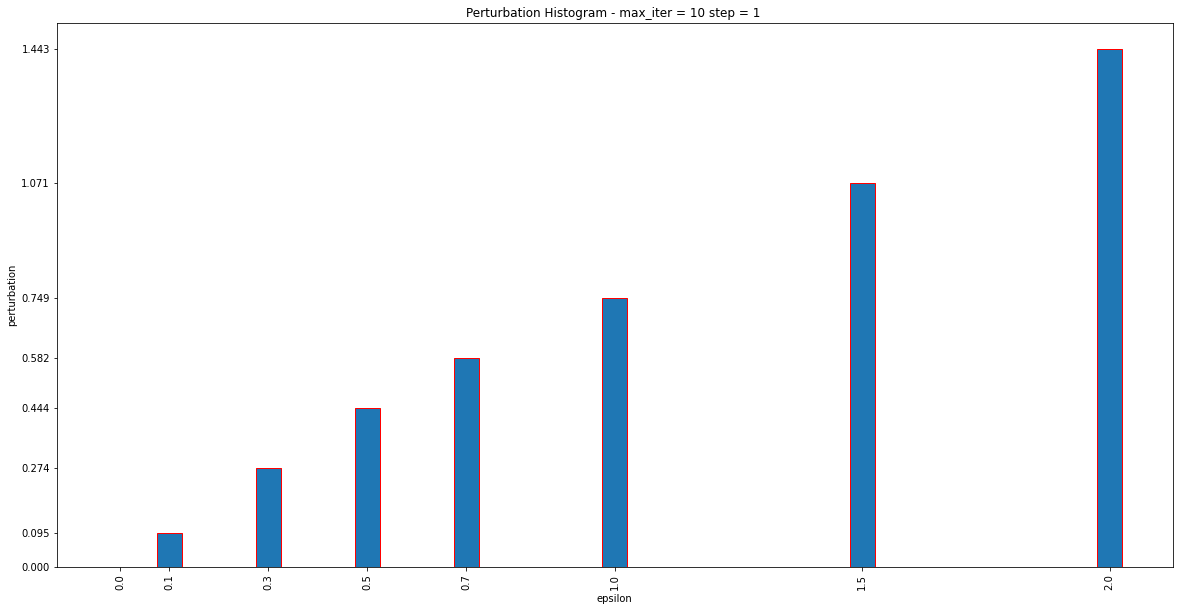

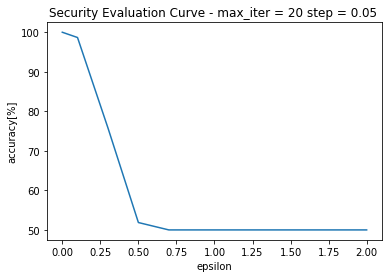

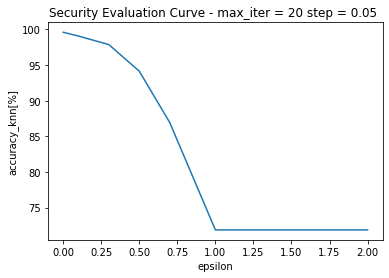

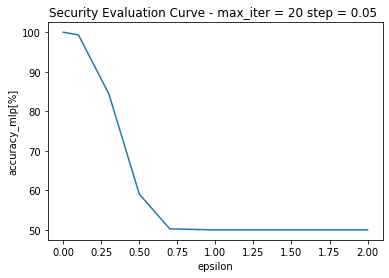

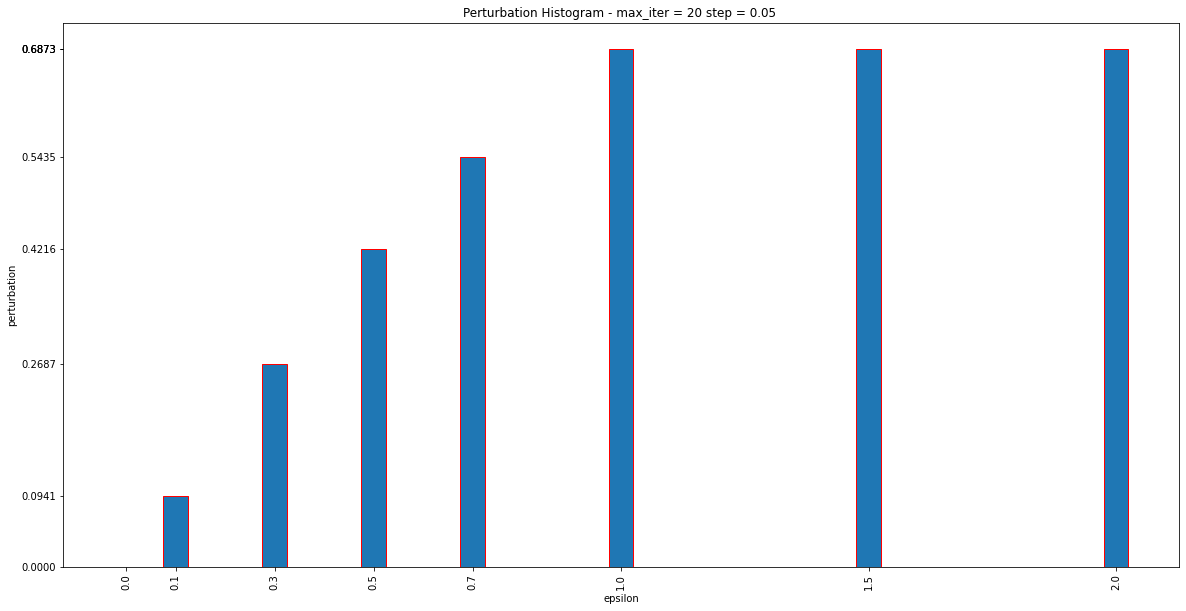

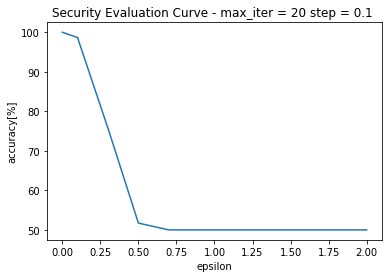

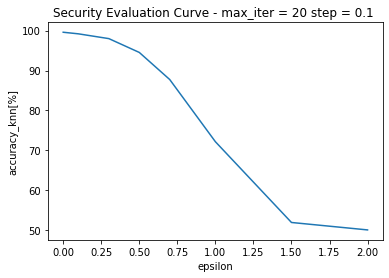

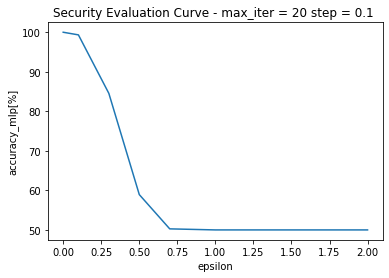

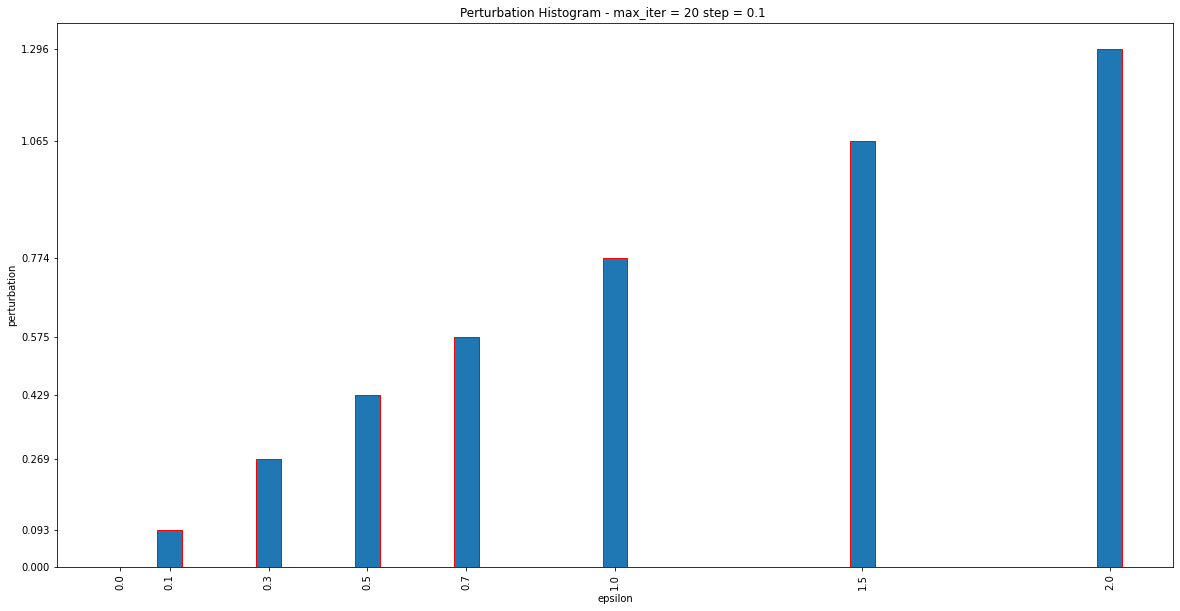

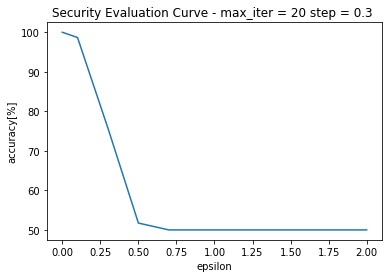

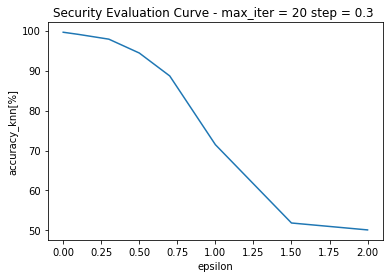

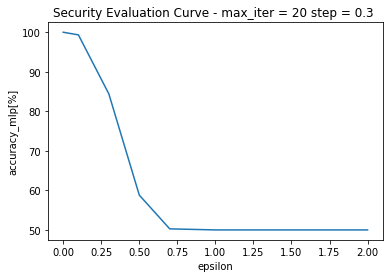

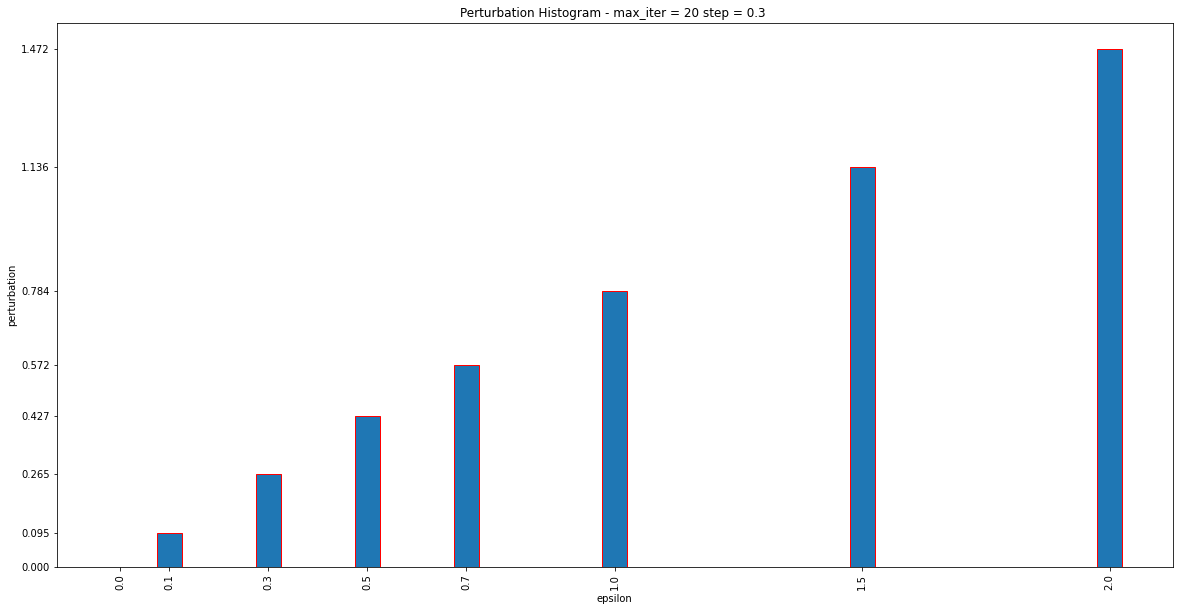

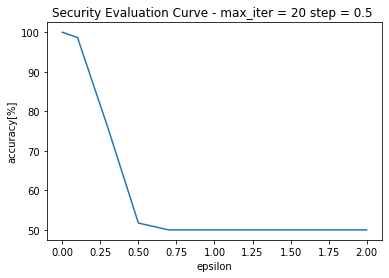

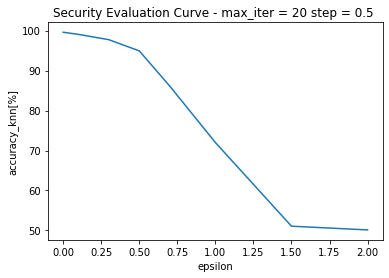

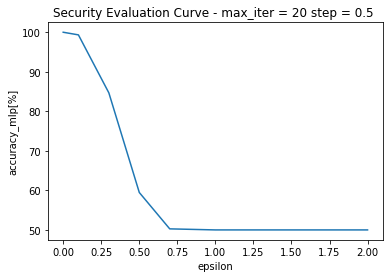

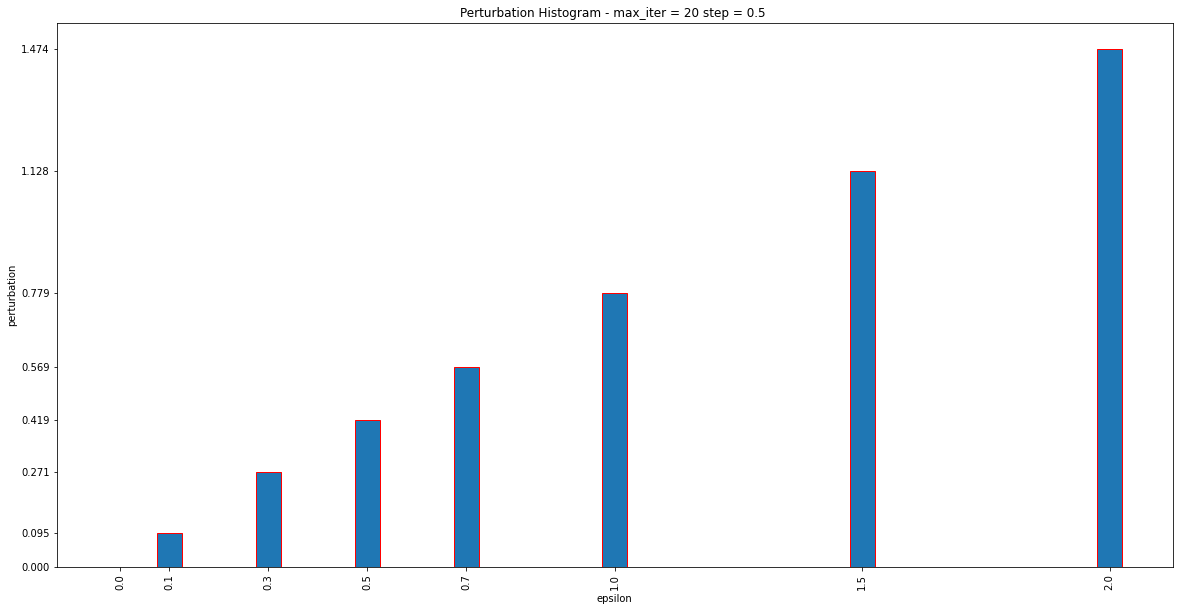

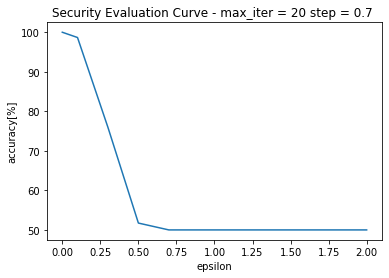

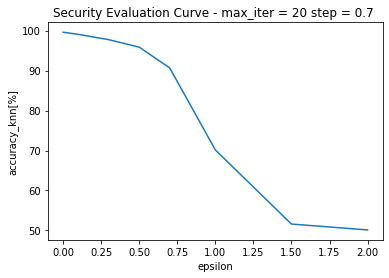

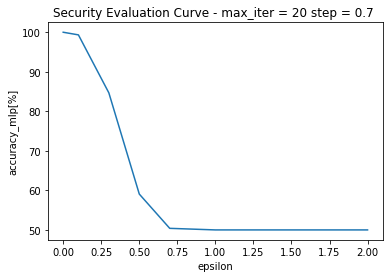

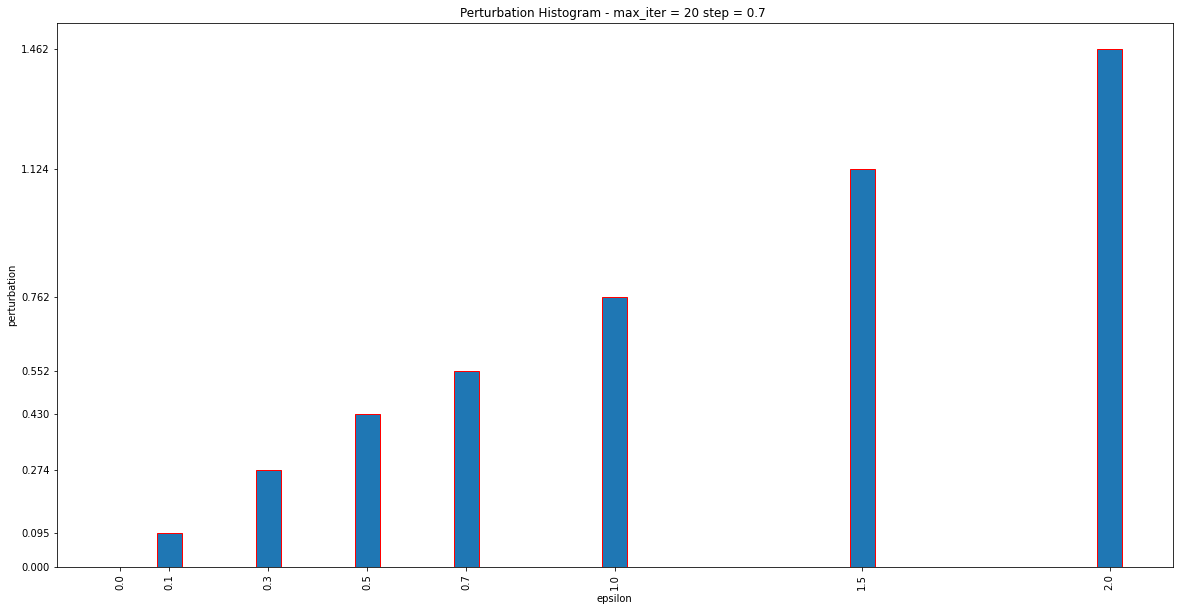

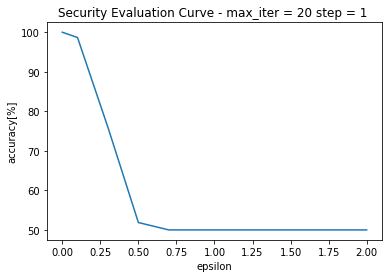

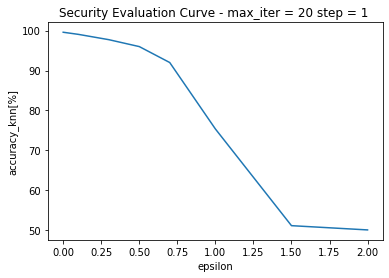

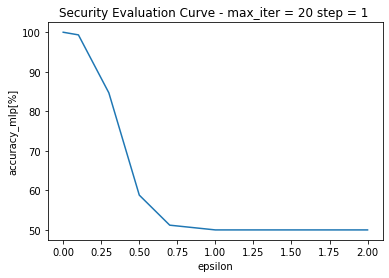

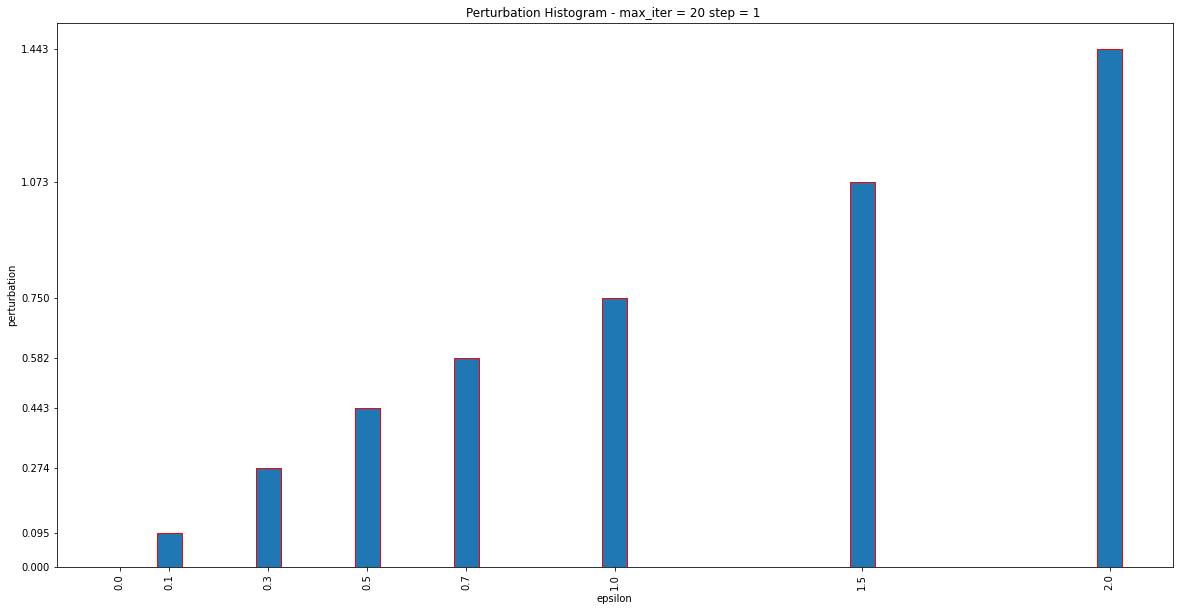

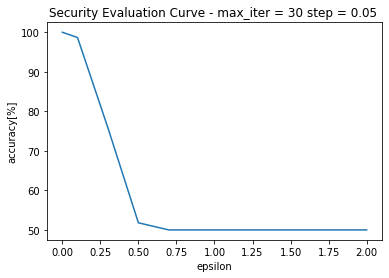

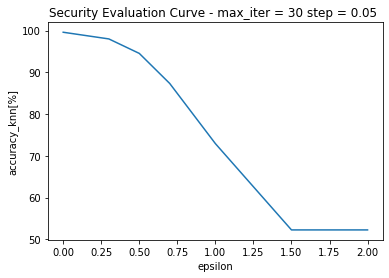

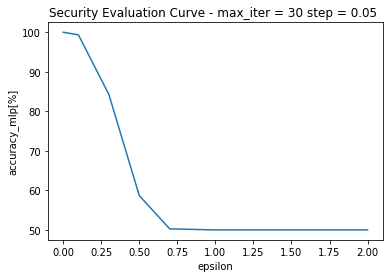

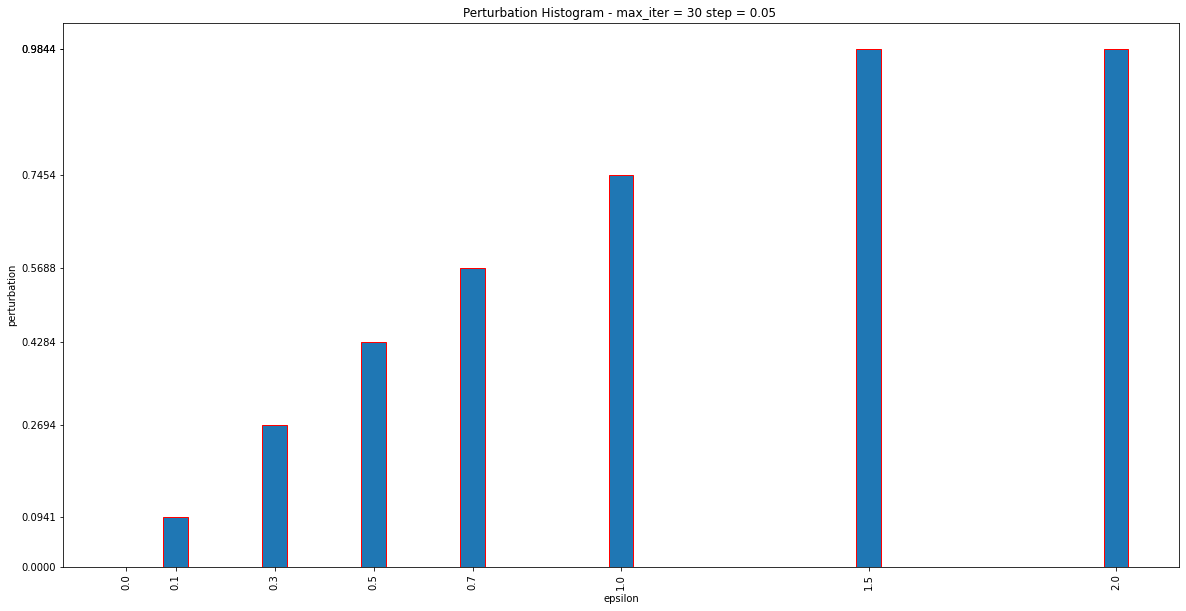

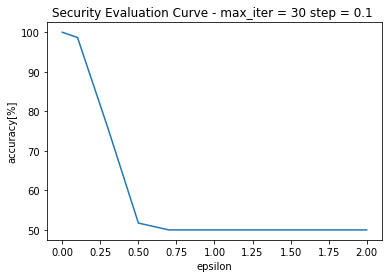

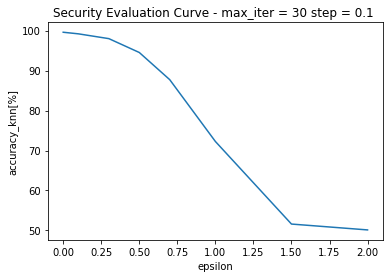

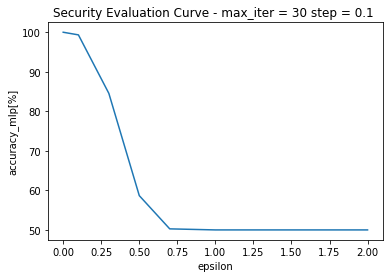

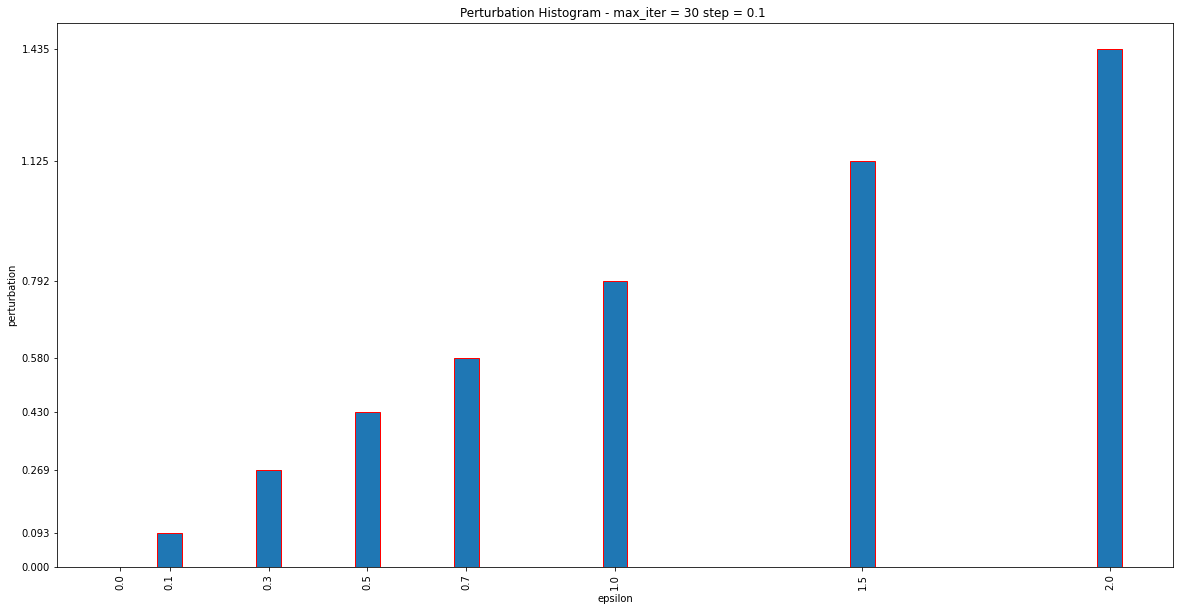

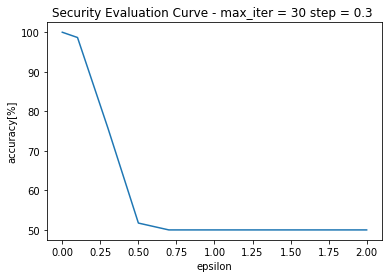

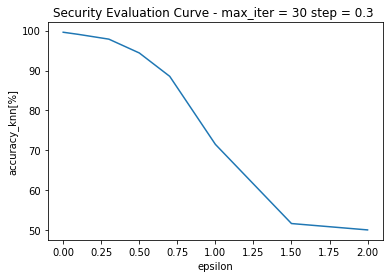

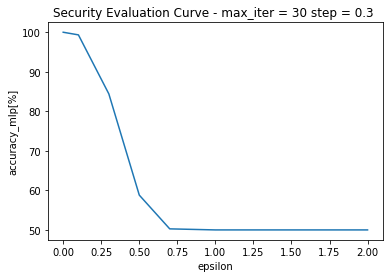

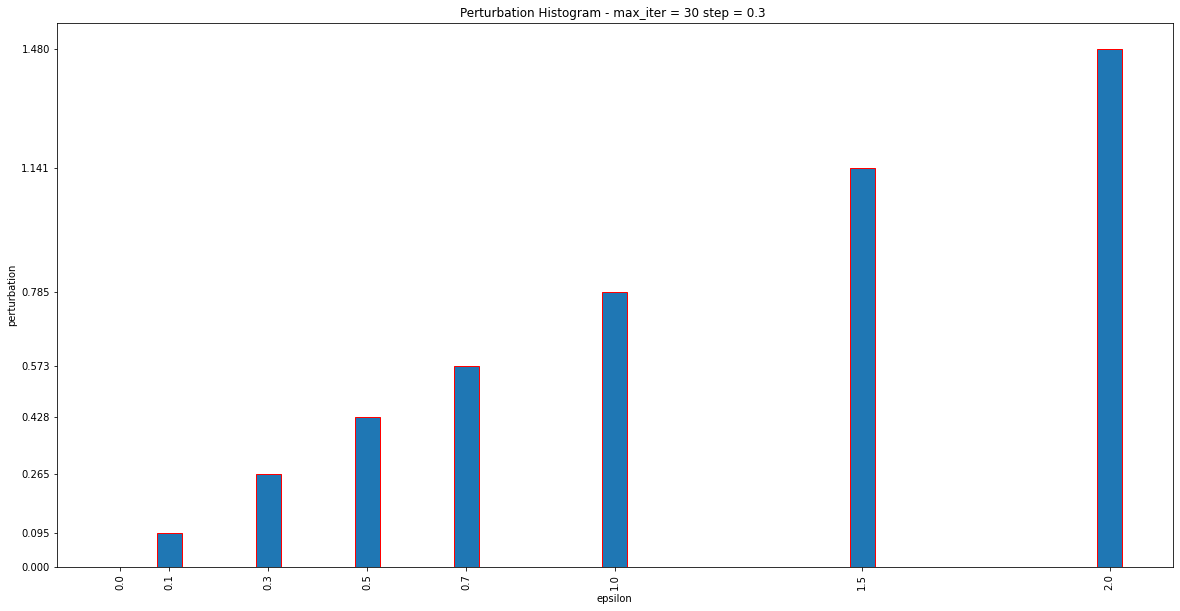

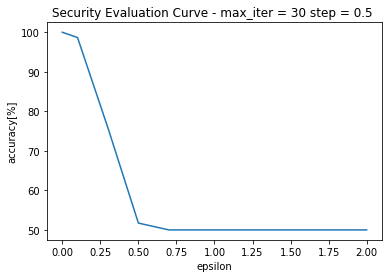

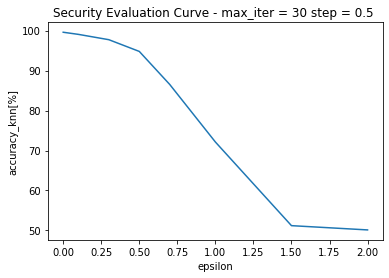

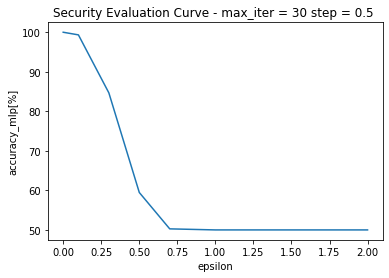

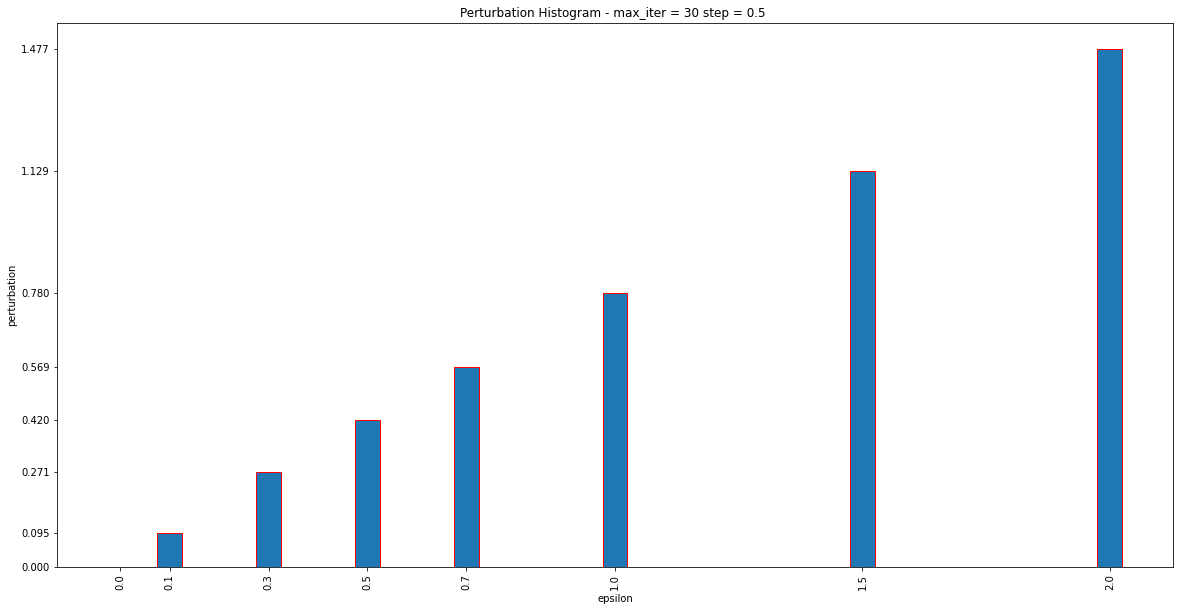

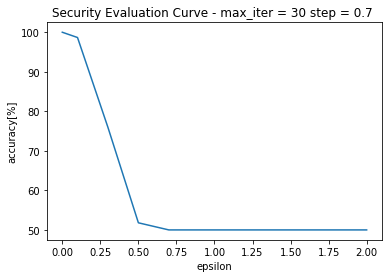

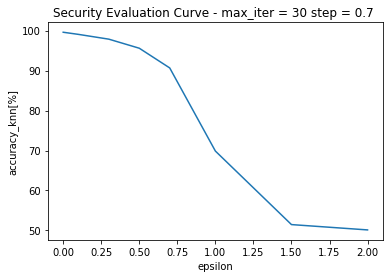

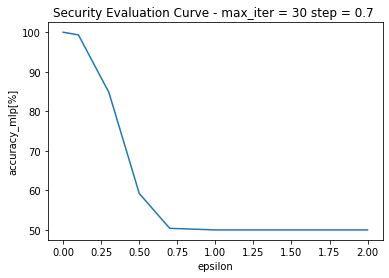

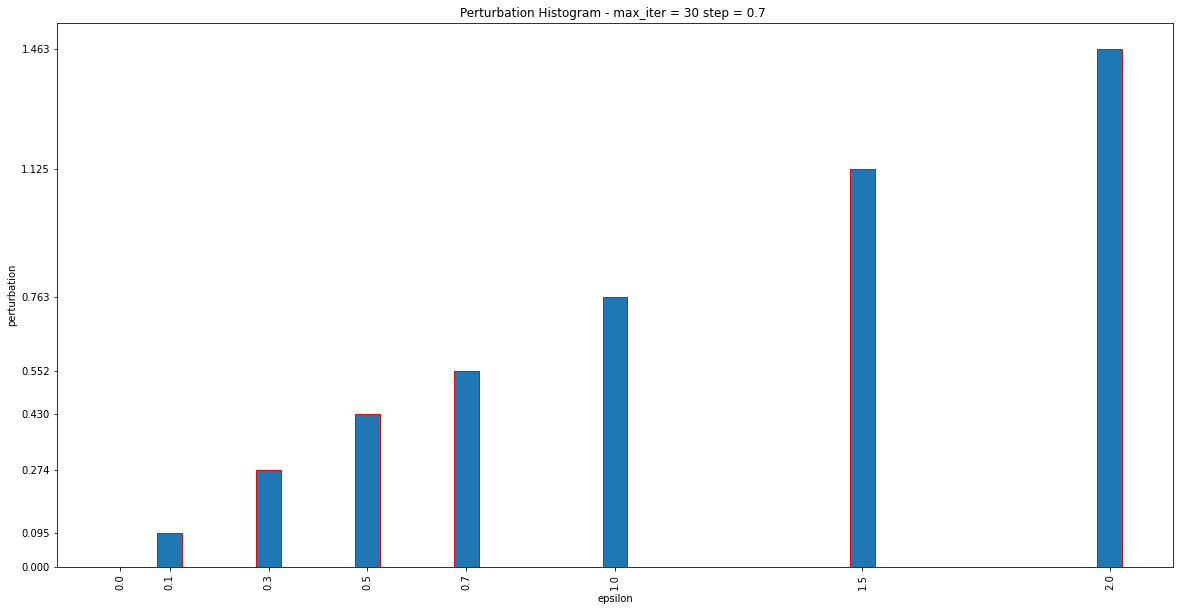

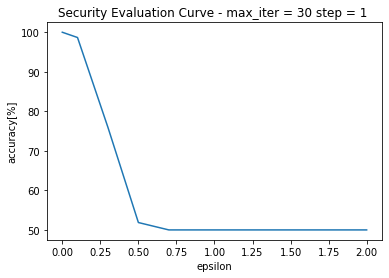

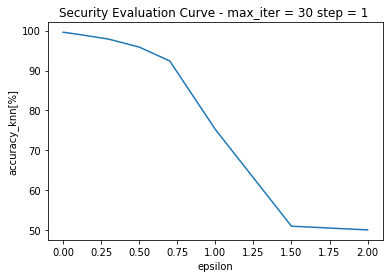

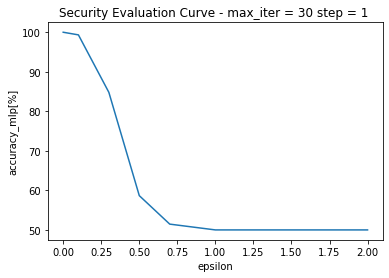

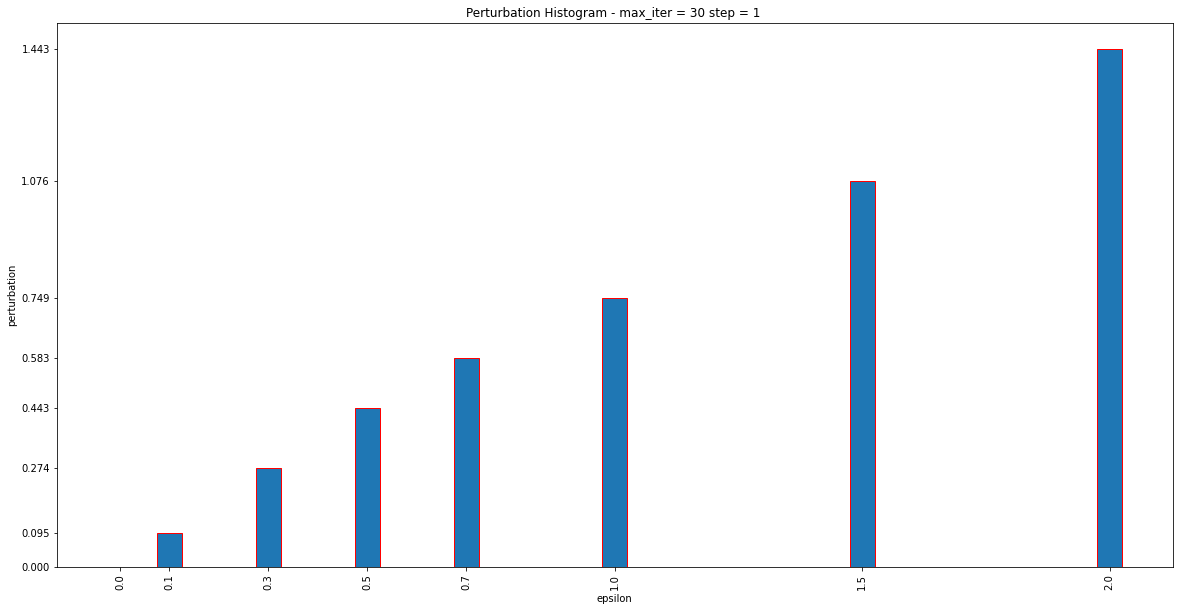

In [ ]:
result_bim_specific = {}
corrupted_bim_specific = []
target_class = [0, 1]
max_iters = [5, 10, 20, 30]
epsilon_steps = [0.05, 0.1, 0.3, 0.5, 0.7, 1]
epsilons = [0, 0.1, 0.3, 0.5, 0.7, 1, 1.5, 2]

for iter in max_iters:
  for step in epsilon_steps:
    perturbations = []
    accuracies = []
    accuracies_knn = []
    accuracies_mlp = []
    for eps in epsilons:
      attack = BasicIterativeMethod(estimator=classifier_gb, eps=eps, eps_step=step, max_iter=iter, targeted=True, verbose=False)
      one_hot_targeted_labels = target_class * np.ones(y_test.shape)
      att = attack.generate(x_test, one_hot_targeted_labels)
      corrupted_bim_specific.append(att)

      perturbation = np.mean(np.abs((att - x_test)))
      loss, accuracy = mlp_wb.evaluate(att, y_test)
      accuracy_knn = knn_bb.score(att, y_test)
      accuracy_mlp = mlp_bb.score(att, y_test)

      perturbations.append(perturbation)
      accuracies.append(accuracy * 100)
      accuracies_knn.append(accuracy_knn * 100)
      accuracies_mlp.append(accuracy_mlp * 100)

      result_bim_specific[iter, step, eps] = (perturbation, accuracy * 100)

    sec_eval_curve(epsilons, accuracies, ["epsilon", "accuracy[%]"], {"max_iter": iter, "step": step})
    sec_eval_curve(epsilons, accuracies_knn, ["epsilon", "accuracy_knn[%]"], {"max_iter": iter, "step": step})
    sec_eval_curve(epsilons, accuracies_mlp, ["epsilon", "accuracy_mlp[%]"], {"max_iter": iter, "step": step})
    perturbation_histogram(epsilons, perturbations, ["epsilon", "perturbation"], {"max_iter": iter, "step": step})
    print("\n")

os.makedirs(prec_attacks, exist_ok=True)
with open(os.path.join(prec_attacks, 'result_bim_specific.pkl'), 'wb') as f:
  pickle.dump(result_bim_specific, f)
with open(os.path.join(prec_attacks, 'corrupted_bim_specific.pkl'), 'wb') as f:
  pickle.dump(corrupted_bim_specific, f)

##### Load

In [ ]:
with open(os.path.join(prec_attacks, 'result_bim_specific.pkl'), 'rb') as f:
  result_bim_specific = pickle.load(f)
with open(os.path.join(prec_attacks, 'corrupted_bim_specific.pkl'), 'rb') as f:
  corrupted_bim_specific = pickle.load(f)

### PGD

##### Creation and Save `skippable`

In [ ]:
result_pgd_specific = {}
corrupted_pgd_specific = []
target_class = [0, 1]
num_random_init = [1, 5, 10]
max_iters = [5, 10, 20]
epsilon_steps = [0.1, 0.3, 0.5, 1]
epsilons = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1, 1.5, 2]

for rnd in num_random_init:
  for iter in max_iters:
    for step in epsilon_steps:
      perturbations = []
      accuracies = []
      accuracies_knn = []
      accuracies_mlp = []
      for eps in epsilons:
        attack = ProjectedGradientDescent(estimator=classifier_gb, eps=eps, eps_step=step, max_iter=iter, num_random_init = rnd, targeted=True, verbose=False)
        one_hot_targeted_labels = target_class * np.ones(y_test.shape)
        att = attack.generate(x_test, one_hot_targeted_labels)
        corrupted_pgd_specific.append(att)

        perturbation = np.mean(np.abs((att - x_test)))
        loss, accuracy = mlp_wb.evaluate(att, y_test)
        accuracy_knn = knn_bb.score(att, y_test)
        accuracy_mlp = mlp_bb.score(att, y_test)

        perturbations.append(perturbation)
        accuracies.append(accuracy * 100)
        accuracies_knn.append(accuracy_knn * 100)
        accuracies_mlp.append(accuracy_mlp * 100)

        result_pgd_specific[rnd, iter, step, eps] = (perturbation, accuracy * 100)

      sec_eval_curve(epsilons, accuracies, ["epsilon", "accuracy[%]"], {"random_init": rnd, "max_iter": iter, "step": step})
      sec_eval_curve(epsilons, accuracies_knn, ["epsilon", "accuracy_knn[%]"], {"random_init": rnd, "max_iter": iter, "step": step})
      sec_eval_curve(epsilons, accuracies_mlp, ["epsilon", "accuracy_mlp[%]"], {"random_init": rnd, "max_iter": iter, "step": step})
      perturbation_histogram(epsilons, perturbations, ["epsilon", "perturbation"], {"random_init": rnd, "max_iter": iter, "step": step})
      print("\n")

os.makedirs(prec_attacks, exist_ok=True)
with open(os.path.join(prec_attacks, 'result_pgd_specific.pkl'), 'wb') as f:
  pickle.dump(result_pgd_specific, f)
with open(os.path.join(prec_attacks, 'corrupted_pgd_specific.pkl'), 'wb') as f:
  pickle.dump(corrupted_pgd_specific, f)

Output hidden; open in https://colab.research.google.com to view.

##### Load

In [ ]:
with open(os.path.join(prec_attacks, 'result_pgd_specific.pkl'), 'rb') as f:
  result_pgd_specific = pickle.load(f)
with open(os.path.join(prec_attacks, 'corrupted_pgd_specific.pkl'), 'rb') as f:
  corrupted_pgd_specific = pickle.load(f)

### CARLINI-WAGNER

##### Creation and Save `skippable`

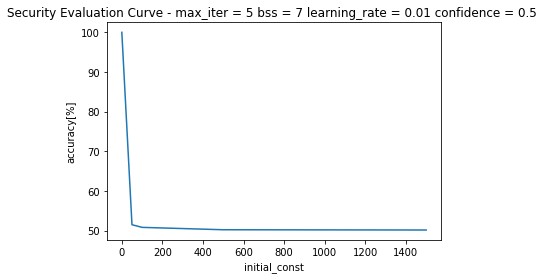

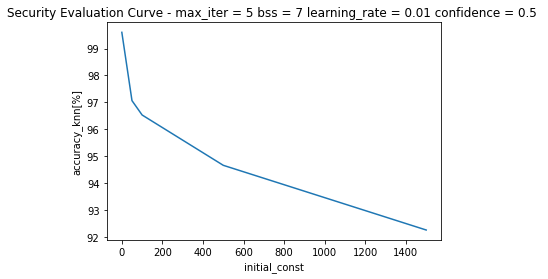

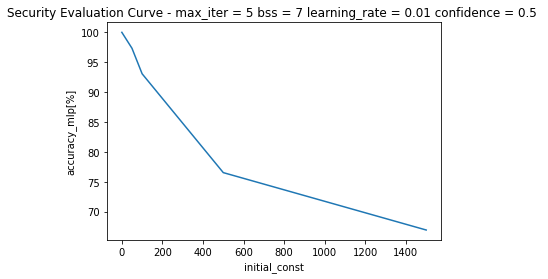

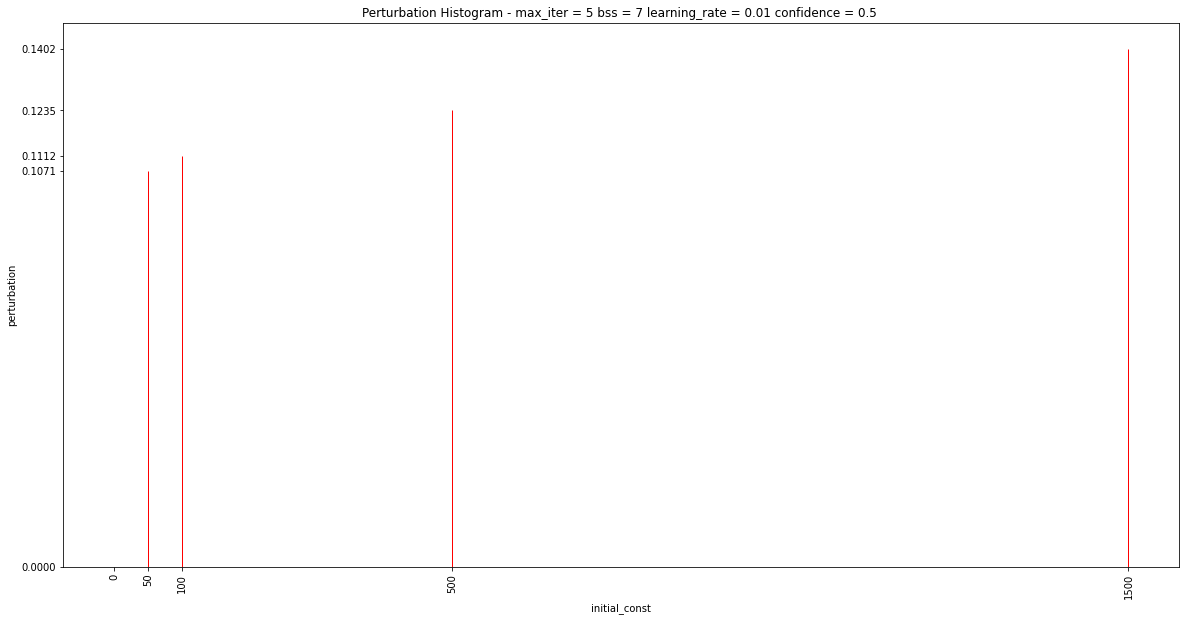

In [ ]:
result_cw_specific = {}
corrupted_cw_specific = []
target_class = [0, 1]
initial_consts = [0, 50, 100, 500, 1500]
binary_search_steps = 7
max_iter = 5
confidence = 0.5
learning_rate = 0.01

perturbations = []
accuracies = []
accuracies_knn = []
accuracies_mlp = []

for ic in initial_consts:
  attack = CarliniL2Method(classifier=classifier_dcw, binary_search_steps=binary_search_steps, confidence=confidence, max_iter=max_iter, learning_rate=learning_rate, initial_const=ic, targeted=True, verbose=False)
  one_hot_targeted_labels = target_class * np.ones(y_test.shape)
  att = attack.generate(x_test, one_hot_targeted_labels)
  corrupted_cw_specific.append(att)

  perturbation = np.mean(np.abs((att - x_test)))
  loss, accuracy = mlp_wb.evaluate(att, y_test)
  accuracy_knn = knn_bb.score(att, y_test)
  accuracy_mlp = mlp_bb.score(att, y_test)

  perturbations.append(perturbation)
  accuracies.append(accuracy * 100)
  accuracies_knn.append(accuracy_knn * 100)
  accuracies_mlp.append(accuracy_mlp * 100)

  result_cw_specific[max_iter, binary_search_steps, learning_rate, ic] = (perturbation, accuracy * 100)

sec_eval_curve(initial_consts, accuracies, ["initial_const", "accuracy[%]"], {"max_iter": max_iter, "bss": binary_search_steps, "learning_rate": learning_rate, "confidence": confidence})
sec_eval_curve(initial_consts, accuracies_knn, ["initial_const", "accuracy_knn[%]"], {"max_iter": max_iter, "bss": binary_search_steps, "learning_rate": learning_rate, "confidence": confidence})
sec_eval_curve(initial_consts, accuracies_mlp, ["initial_const", "accuracy_mlp[%]"], {"max_iter": max_iter, "bss": binary_search_steps, "learning_rate": learning_rate, "confidence": confidence})
perturbation_histogram(initial_consts, perturbations, ["initial_const", "perturbation"], {"max_iter": max_iter, "bss": binary_search_steps, "learning_rate": learning_rate, "confidence": confidence})

os.makedirs(prec_attacks, exist_ok=True)
with open(os.path.join(prec_attacks, 'result_cw_specific.pkl'), 'wb') as f:
  pickle.dump(result_cw_specific, f)
with open(os.path.join(prec_attacks, 'corrupted_cw_specific.pkl'), 'wb') as f:
  pickle.dump(corrupted_cw_specific, f)

##### Load

In [ ]:
with open(os.path.join(prec_attacks, 'result_cw_specific.pkl'), 'rb') as f:
  result_cw_specific = pickle.load(f)
with open(os.path.join(prec_attacks, 'corrupted_cw_specific.pkl'), 'rb') as f:
  corrupted_cw_specific = pickle.load(f)

# Defences

***Note***: in this section there are some steps marked as `skippable`.

"skippable" means that it is possible to not run that step because it will be possible to load the already constructed dataset subsequently.

**Attention**: you have 2 possibilities:
* skipping all steps marked as `skippable`
* not skipping any of the steps marked as `skippable` (it takes a lot of time)

## Detector of adversarial samples

### Robust model and classifiers `skippable`

In [ ]:
mlp_wb_robust = tf.keras.models.load_model(os.path.join(precomputed, 'mlp_wb.h5'))

classifier_robust_gb = KerasClassifier(model = mlp_wb_robust, clip_values = (min_f, max_f))   # Classifier for Gradient Based attacks

### Creation and Save `skippable`

In [ ]:
fgsm1 = FastGradientMethod(estimator=classifier_robust_gb, eps=0.05)
fgsm2 = FastGradientMethod(estimator=classifier_robust_gb, eps=0.1)
fgsm3 = FastGradientMethod(estimator=classifier_robust_gb, eps=0.15)
fgsm4 = FastGradientMethod(estimator=classifier_robust_gb, eps=0.2)

bim1 = BasicIterativeMethod(estimator=classifier_robust_gb, eps=1, eps_step=0.05, max_iter=20, verbose=False)
bim2 = BasicIterativeMethod(estimator=classifier_robust_gb, eps=2, eps_step=0.1, max_iter=20, verbose=False)
bim3 = BasicIterativeMethod(estimator=classifier_robust_gb, eps=0.5, eps_step=0.1, max_iter=5, verbose=False)
bim4 = BasicIterativeMethod(estimator=classifier_robust_gb, eps=1.5, eps_step=0.5, max_iter=3, verbose=False)

pgd1 = ProjectedGradientDescent(estimator=classifier_robust_gb, num_random_init=1, eps=1, eps_step=0.05, max_iter=20, verbose=False)
pgd2 = ProjectedGradientDescent(estimator=classifier_robust_gb, num_random_init=1, eps=2, eps_step=0.1, max_iter=20, verbose=False)
pgd3 = ProjectedGradientDescent(estimator=classifier_robust_gb, num_random_init=1, eps=0.5, eps_step=0.1, max_iter=5, verbose=False)
pgd4 = ProjectedGradientDescent(estimator=classifier_robust_gb, num_random_init=1, eps=1.5, eps_step=0.5, max_iter=3, verbose=False)

fgsms = [fgsm1, fgsm2, fgsm3, fgsm4]
bims = [bim1, bim2, bim3, bim4]
pgds = [pgd1, pgd2, pgd3, pgd4]

x_train_detector = np.empty((0, 512))
y_train_detector = np.empty((0, 512))

for i in range(4):
  x_train_adv = fgsms[i].generate(x_train)
  nb_train = x_train.shape[0]
  nb_train_adv = x_train_adv.shape[0]
  x_train_detector = np.concatenate((x_train, x_train_adv), axis=0)
  y_train_detector = np.concatenate((np.array([[1,0]]*nb_train), np.array([[0,1]]*nb_train_adv)), axis=0)

  x_train_adv = bims[i].generate(x_train)
  nb_train = x_train.shape[0]
  nb_train_adv = x_train_adv.shape[0]
  x_train_detector = np.concatenate((x_train_detector, x_train_adv), axis=0)
  y_train_detector = np.concatenate((y_train_detector, np.array([[0,1]]*nb_train_adv)), axis=0)

  x_train_adv = pgds[i].generate(x_train)
  nb_train = x_train.shape[0]
  nb_train_adv = x_train_adv.shape[0]
  x_train_detector = np.concatenate((x_train_detector, x_train_adv), axis=0)
  y_train_detector = np.concatenate((y_train_detector, np.array([[0,1]]*nb_train_adv)), axis=0)

detector = BinaryInputDetector(classifier_robust_gb)
detector.fit(x_train_detector, y_train_detector, nb_epochs=20, batch_size=32)
#mlp_wb_robust.save(os.path.join(precomputed, 'mlp_wb_robust_detector.h5'))

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 8984 samples
Epoch 1/20
8984/8984 [==============================] - 1s 158us/sample - loss: 0.4930 - accuracy: 0.8477
Epoch 2/20
8984/8984 [==============================] - 1s 137us/sample - loss: 0.0238 - accuracy: 0.9945
Epoch 3/20
8984/8984 [==============================] - 1s 137us/sample - loss: 0.0078 - accuracy: 0.9979
Epoch 4/20
8984/8984 [==============================] - 1s 133us/sample - loss: 0.0032 - accuracy: 0.9994
Epoch 5/20
8984/8984 [==============================] - 1s 133us/sample - loss: 0.0010 - accuracy: 0.9998
Epoch 6/20
8984/8984 [==============================] - 1s 161us/sample - loss: 3.2165e-04 - accuracy: 1.0000
Epoch 7/20
8984/8984 [==============================] - 3s 300us/sample - loss: 1.7639e-04 - accuracy: 1.0000
Epoch 8/20
8984/8984 [==============================] - 3s 289us/sample - loss: 1.1220e-04 - accuracy: 1.0000
Epoch 9/20
8984/8984 [==============================] - 1s 166us/sample - loss: 8.0698e-05 - accuracy: 1.0000
Epoch 10

### Load

In [ ]:
mlp_wb_robust = tf.keras.models.load_model(os.path.join(prec_models, 'mlp_wb_robust_detector.h5'))  # This mlp_wb_robust is the Detector

classifier_robust_gb = KerasClassifier(model = mlp_wb_robust, clip_values = (min_f, max_f))   # Classifier for Gradient Based attacks

### Testing robust classifier on original samples

In [ ]:
flag_original = np.sum(np.argmax(mlp_wb_robust.predict(x_test), axis=1) == 1)

print("Flagged: {}".format(flag_original))
print("Not flagged: {}".format(len(x_test) - flag_original))

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Flagged: 0
Not flagged: 750


### Generic

#### FGSM

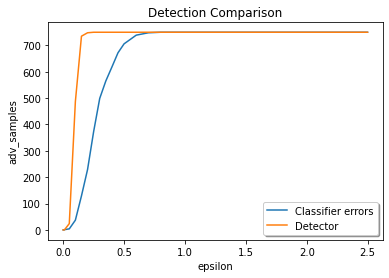

In [ ]:
epsilons = [0, 0.001, 0.003, 0.008, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2, 2.5]

nb_flag_adv = []
nb_missclass = []

for eps in epsilons:
    attack_robust = FastGradientMethod(classifier_gb, eps=eps, targeted=False)
    att_robust = attack_robust.generate(x_test)

    nb_flag_adv += [np.sum(np.argmax(mlp_wb_robust.predict(att_robust), axis=1) == 1)]
    nb_missclass += [np.sum(np.argmax(classifier_gb.predict(att_robust), axis=1) != np.argmax(y_test, axis=1))]

det_comparison(epsilons, [nb_missclass, nb_flag_adv], ["epsilon", "adv_samples"], ['Classifier errors', 'Detector'])

#### BIM

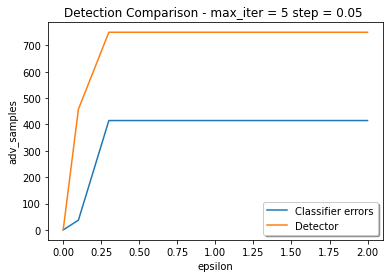

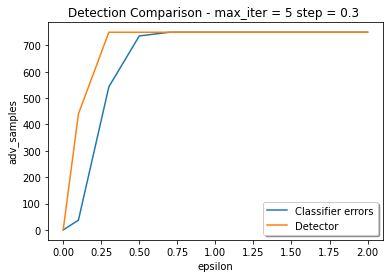

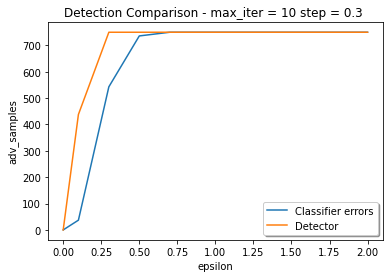

In [ ]:
combos = [(5, 0.05), (5, 0.3), (10, 0.3)]
epsilons = [0, 0.1, 0.3, 0.5, 0.7, 1, 1.5, 2]

for combo in combos:
  nb_flag_adv = []
  nb_missclass = []
  for eps in epsilons:
    attack_robust = BasicIterativeMethod(classifier_gb, eps=eps, eps_step=combo[1], max_iter=combo[0], targeted=False, verbose=False)
    att_robust = attack_robust.generate(x_test)

    nb_flag_adv += [np.sum(np.argmax(mlp_wb_robust.predict(att_robust), axis=1) == 1)]
    nb_missclass += [np.sum(np.argmax(classifier_gb.predict(att_robust), axis=1) != np.argmax(y_test, axis=1))]
    
  det_comparison(epsilons, [nb_missclass, nb_flag_adv], ["epsilon", "adv_samples"], ['Classifier errors', 'Detector'], {"max_iter": combo[0], "step": combo[1]})

#### PGD

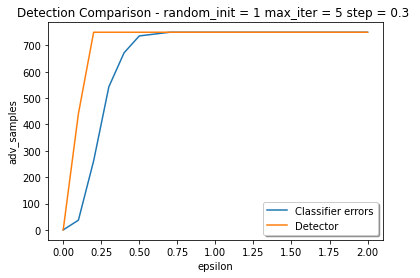

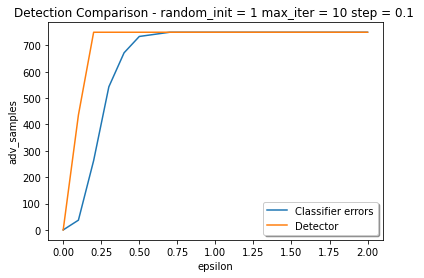

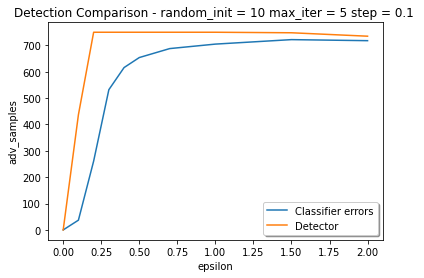

In [ ]:
combos = [(1, 5, 0.3), (1, 10, 0.1), (10, 5, 0.1)]
epsilons = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1, 1.5, 2]

for combo in combos:
  nb_flag_adv = []
  nb_missclass = []
  for eps in epsilons:
    attack_robust = ProjectedGradientDescent(estimator=classifier_gb, eps=eps, eps_step=combo[2], max_iter=combo[1], num_random_init = combo[0], targeted=False, verbose=False)
    att_robust = attack_robust.generate(x_test)
    
    nb_flag_adv += [np.sum(np.argmax(mlp_wb_robust.predict(att_robust), axis=1) == 1)]
    nb_missclass += [np.sum(np.argmax(classifier_gb.predict(att_robust), axis=1) != np.argmax(y_test, axis=1))]
        
  det_comparison(epsilons, [nb_missclass, nb_flag_adv], ["epsilon", "adv_samples"], ['Classifier errors', 'Detector'], {"random_init": combo[0], "max_iter": combo[1], "step": combo[2]})

#### CARLINI-WAGNER

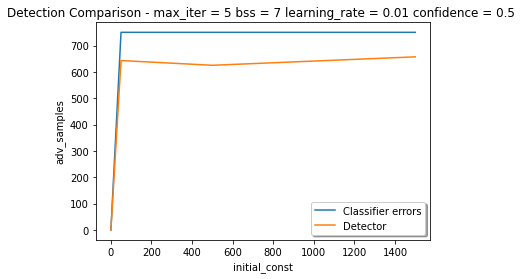

In [ ]:
initial_consts = [0, 50, 100, 500, 1500]
binary_search_steps = 7
max_iter = 5
confidence = 0.5
learning_rate = 0.01

nb_flag_adv = []
nb_missclass = []

for ic in initial_consts:
  attack_robust = CarliniL2Method(classifier=classifier_dcw, binary_search_steps=binary_search_steps, confidence=confidence, max_iter=max_iter, learning_rate=learning_rate, initial_const=ic, targeted=False, verbose=False)
  att_robust = attack_robust.generate(x_test)

  nb_flag_adv += [np.sum(np.argmax(mlp_wb_robust.predict(att_robust), axis=1) == 1)]
  nb_missclass += [np.sum(np.argmax(classifier_gb.predict(att_robust), axis=1) != np.argmax(y_test, axis=1))]
      
det_comparison(initial_consts, [nb_missclass, nb_flag_adv], ["initial_const", "adv_samples"], ['Classifier errors', 'Detector'], {"max_iter": max_iter, "bss": binary_search_steps, "learning_rate": learning_rate, "confidence": confidence})

### Specific

#### FGSM

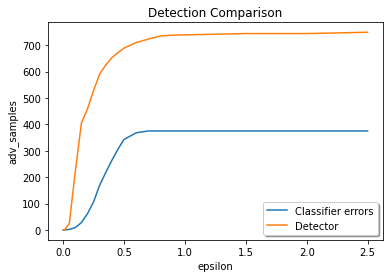

In [ ]:
target_class = [0, 1]
epsilons = [0, 0.001, 0.003, 0.008, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2, 2.5]

nb_flag_adv = []
nb_missclass = []

for eps in epsilons:
    attack_robust = FastGradientMethod(classifier_gb, eps=eps, targeted=True)
    one_hot_targeted_labels = target_class * np.ones(y_test.shape)
    att_robust = attack_robust.generate(x_test, one_hot_targeted_labels)
    
    nb_flag_adv += [np.sum(np.argmax(mlp_wb_robust.predict(att_robust), axis=1) == 1)]
    nb_missclass += [np.sum(np.argmax(classifier_gb.predict(att_robust), axis=1) != np.argmax(y_test, axis=1))]
  
det_comparison(epsilons, [nb_missclass, nb_flag_adv], ["epsilon", "adv_samples"], ['Classifier errors', 'Detector'])

#### BIM

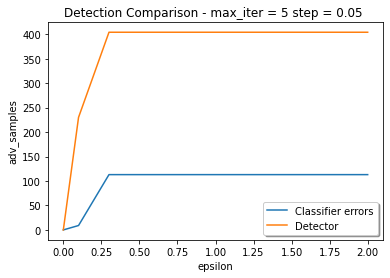

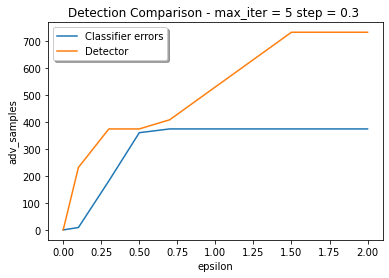

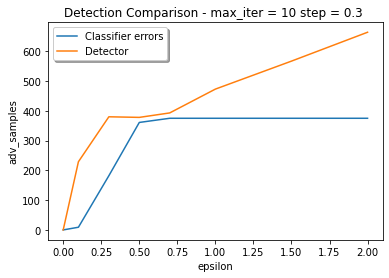

In [ ]:
target_class = [0, 1]
combos = [(5, 0.05), (5, 0.3), (10, 0.3)]
epsilons = [0, 0.1, 0.3, 0.5, 0.7, 1, 1.5, 2]

for combo in combos:
  nb_flag_adv = []
  nb_missclass = []
  for eps in epsilons:
    attack_robust = BasicIterativeMethod(classifier_gb, eps=eps, eps_step=combo[1], max_iter=combo[0], targeted=True, verbose=False)
    one_hot_targeted_labels = target_class * np.ones(y_test.shape)
    att_robust = attack_robust.generate(x_test, one_hot_targeted_labels)
    
    nb_flag_adv += [np.sum(np.argmax(mlp_wb_robust.predict(att_robust), axis=1) == 1)]
    nb_missclass += [np.sum(np.argmax(classifier_gb.predict(att_robust), axis=1) != np.argmax(y_test, axis=1))]
    
  det_comparison(epsilons, [nb_missclass, nb_flag_adv], ["epsilon", "adv_samples"], ['Classifier errors', 'Detector'], {"max_iter": combo[0], "step": combo[1]})

#### PGD

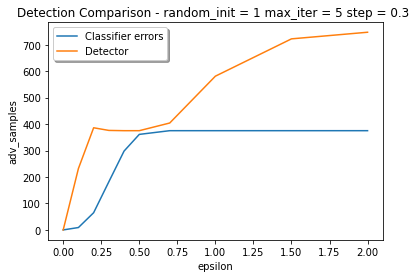

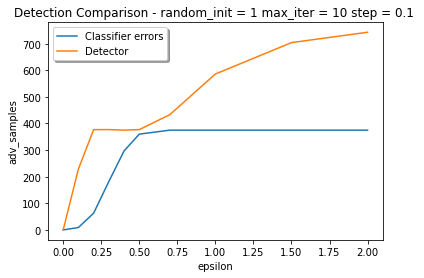

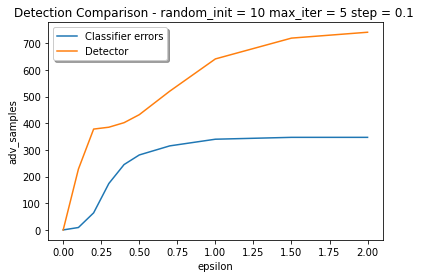

In [ ]:
target_class = [0, 1]
combos = [(1, 5, 0.3), (1, 10, 0.1), (10, 5, 0.1)]
epsilons = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1, 1.5, 2]

for combo in combos:
  nb_flag_adv = []
  nb_missclass = []
  for eps in epsilons:
    attack_robust = ProjectedGradientDescent(estimator=classifier_gb, eps=eps, eps_step=combo[2], max_iter=combo[1], num_random_init=combo[0], targeted=True, verbose=False)
    one_hot_targeted_labels = target_class * np.ones(y_test.shape)
    att_robust = attack_robust.generate(x_test, one_hot_targeted_labels)
    
    nb_flag_adv += [np.sum(np.argmax(mlp_wb_robust.predict(att_robust), axis=1) == 1)]
    nb_missclass += [np.sum(np.argmax(classifier_gb.predict(att_robust), axis=1) != np.argmax(y_test, axis=1))]
    
  det_comparison(epsilons, [nb_missclass, nb_flag_adv], ["epsilon", "adv_samples"], ['Classifier errors', 'Detector'], {"random_init": combo[0], "max_iter": combo[1], "step": combo[2]})

#### CARLINI-WAGNER

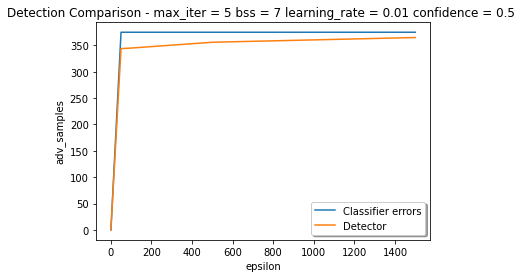

In [ ]:
target_class = [0, 1]
initial_consts = [0, 50, 100, 500, 1500]
binary_search_steps = 7
max_iter = 5
confidence = 0.5
learning_rate = 0.01

nb_flag_adv = []
nb_missclass = []

for ic in initial_consts:
  attack_robust = CarliniL2Method(classifier=classifier_dcw, binary_search_steps=binary_search_steps, confidence=confidence, max_iter=max_iter, learning_rate=learning_rate, initial_const=ic, targeted=True, verbose=False)
  one_hot_targeted_labels = target_class * np.ones(y_test.shape)
  att_robust = attack_robust.generate(x_test, one_hot_targeted_labels)
  
  nb_flag_adv += [np.sum(np.argmax(mlp_wb_robust.predict(att_robust), axis=1) == 1)]
  nb_missclass += [np.sum(np.argmax(classifier_gb.predict(att_robust), axis=1) != np.argmax(y_test, axis=1))]
    
det_comparison(initial_consts, [nb_missclass, nb_flag_adv], ["epsilon", "adv_samples"], ['Classifier errors', 'Detector'], {"max_iter": max_iter, "bss": binary_search_steps, "learning_rate": learning_rate, "confidence": confidence})

### Final gradient-based evaluation

In [ ]:
final_x_test = []
final_x_test = np.concatenate((corrupted_fgsm_generic, corrupted_bim_generic, corrupted_pgd_generic, corrupted_fgsm_specific, corrupted_bim_specific, corrupted_pgd_specific))

final_y_test = np.empty((0, y_test.shape[1]))

for i in range(final_x_test.shape[0]):
  final_y_test = np.concatenate((final_y_test, y_test), axis=0)

final_x_test = np.vstack(final_x_test)

final_test_evaluate = np.sum(np.argmax(mlp_wb_robust.predict(final_x_test), axis=1) == 1)
print(f'Test results - Accuracy: {final_test_evaluate/final_x_test.shape[0]*100} %')

Test results - Accuracy: 68.35698550724638 %


## Adversarial Train

### Robust model and classifiers `skippable`

In [ ]:
mlp_wb_robust = tf.keras.models.load_model(os.path.join(precomputed, 'mlp_wb.h5'))

classifier_robust_gb = KerasClassifier(model = mlp_wb_robust, clip_values = (min_f, max_f))   # Classifier for Gradient Based attacks

logit_model_robust = tf.keras.Model(mlp_wb_robust.input, mlp_wb_robust.layers[-2].output)
classifier_robust_dcw = KerasClassifier(model=logit_model_robust, clip_values=(min_f, max_f))   # Classifier for Deepfool and Carlini-Wagner

### Creation and Save `skippable`

In [ ]:
max_iters = [5, 10, 20]
epsilon_steps = [0.05, 0.1, 0.2] 
epsilons = [0.2, 0.3, 0.5, 1, 1.5, 2]
for iter in max_iters:
  for step in epsilon_steps:
    for eps in epsilons:
      attacks_bim = BasicIterativeMethod(estimator=classifier_robust_gb, eps=eps, eps_step=step, max_iter=iter, verbose=False)
      attacks_pgd = ProjectedGradientDescent(estimator=classifier_robust_gb, eps=eps, eps_step=step, max_iter=iter, num_random_init=1, verbose=False)
      attacks_adv = [attacks_bim, attacks_pgd]
      trainer = AdversarialTrainer(classifier_robust_gb, attacks_adv, ratio=0.9)
      trainer.fit(x_train, y_train, nb_epochs=10, batch_size=32)
#mlp_wb_robust.save(os.path.join(precomputed, 'mlp_wb_robust_adv.h5'))

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

### Load

In [ ]:
mlp_wb_robust = tf.keras.models.load_model(os.path.join(prec_models, 'mlp_wb_robust_adv.h5'))

classifier_robust_gb = KerasClassifier(model = mlp_wb_robust, clip_values = (min_f, max_f))   # Classifier for Gradient Based attacks

logit_model_robust = tf.keras.Model(mlp_wb_robust.input, mlp_wb_robust.layers[-2].output)
classifier_robust_dcw = KerasClassifier(model=logit_model_robust, clip_values=(min_f, max_f))   # Classifier for Deepfool and Carlini-Wagner

### Testing robust classifier on original samples

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Test results - Loss: 0.45352313629786173 - Accuracy: 99.80000257492065 %


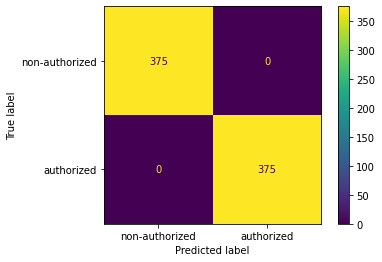

In [ ]:
# Test the MLP model after training
test_results_robust = mlp_wb_robust.evaluate(x_test, y_test)
print(f'Test results - Loss: {test_results_robust[0]} - Accuracy: {test_results_robust[1]*100} %')

# Calculating Labels
pred_mlp_wb_robust = mlp_wb_robust.predict(x_test)
y_pred_mlp_wb_robust = np.argmax(pred_mlp_wb_robust, axis = 1)
y_test_conf_robust = np.argmax(y_test, axis = 1)

# Plotting Confusion Matrix
conf = confusion_matrix(y_test_conf_robust, y_pred_mlp_wb_robust)
disp = ConfusionMatrixDisplay(confusion_matrix = conf, display_labels=['non-authorized','authorized'])
disp.plot()
plt.show()

### Generic

#### FGSM

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


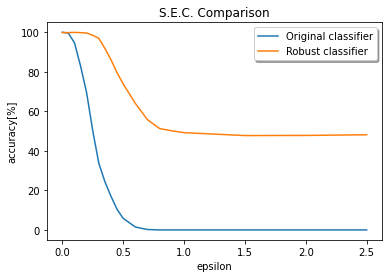

The average accuracy: 79.94782678459002


In [ ]:
epsilons = [0, 0.001, 0.003, 0.008, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2, 2.5]

accuracies = []
acc_robusts = []

for eps in epsilons:
    perturbation, accuracy = result_fgsm_generic[eps]
    accuracies.append(accuracy)
    
    attack_robust = FastGradientMethod(classifier_robust_gb, eps=eps, targeted=False)
    att_robust = attack_robust.generate(x_test)

    loss_robust, acc_robust = mlp_wb_robust.evaluate(att_robust, y_test)

    acc_robusts.append(acc_robust * 100)

sec_comparison(epsilons, [accuracies, acc_robusts], ["epsilon", "accuracy[%]"], ['Original classifier', 'Robust classifier'])
print("The average accuracy:", sum(acc_robusts)/len(acc_robusts))

#### BIM

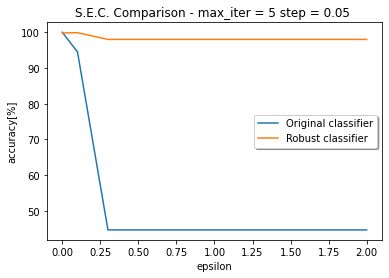

The average accuracy: 98.45833480358124


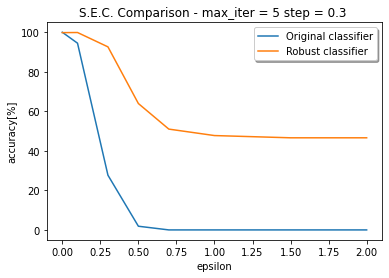

The average accuracy: 68.51666606962681


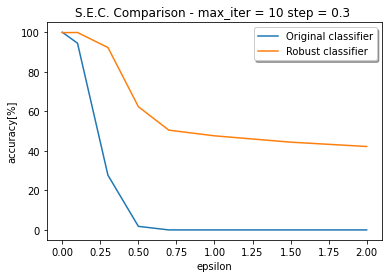

The average accuracy: 67.36666709184647


In [ ]:
combos = [(5, 0.05), (5, 0.3), (10, 0.3)]
epsilons = [0, 0.1, 0.3, 0.5, 0.7, 1, 1.5, 2]

for combo in combos:
  accuracies = []
  acc_robusts = []
  for eps in epsilons:
    perturbation, accuracy = result_bim_generic[combo[0], combo[1], eps]
    accuracies.append(accuracy)

    attack_robust = BasicIterativeMethod(classifier_robust_gb, eps=eps, eps_step=combo[1], max_iter=combo[0], targeted=False, verbose=False)
    att_robust = attack_robust.generate(x_test)

    loss_robust, acc_robust = mlp_wb_robust.evaluate(att_robust, y_test)

    acc_robusts.append(acc_robust * 100)
    
  sec_comparison(epsilons, [accuracies, acc_robusts], ["epsilon", "accuracy[%]"], ['Original classifier', 'Robust classifier'], {"max_iter": combo[0], "step": combo[1]})
  print("The average accuracy:", sum(acc_robusts)/len(acc_robusts))

#### PGD

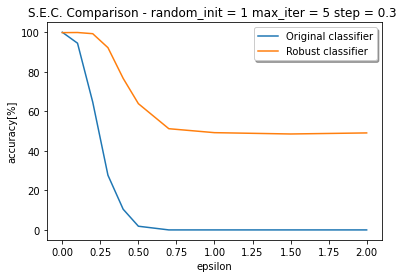

The average accuracy: 72.9666668176651


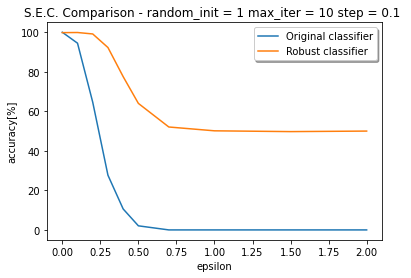

The average accuracy: 73.45333337783813


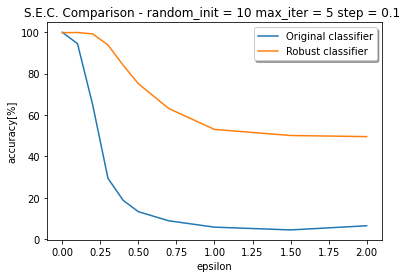

The average accuracy: 76.78666651248932


In [ ]:
combos = [(1, 5, 0.3), (1, 10, 0.1), (10, 5, 0.1)]
epsilons = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1, 1.5, 2]

for combo in combos:
  accuracies = []
  acc_robusts = []
  for eps in epsilons:
    perturbation, accuracy = result_pgd_generic[combo[0], combo[1], combo[2], eps]
    accuracies.append(accuracy)

    attack_robust = ProjectedGradientDescent(estimator=classifier_robust_gb, eps=eps, eps_step=combo[2], max_iter=combo[1], num_random_init = combo[0], targeted=False, verbose=False)
    att_robust = attack_robust.generate(x_test)

    loss_robust, acc_robust = mlp_wb_robust.evaluate(att_robust, y_test)

    acc_robusts.append(acc_robust * 100)
    
  sec_comparison(epsilons, [accuracies, acc_robusts], ["epsilon", "accuracy[%]"], ['Original classifier', 'Robust classifier'], {"random_init": combo[0], "max_iter": combo[1], "step": combo[2]})
  print("The average accuracy:", sum(acc_robusts)/len(acc_robusts))

#### CARLINI-WAGNER

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


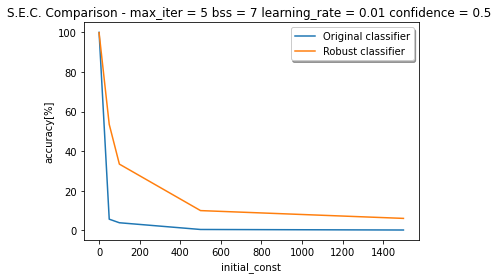

The average accuracy: 40.57333394885063


In [ ]:
initial_consts = [0, 50, 100, 500, 1500]
binary_search_steps = 7
max_iter = 5
confidence = 0.5
learning_rate = 0.01

accuracies = []
acc_robusts = []

for ic in initial_consts:
  perturbation, accuracy = result_cw_generic[max_iter, binary_search_steps, learning_rate, ic]
  accuracies.append(accuracy)

  attack_robust = CarliniL2Method(classifier=classifier_robust_dcw, binary_search_steps=binary_search_steps, confidence=confidence, max_iter=max_iter, learning_rate=learning_rate, initial_const=ic, targeted=False, verbose=False)
  att_robust = attack_robust.generate(x_test)

  loss_robust, acc_robust = mlp_wb_robust.evaluate(att_robust, y_test)

  acc_robusts.append(acc_robust * 100)
    
sec_comparison(initial_consts, [accuracies, acc_robusts], ["initial_const", "accuracy[%]"], ['Original classifier', 'Robust classifier'], {"max_iter": max_iter, "bss": binary_search_steps, "learning_rate": learning_rate, "confidence": confidence})
print("The average accuracy:", sum(acc_robusts)/len(acc_robusts))

### Specific

#### FGSM

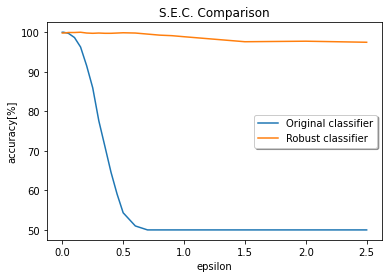

The average accuracy: 99.42318900771762


In [ ]:
target_class = [0, 1]
epsilons = [0, 0.001, 0.003, 0.008, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2, 2.5]

accuracies = []
acc_robusts = []

for eps in epsilons:
    perturbation, accuracy = result_fgsm_specific[eps]
    accuracies.append(accuracy)

    attack_robust = FastGradientMethod(classifier_robust_gb, eps=eps, targeted=True)
    one_hot_targeted_labels = target_class * np.ones(y_test.shape)
    att_robust = attack_robust.generate(x_test, one_hot_targeted_labels)

    loss_robust, acc_robust = mlp_wb_robust.evaluate(att_robust, y_test)

    acc_robusts.append(acc_robust * 100)

sec_comparison(epsilons, [accuracies, acc_robusts], ["epsilon", "accuracy[%]"], ['Original classifier', 'Robust classifier'])
print("The average accuracy:", sum(acc_robusts)/len(acc_robusts))

#### BIM

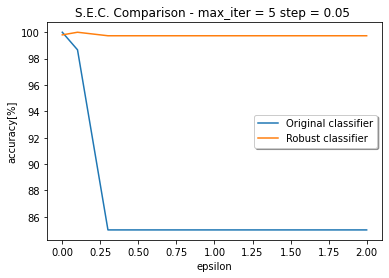

The average accuracy: 99.77500140666962


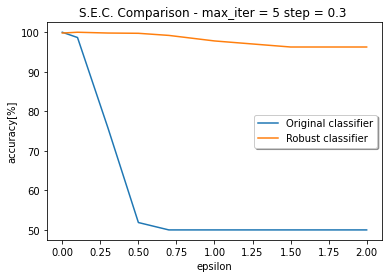

The average accuracy: 98.60833436250687


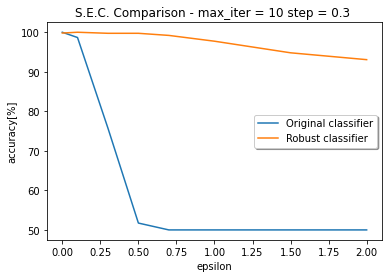

The average accuracy: 98.00833389163017


In [ ]:
target_class = [0, 1]
combos = [(5, 0.05), (5, 0.3), (10, 0.3)]
epsilons = [0, 0.1, 0.3, 0.5, 0.7, 1, 1.5, 2]

for combo in combos:
  accuracies = []
  acc_robusts = []
  for eps in epsilons:
    perturbation, accuracy = result_bim_specific[combo[0], combo[1], eps]
    accuracies.append(accuracy)

    attack_robust = BasicIterativeMethod(classifier_robust_gb, eps=eps, eps_step=combo[1], max_iter=combo[0], targeted=True, verbose=False)
    one_hot_targeted_labels = target_class * np.ones(y_test.shape)
    att_robust = attack_robust.generate(x_test, one_hot_targeted_labels)

    loss_robust, acc_robust = mlp_wb_robust.evaluate(att_robust, y_test)

    acc_robusts.append(acc_robust * 100)
    
  sec_comparison(epsilons, [accuracies, acc_robusts], ["epsilon", "accuracy[%]"], ['Original classifier', 'Robust classifier'], {"max_iter": combo[0], "step": combo[1]})
  print("The average accuracy:", sum(acc_robusts)/len(acc_robusts))

#### PGD

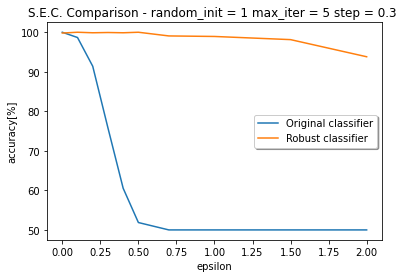

The average accuracy: 98.93999993801117


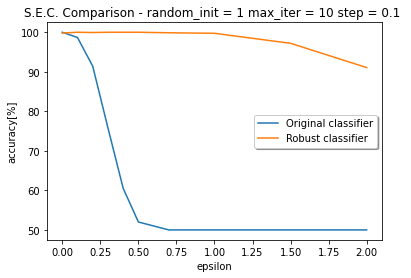

The average accuracy: 98.75999987125397


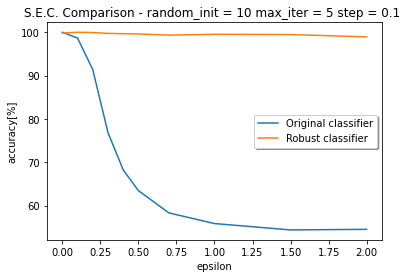

The average accuracy: 99.60000038146973


In [ ]:
target_class = [0, 1]
combos = [(1, 5, 0.3), (1, 10, 0.1), (10, 5, 0.1)]
epsilons = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1, 1.5, 2]

for combo in combos:
  accuracies = []
  acc_robusts = []
  for eps in epsilons:
    perturbation, accuracy = result_pgd_specific[combo[0], combo[1], combo[2], eps]
    accuracies.append(accuracy)

    attack_robust = ProjectedGradientDescent(estimator=classifier_robust_gb, eps=eps, eps_step=combo[2], max_iter=combo[1], num_random_init=combo[0], targeted=True, verbose=False)
    one_hot_targeted_labels = target_class * np.ones(y_test.shape)
    att_robust = attack_robust.generate(x_test, one_hot_targeted_labels)

    loss_robust, acc_robust = mlp_wb_robust.evaluate(att_robust, y_test)

    acc_robusts.append(acc_robust * 100)
    
  sec_comparison(epsilons, [accuracies, acc_robusts], ["epsilon", "accuracy[%]"], ['Original classifier', 'Robust classifier'], {"random_init": combo[0], "max_iter": combo[1], "step": combo[2]})
  print("The average accuracy:", sum(acc_robusts)/len(acc_robusts))

#### CARLINI-WAGNER

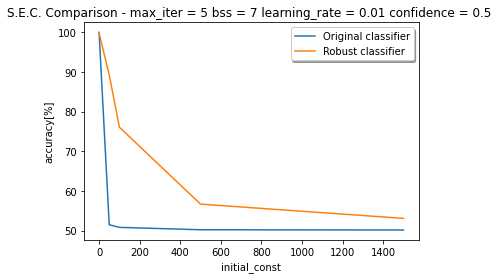

The average accuracy: 74.97333288192749


In [ ]:
target_class = [0, 1]
initial_consts = [0, 50, 100, 500, 1500]
binary_search_steps = 7
max_iter = 5
confidence = 0.5
learning_rate = 0.01

accuracies = []
acc_robusts = []

for ic in initial_consts:
  perturbation, accuracy = result_cw_specific[max_iter, binary_search_steps, learning_rate, ic]
  accuracies.append(accuracy)

  attack_robust = CarliniL2Method(classifier=classifier_robust_dcw, binary_search_steps=binary_search_steps, confidence=confidence, max_iter=max_iter, learning_rate=learning_rate, initial_const=ic, targeted=True, verbose=False)
  one_hot_targeted_labels = target_class * np.ones(y_test.shape)
  att_robust = attack_robust.generate(x_test, one_hot_targeted_labels)

  loss_robust, acc_robust = mlp_wb_robust.evaluate(att_robust, y_test)

  acc_robusts.append(acc_robust * 100)
    
sec_comparison(initial_consts, [accuracies, acc_robusts], ["initial_const", "accuracy[%]"], ['Original classifier', 'Robust classifier'], {"max_iter": max_iter, "bss": binary_search_steps, "learning_rate": learning_rate, "confidence": confidence})
print("The average accuracy:", sum(acc_robusts)/len(acc_robusts))

### Final gradient-based evaluation

In [ ]:
final_x_test = []
final_x_test = np.concatenate((corrupted_fgsm_generic, corrupted_bim_generic, corrupted_pgd_generic, corrupted_fgsm_specific, corrupted_bim_specific, corrupted_pgd_specific))

final_y_test = np.empty((0, y_test.shape[1]))

for i in range(final_x_test.shape[0]):
  final_y_test = np.concatenate((final_y_test, y_test), axis=0)

final_x_test = np.vstack(final_x_test)

final_test_evaluate = mlp_wb_robust.evaluate(final_x_test, final_y_test)
print(f'Test results - Loss: {final_test_evaluate[0]} - Accuracy: {final_test_evaluate[1]*100} %')

Test results - Loss: 0.5682367330421226 - Accuracy: 77.23084092140198 %
